<a href="https://colab.research.google.com/github/nielsleadholm/CNN_Binding/blob/master/BoundaryAttack_vs_MadryMethod%26BindingCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Boundary Attack vs Madry Method and Binding-CNNs

Implement the Boundary attack method (Brendel et al, 2018) against the Madry et al (2017) method of adversarial resistance, then explore novel neural network architectures for greater adversarial resistance.


##Background/Introduction

###What are adversarial examples?

In recent years machine learning systems have significantly improved their performance on challenging tasks such as object recognition. Despite achieving near human-level performance on many of these problems, it has been realised that state-of-the-art machine learning systems such as deep neural networks are susceptible to subtle changes in the input space that would otherwise not be considered sufficient to change the true class of an item. For example, in the domain of vision, slight adjustments in pixel intensity that are imperceptible to humans can result in catastrophic misclassification by an otherwise well-performing model.

These engineered stimuli that fool the network are known as 'adversarial examples', and their generation as 'adversarial attacks'. Worryingly, adversarial examples have been found in multiple domain (such as audio and natural-language processing), function 'in the wild' (e.g. via video-feeds), and are known to generalize across machine learning systems.

###What are black box attacks, and what is the Boundary Attack?

The earliest methods for developing adversarial examples relied in detailed information about the network being attacked: specficially, how the gradient of the loss function relates to the input space. This enables calculated adjustments of the input domain so as to create an example that will be misclassified. Such methods are known as 'white box attacks' due to their intimate knowledge of the network.

Other methods enable attacks to be mounted with little information about the target, known as 'black box attacks'. A particularly powerful form of this is known as the Boundary Attack. Intuitively, the idea is to begin by adding a noise mask to the input such that it is misclassified. The L-2 (Euclidian) distance of this new image to the original is then iteratively reduced by minimizing the intensity of the pixel changes while ensuring the example remains adversarial. Eventually, a local minimum is found of an adversarial example which (ideally) is perceived to have been minimally changed to a human observer. Such an attack can in theory be implemented against networks regardless of their architecture (e.g. whether it is differentiable).

###What is the Madry et al method for adversarial resistance?

The Madry et al method is a process of training a machine learning classifier so as to be resistant to adversarial examples. To begin, an exhaustive search is performed for adversarial examples using a gradient-based attack. This search is constrained such that the l-infinite (Chebyshev) distance between the original and adversarial image is below a given threshold. A sufficiently large/complex model is then trained on both the original examples and these generated adversarial examples so as to maximize correct classification. The claim is that there is a degree of guarentee on the resistance of the network, at least within the bounds of input perturbation allowed by the earlier search method.

###What makes the following work novel or interesting?

####Part 1

My first prediction after reading about the Boundary Attack and the Madry et al method was that, as the Madry's search of adversarial examples is performed by a gradient based (white box) method, the Boundary attack might be able to find local minima that escaped this earlier search, and thus that the Madry method might be more vulnerable to l-2 (Euclidian) metric attacks than stated in the original paper. After beginning work on exploring this, I discovered that a later paper by the Boundary Attack authors had indeed confirmed this, and so the following begins with a simple replication of this result. Before this is shown, I briefly demonstrate a white-box attack working against a classic neural-network (ResNet-50) as a proof of principle of the 'FoolBox' Python library I am using.

####Part 2

My own research is currently focused on how the human brain encodes visual information in ways that are much richer and more complex that current deep learning systems, and how this might explain the curious existence of adversarial examples. In order to explore whether a network implementing these representations is more resistant, I first begin by developing and training a simple convolutional neural network based on the classic LeNet-5 architecture, using the MNIST hand-written characters dataset. As the steps for applying FoolBox methods such as the Boundary Attack against custom models implemented in TensorFlow's low-level API is different from pre-trained models such as ResNet-50 or the Madry network, I first demonstrate an attack against this network.

I then define and train a convolutional neural network on MNIST with a proposed change so as to confer adversarial resistance. This change results in carrying the activations of an earlier layer forward, similar to the process in 'Residual Networks' (ResNets). Unlike ResNets, this information is filtered by a boolean mask that encodes which low-level nodes are driving the high-level nodes. This relationship is similar to the 'hierarchical feature binding' that I am researching in the brain, and which may be critical to our own visual systems. This output is then rolled out and concatenated at the end to the standard 'max-pooling' output, before being fed into the latter stages of the neural network. 

Finally, I explore how this novel architecture fairs against the Boundary Attack, and compare its performance to the standard convolutional neural network, and the Madry model.

###How to Use this Notebook

The easiest way to use this Colaboratory Notebook is to run all the cells from beginning to end. 

At the beginning of the section implementing the Madry model, a code cell will run to terminate all Python operations, as this prevents variable conflict between the Madry model and the earlier ResNet model. After running this cell, all running cells will terminate, so a user must re-initiate the running of any subsequent cells. 

##Dependencies/Set-Up

In [1]:
pip install foolbox

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 450kB 49.6MB/s 
     |████████████████████████████████| 71kB 31.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/d7/e7/c8/153284a6e5e5c3fd4da42a8453175b45e2e185e8b5a09ced06
Successfully built foolbox


Randomgen is necessary for the Boundary Attack

In [2]:
pip install --no-binary randomgen randomgen

     |████████████████████████████████| 706kB 2.8MB/s 
Skipping bdist_wheel for randomgen, due to binaries being disabled for it.
  Running setup.py install for randomgen ... done


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime, os
import keras
import foolbox
from foolbox.models import KerasModel
from foolbox.criteria import TargetClassProbability
from foolbox import zoo
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [4]:
cd sample_data

/content/sample_data


#Part 1 - Setting Up Attacks on Pre-Trained Models

##Execute a White-Box Attack on the ResNet50 Model

The following serves as a proof-of-principle demonstration that FoolBox can successfully mount a white-box attack on a standard, non-adversarial resistant network. It uses the L-infinity Basic Iterative Attack to cause ResNet-50 to misclassify an image of a chihuahua as a barometer. 

In [0]:
#Load the model to be attacked
keras.backend.set_learning_phase(0) #Disable learning
kmodel = keras.applications.resnet50.ResNet50(weights='imagenet') #Load the ResNet50 model weights for the ImageNet database
preprocessing = (np.array([104,116,123]), 1) #Normalise the input images
fmodel = KerasModel(kmodel, bounds=(0,255), preprocessing=preprocessing) #Define the model that will be attacked

W0614 08:53:41.302189 140643228718976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 08:53:41.345146 140643228718976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 08:53:41.358603 140643228718976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0614 08:53:41.407702 140643228718976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 08:53:41.40900

102858752/102853048 [==============================] - 4s 0us/step


In [0]:
#Download the image to be tested
!wget https://www.dropbox.com/s/zqzvoyswfs3prer/test_image.jpg

--2019-06-14 08:54:00--  https://www.dropbox.com/s/zqzvoyswfs3prer/test_image.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zqzvoyswfs3prer/test_image.jpg [following]
--2019-06-14 08:54:01--  https://www.dropbox.com/s/raw/zqzvoyswfs3prer/test_image.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc52c4d8215299acae59bd9bf17b.dl.dropboxusercontent.com/cd/0/inline/AiyP_8qDSaczheY2cwtHyD5UpM0N6BC2BmCuWlTuYqluOt8cNzg1Hc5Jn9reD30iQJYL7VB1ATGxbeArrrZwPAHXivzQ8aSr3r4bTT1_io47TA/file# [following]
--2019-06-14 08:54:01--  https://uc52c4d8215299acae59bd9bf17b.dl.dropboxusercontent.com/cd/0/inline/AiyP_8qDSaczheY2cwtHyD5UpM0N6BC2BmCuWlTuYqluOt8cNzg1Hc5Jn9reD30iQJYL7VB1ATGxbeArrrZwPAHXivzQ8aSr3r4bTT1_io47TA/file
Resolving 

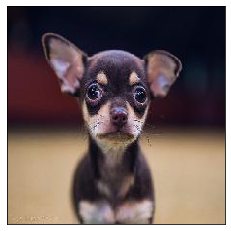

In [0]:
test_image = plt.imread('test_image.jpg')

#Define ImageNet labels of interest
test_label = 151 #Chihuahua
target_label = 427 #Barometer

#Display the image prior to any modification
fig = plt.imshow(test_image)
plt.grid(False)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)


In [0]:
#The predicted label of the network prior to carrying out the attack
pre_label = np.argmax(fmodel.predictions(test_image))
assert(pre_label == test_label)
print("The network has classified the image as a chihuahua")

The network has classified the image as a chihuahua


###Carry Out and Visualize the Results of the Attack

In [0]:
#Carry out the white-box attack
attack = foolbox.attacks.LinfinityBasicIterativeAttack(model=fmodel, criterion=TargetClassProbability(target_label, p=.85))
adversarial_image = attack(test_image, test_label)

W0614 09:04:25.621207 140643228718976 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


In [0]:
#Check the output of the adversarial attack
adversarial_label = np.argmax(fmodel.predictions(adversarial_image[:, :, :]))
#Note a value of 427 corresponds to a 'barometer' in the imagenet dataset
assert(adversarial_label == target_label)
print("The network has classified the image as a barometer")

The network has classified the image as a barometer


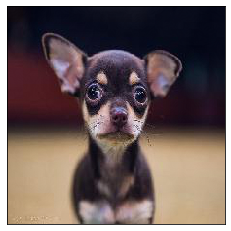

In [0]:
#Visualize the image after adversarial modification
#NB imshow can only accept values in the range of 0:255 if they are integers, hence the they are normalized to 0...1
fig = plt.imshow(adversarial_image/255)
plt.grid(False)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [0]:
#Visualize some of the numerical differences in pixel intensity between the two images
#Note that consistent with the lack of a perceptual difference between the images, all of the values are << 1
print(test_image[0:3, 0:3, 2]/255 - adversarial_image[0:3, 0:3, 2]/255)

[[-0.00377197 -0.00377197 -0.00314331]
 [-0.00377197 -0.00377197 -0.00188598]
 [-0.00377197 -0.00314331  0.00314331]]


##Execute the Boundary Attack on the Madry Network (MNIST data-set)

Reset Session: Unfortunately, due to a conflict between the Madry model and the earlier ResNet model, the following will terminate all Python operations, and must be run unless the ResNet section was skipped.

In [0]:
os.kill(os.getpid(), 9)

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import keras
import foolbox
from foolbox.models import KerasModel
from foolbox.criteria import TargetClassProbability
from foolbox import zoo
from keras.applications.resnet50 import ResNet50

###Load the Madry Model and Necessary Data

In [0]:
cd /content/sample_data

/content/sample_data


In [0]:
#Load the Madry et al model to be attacked
Madry_model = zoo.get_model(url="https://github.com/bethgelab/mnist_challenge")

imported module: <module 'foolbox_model' from '/root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/foolbox_model.py'>


W0618 08:45:25.668931 140145460885376 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:13: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 08:45:25.713391 140145460885376 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:59: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0618 08:45:25.736272 140145460885376 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:73: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 08:45:25.778756 140145460885376 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/foolbox_model.py:18: The name tf.Session is deprecated. Please use tf.compat.v1.Session

In [0]:
#Uncomment the below to use the small (20k examples) MNIST dataset available in Colaboratory

#Madry_testing_import = np.genfromtxt('mnist_test.csv', delimiter=',')

In [0]:
#Import the full MNIST dataset
from keras.datasets import mnist

(_,_), (Madry_testing_data, Madry_testing_labels) = mnist.load_data()

Madry_testing_data = np.reshape(Madry_testing_data, (np.shape(Madry_testing_data)[0], np.shape(Madry_testing_data)[1]*np.shape(Madry_testing_data)[2]))

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#Note the Madry model takes the images in a flattened form, rather than a 2D-reshaped input

#Separate the training and testing images and their labels
#Madry_testing_data = Madry_testing_import[:, 1:]
#Madry_testing_labels = Madry_testing_import[:, 0]

#Rescale images to values between 0:1
Madry_testing_data = Madry_testing_data/255

#Transform the labels into one-hot encoding
num_classes = 10
Madry_testing_labels = np.eye(num_classes)[Madry_testing_labels.astype(int)]

Visualize a typical example from MNIST, and the Madry model's predicted label

5


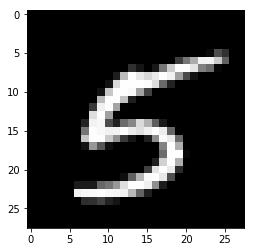

In [0]:
image_iter = 52
test_image_Madry = Madry_testing_data[image_iter, :]
plt.imshow(np.reshape(test_image_Madry, [28, 28, 1])[:,:,0], cmap='gray')
test_label_Madry = np.argmax(Madry_testing_labels[image_iter,:])

print(test_label_Madry)

In [0]:
#The predicted label of the network prior to carrying out the attack
pre_label = np.argmax(Madry_model.predictions(Madry_testing_data[image_iter, :]))
assert(pre_label == test_label_Madry)
print("The predicted label is " + str(pre_label))


The predicted label is 5


###Carry Out and Visualize the Boundary Attack

In [0]:
#Carry out the black-box attack
num_iterations = 100 #Note that the more iterations that are run, the more similar the new image will be to the original
Madry_attack = foolbox.attacks.BoundaryAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry, iterations=num_iterations, log_every_n_steps=50)

run with verbose=True to see details
Step 0: 1.01290e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.01290e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.05039 seconds)
Step 100: 7.15393e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (6.4017e-04) (took 0.04414 seconds)


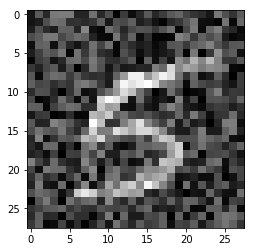

In [0]:
#Visualize the image after adversarial modification
#NB imshow can only accept values in the range of 0:255 if they are integers, hence the they are normalized to 0...1
plt.imshow(np.reshape(Madry_adversarial_image, [28, 28, 1])[:,:,0], cmap='gray')

In [0]:
#The predicted label of the network after the attack
post_label = np.argmax(Madry_model.predictions(Madry_adversarial_image))
print("The predicted label is " + str(post_label))

The predicted label is 0


###Quantify the Vulnerability of the Madry Model to the Boundary Attack

As the Boundary Attack optimizes for the L-2 norm, it is not possible to investigate it's ability to identify new local minima in L-inf norm space. On the other hand, Madry et al report a level of accuracy for l-2 norm resistance, based on PGD (gradient based) adversaries; specifically, they found that an l-2 perturbation of >5 was needed to drop the performance of classification significantly below 85%. I will explore here whether the Boundary Attack can find new local minima such that greater misclassification occurs without using a large l-2 perturbation.

In [0]:
#Function to iterate through a series of images to be attacked
def evaluate_l2_BoundaryAttack_resistance_MadryModel(num_images_to_attack, num_iterations):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, Madry_testing_data.shape[1]])
    
    for ii in range(num_images_to_attack):
        test_image_Madry = Madry_testing_data[ii, :]
        test_label_Madry = np.argmax(Madry_testing_labels[ii,:])

        Madry_attack = foolbox.attacks.BoundaryAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
        Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry, iterations=num_iterations, log_every_n_steps=500)
        adversary_arrays[ii, :] = Madry_adversarial_image
        
        # **** need to check this logical statement for accuracy
        if np.any(np.any(Madry_adversarial_image == None) | (Madry_model.predictions(Madry_adversarial_image) == test_label_Madry)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image_Madry, Madry_adversarial_image)
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance

    return adversary_found, adversary_distance, adversary_arrays


In [0]:
num_images_to_attack = 3
num_iterations = 50
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_MadryModel(num_images_to_attack=num_images_to_attack, num_iterations=num_iterations)


run with verbose=True to see details
Step 0: 8.98849e-02, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 7.9572224875791
run with verbose=True to see details
Step 0: 1.49469e-01, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 9.757871692773481
run with verbose=True to see details
Step 0: 6.99990e-02, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 7.260863424253083


In [0]:
np.savetxt("Madry_adversaries.csv", adversary_arrays, delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [0]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 8.32531920153522


My own results suggest that the boundary attack can achieve 100% misclassification of the Madry model, using a *mean* l-2 epsilon of only 1.406. In their original paper, they reported that an l-2 epislon of >5 was necessary to cause more than 15% misclassification. While my metric differed from that in the paper, and therefore direct comparisons are not possible, this suggests that the Boundary Attack method is indeed capable of finding local minima that escape gradient-based methods. Note this result was based on a sample of 50 images, allowing the BoundaryAttack to perform 1000 iterations for each.

Over the course of this work, I discovered a later pape by Schott et al (Towards the First Adversarially Robust Neural Network Model on MNIST, 2018 Arxiv) which used the same metric as in Madry et al, and found a similar result.

The earlier prediction that the Boundary Attack can identify novel local minima that gradient-based attacks cannot therefore appears confirmed.

#Part 2 - Setting Up Attacks on Custom Models, and Implementation of the Binding Network

##Execute the Boundary Attack on a Standard Convolutional Neural Network

The following demonstrates the use of the Boundary Attack Method against a standard convolutional neural network model trained on MNIST. This work helps to lay-out the steps necessary to apply FoolBox methods to a custom neural network that has been developed in TensorFlow's low-level API. Note this CNN is based on a model I previously developed in TensorFlow, and is based on the architecture of the classic network 'LeNet-5'.

###Data Setup and Preprocessing

In [0]:
#Uncomment the following to use the small (20k examples) MNIST dataset available in Colaboratory

# training_import = np.genfromtxt('mnist_train_small.csv', delimiter=",")
# testing_import = np.genfromtxt('mnist_test.csv', delimiter=',')

#Separate the training and testing images and their labels
# training_data = training_import[:, 1:]
# training_labels = training_import[:, 0]

# testing_data = testing_import[:, 1:]
# testing_labels = testing_import[:, 0]

In [5]:
#Import the full MNIST dataset
#Note the shape of the images required by the custom CNNs is 2D, rather than flattened as for the Madry model

from keras.datasets import mnist

(training_data, training_labels), (testing_data, testing_labels) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#Rescale images to values between 0:1 and reshape so each image is 28x28
training_data = training_data/255
training_data = np.reshape(training_data, [np.shape(training_data)[0], 28, 28, 1])

testing_data = testing_data/255
testing_data = np.reshape(testing_data, [np.shape(testing_data)[0], 28, 28, 1])

In [0]:
#Transform the labels into one-hot encoding
num_classes = 10
training_labels = np.eye(num_classes)[training_labels.astype(int)]

testing_labels = np.eye(num_classes)[testing_labels.astype(int)]

###Model Setup

In [0]:
#Define training parameters
batch_size = 128
training_epochs = 10

In [0]:
#Define a summary variables funciton for later visualisation of the network
def var_summaries(variable):
    with tf.name_scope('Summaries'):
        mean = tf.reduce_mean(variable)
        tf.summary.scalar('Mean', mean) #The tf.summary operation determines which graph node you would like to annotate, and scalar or histogram the type of summary

        with tf.name_scope('STD'):
            std = tf.sqrt(tf.reduce_mean(tf.square(variable - mean)))
            
        tf.summary.scalar('STD', std)
        tf.summary.scalar('Max', tf.reduce_max(variable))
        tf.summary.scalar('Min', tf.reduce_min(variable))
        tf.summary.histogram('Histogram', variable)


In [0]:
#Declare placeholders for the input features and labels
#The first dimension of the palceholder shape is set to None as this will later be defined by the batch size

with tf.name_scope('Input'):
    x = tf.placeholder(training_data.dtype, [None, 28, 28, 1], name='x-input')
    y = tf.placeholder(training_labels.dtype, [None, num_classes], name='y-input')

with tf.name_scope('Drop-Out'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('Dropout_Keep_Probability', keep_prob)

In [11]:
#Define weight and bias variables, and initialize values 
#Note for example that the first convolutional weights layer has a 5x5 filter with 1 input channel, and 6 output channels
#tf.get_variable will either get an existing variable with these parameters, or otherwise create a new one

with tf.name_scope('Weights'):
    weights_LeNet = {
        'conv_W1' : tf.get_variable('CW1', shape=(5, 5, 1, 6), initializer=tf.contrib.layers.xavier_initializer()),
        'conv_W2' : tf.get_variable('CW2', shape=(5, 5, 6, 16), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_W1' : tf.get_variable('DW1', shape=(400, 120), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_W2' : tf.get_variable('DW2', shape=(120, 84), initializer=tf.contrib.layers.xavier_initializer()),
        'output_W' : tf.get_variable('OW', shape=(84, num_classes), initializer=tf.contrib.layers.xavier_initializer())
    }
    
    #Add summaries for each weight variable in the dictionary, for later use in TensorBoard
    for weights_var in weights_LeNet.values():
        var_summaries(weights_var)

with tf.name_scope('Biases'):
    biases_LeNet = {
        'conv_b1' : tf.get_variable('Cb1', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
        'conv_b2' : tf.get_variable('Cb2', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_b1' : tf.get_variable('Db1', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_b2' : tf.get_variable('Db2', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
        'output_b' : tf.get_variable('Ob', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer())
    }

    for biases_var in biases_LeNet.values():
        var_summaries(biases_var)


W0619 08:50:17.274716 140665197692800 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
var_list_LeNet = [weights_LeNet['conv_W1'], weights_LeNet['conv_W2'], weights_LeNet['dense_W1'], weights_LeNet['dense_W2'], 
                  weights_LeNet['output_W'], biases_LeNet['conv_b1'], biases_LeNet['conv_b2'], biases_LeNet['dense_b1'],
                  biases_LeNet['dense_b2'], biases_LeNet['output_b']]

In [0]:
#Define the model

def cnn_predictions(features, temp_batch_size, keep_prob):

    #Note temp_batch_size is not currently used in this particular model, but is 
    #included as an argument to enable arbitrary calling of models later
    
    conv1 = tf.nn.conv2d(input=tf.dtypes.cast(features, dtype=tf.float32), filter=weights_LeNet['conv_W1'], 
                         strides=[1, 1, 1, 1], padding="SAME")
    conv1 = tf.nn.bias_add(conv1, biases_LeNet['conv_b1'])
    conv1_drop = tf.nn.dropout(conv1, keep_prob)
    relu1 = tf.nn.relu(conv1_drop)
    tf.summary.histogram('Relu1_activations', relu1)
    pool1 = tf.nn.max_pool(relu1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool1_drop = tf.nn.dropout(pool1, keep_prob)
    #Note in the tuple defining strides for max_pool, the first entry is always 1 as this refers to the batches/indexed images,
    #rather than the dimensions of a particular image

    conv2 = tf.nn.conv2d(pool1_drop, weights_LeNet['conv_W2'], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases_LeNet['conv_b2'])
    conv2_drop = tf.nn.dropout(conv2, keep_prob)
    relu2 = tf.nn.relu(conv2_drop)
    tf.summary.histogram('Relu2_activations', relu2)
    pool2 = tf.nn.max_pool(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool2_drop = tf.nn.dropout(pool2, keep_prob)
    
    #Flatten Pool 2 before connecting it (fully) with the dense layers 1 and 2
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])
    dense1 = tf.add(tf.matmul(pool2_flat, weights_LeNet['dense_W1']), biases_LeNet['dense_b1'])
    dense1_drop = tf.nn.dropout(dense1, keep_prob)
    dense1 = tf.nn.relu(dense1)
    tf.summary.histogram('Dense1_activations', dense1)
    dense2 = tf.add(tf.matmul(dense1, weights_LeNet['dense_W2']), biases_LeNet['dense_b2'])
    dense2_drop = tf.nn.dropout(dense2, keep_prob)
    dense2 = tf.nn.relu(dense2)
    tf.summary.histogram('Dense2_activations', dense2)

    logits = tf.add(tf.matmul(dense2, weights_LeNet['output_W']), biases_LeNet['output_b'])

    return logits



###Define Training

In [0]:
#Primary training function
def LeNet5_train(var_list, training_data, training_labels, testing_data, testing_labels, learning_rate, temp_batch_size, dropout_keep_prob):
    
    predictions = cnn_predictions(x, temp_batch_size, keep_prob) #NB that x was defined earlier with tf.placeholder
    
    #Define the main Tensors (left hand) and Operations (right hand) that will be used during training
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
    tf.summary.scalar('Softmax_cross_entropy', cost)
    
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('Accuracy', accuracy)

    #Create the chosen optimizer with tf.train.Adam..., then add it to the graph with .minimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Define values to be written with the summary method for later visualization
    loss_summary = tf.summary.scalar(name="Loss_values", tensor=cost)
    accuracy_summary = tf.summary.scalar(name="Accuracy_values", tensor=accuracy)
    
    #Create a Saver object to enable later re-loading of the learned weights
    saver = tf.train.Saver(var_list)
    
    #Merge and provide directory for saving TF summaries
    merged = tf.summary.merge_all()

    #Aside on understanding 'with' and 'tf.Session()'
        #Python's 'with' statement enables the evaluation of tf.Session, while ensuring
        #that the associated __exit__ method (similar to e.g. closing a file) will always 
        #be executed even if an error is raised
        #tf.Session() provides a connection between the Python program and the C++ runtime
        #It also caches information about the tf.Graph to enable efficient re-use of data
        #As tf.Session owns physical resources (such as the GPU), 'with' is particularly important
    with tf.Session() as sess:
        #Initialize variables; note the requirement for explicit initialization prevents expensive
        #initializers from being re-run when e.g. relaoding a model from a checkpoint
        sess.run(tf.global_variables_initializer())
        training_writer = tf.summary.FileWriter('/tmp/log', sess.graph)
        #testing_writer = tf.summary.FileWriter('LeNet/testing')
        
        #Empty arrays for storing performance measures
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []


        for epoch in range(training_epochs):

            for batch in range(int(len(training_labels)/batch_size)):

                batch_x = training_data[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                batch_y = training_labels[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                
                #Recall that tf.Session.run is the main method for running a tf.Operation or evaluation a tf.Tensor
                #By passing or more Tensors or Operations, TensorFlow will execute the operations needed
                run_optim = sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob : dropout_keep_prob})

                loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob : 1.0})
                

            print("At iteration " + str(epoch) + ", Loss = " + \
                 "{:.6f}".format(loss) + ", Training Accuracy = " + \
                                "{:.5f}".format(acc))

            train_acc, _ = sess.run([merged, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
            training_writer.add_summary(train_acc, epoch)
            
            #test_acc, _ = sess.run([merged, accuracy], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
            #testing_writer.add_summary(test_acc, epoch)
            
        print("Training complete")
        
        save_path = saver.save(sess, "/MNIST_LeNet5_CNN.ckpt")
        print("Model saved in MNIST_LeNet5_CNN.ckpt")
        
        test_acc, _ = sess.run([accuracy,cost], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
        
        print("Final testing Accuracy:","{:.5f}".format(test_acc))
        
        training_writer.close()



###Train the Model

In [16]:
LeNet5_train(var_list_LeNet, training_data, training_labels, testing_data, testing_labels, learning_rate=0.001, temp_batch_size=None, dropout_keep_prob=0.5)

W0619 08:50:27.643857 140665197692800 deprecation.py:506] From <ipython-input-14-6e0fc2785a36>:10: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0619 08:50:27.716689 140665197692800 deprecation.py:323] From <ipython-input-15-1d3f2d7afa64>:6: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



At iteration 0, Loss = 0.273432, Training Accuracy = 0.99219
At iteration 1, Loss = 0.181361, Training Accuracy = 1.00000
At iteration 2, Loss = 0.129032, Training Accuracy = 1.00000
At iteration 3, Loss = 0.123673, Training Accuracy = 1.00000
At iteration 4, Loss = 0.093298, Training Accuracy = 1.00000
At iteration 5, Loss = 0.093862, Training Accuracy = 1.00000
At iteration 6, Loss = 0.067921, Training Accuracy = 1.00000
At iteration 7, Loss = 0.060954, Training Accuracy = 1.00000
At iteration 8, Loss = 0.057608, Training Accuracy = 1.00000
At iteration 9, Loss = 0.052307, Training Accuracy = 1.00000
Training complete
Model saved in MNIST_LeNet5_CNN.ckpt
Final testing Accuracy: 0.98360


###Check the Successful Loading of the Model Using tf.train.Saver()

In [0]:
def LeNet5_test(var_list_LeNet, testing_data, testing_labels, temp_batch_size):

    predictions = cnn_predictions(x, temp_batch_size, keep_prob)

    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver(var_list=var_list_LeNet)
    
    with tf.Session() as sess:
        saver.restore(sess, "/MNIST_LeNet5_CNN.ckpt")
        
        test_acc = sess.run([accuracy], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
        
        print("Testing Accuracy:" + str(test_acc))

In [19]:
LeNet5_test(var_list_LeNet, testing_data, testing_labels, temp_batch_size=None)

W0619 08:52:10.019785 140665197692800 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Testing Accuracy:[0.9836]


###Test the Trained Model on Random Examples

In [0]:
def LeNet5_predict(var_list_LeNet, test_image, temp_batch_size):
    
    predictions = cnn_predictions(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list=var_list_LeNet)
    
    with tf.Session() as sess:
        saver.restore(sess, "/MNIST_LeNet5_CNN.ckpt")
        
        num_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        print(num_parameters)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob : 1.0})
                
        return output_predictions

5


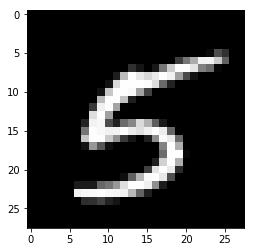

In [21]:
image_iter = 52
test_image_LeNet = testing_data[image_iter, :, :]
plt.imshow(test_image_LeNet[:,:,0], cmap='gray')
test_label_LeNet = np.argmax(testing_labels[image_iter,:])

print(test_label_LeNet)

In [22]:
output_predictions = LeNet5_predict(var_list_LeNet, test_image_LeNet[None, :, :, :], temp_batch_size=None)
print("The predicted value is " + str(np.argmax(output_predictions)))

61706
The predicted value is 5


###Carry Out and Visualize an Attack

In [0]:
#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def Boundary_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, num_iterations, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights) #Note when restoring weights its important not to run init on the same
        #variables, as this will over-write the learned weights with randomly initialized ones

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) 

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label, iterations=num_iterations, log_every_n_steps=50)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

W0619 08:52:19.026724 140665197692800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/foolbox/models/tensorflow.py:45: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 08:52:19.030899 140665197692800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/foolbox/models/tensorflow.py:61: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



run with verbose=True to see details
Step 0: 1.03581e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.68789e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04135 seconds)
Step 100: 6.51512e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 1.33% (8.7745e-04) (took 0.01535 seconds)
Step 150: 4.52148e-02, stepsizes = 2.2e-02/3.0e-03:  (took 0.01158 seconds)
Step 200: 2.98364e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (2.6699e-04) (took 0.00923 seconds)
Step 250: 1.94551e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.89% (1.7409e-04) (took 0.01176 seconds)
Step 300: 1.39104e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (1.2448e-04) (took 0.01105 seconds)
Step 350: 9.74044e-03, stepsizes = 5.1e-02/3.0e-03:  (took 0.01123 seconds)
Step 400: 7.63668e-03, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.59% (4.5456e-05) (took 0.00912 seconds)
Step 450: 6.37877e-03, stepsizes = 5.1e-02/2.0e-03: d. reduced by 0.39% (2.5275e-05) (took 0.00960 seconds)
Step 500: 5.53250e-03, stepsizes = 3.

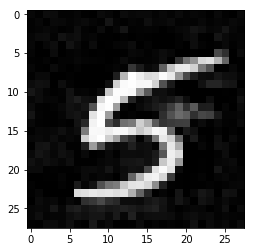

The classification label following attack is 9 from an original classification of 5


In [24]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = Boundary_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                 var_list=var_list_LeNet,
                                                                num_iterations=1000, 
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                keep_prob = 1.0)


In [25]:
print("The prediction following adversarial perturbation is " + str(adversarial_label_fmodel))

The prediction following adversarial perturbation is 9


###Quantify the Vulnerability of the Standard CNN Model to the Boundary Attack

In [0]:
#Iterate through a series of images to be attacked
def evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function, model_weights, var_list, num_images_to_attack, num_iterations, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = Boundary_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list,
                                                                                                     num_iterations, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                    keep_prob = 1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
        
    return adversary_found, adversary_distance, adversary_arrays

run with verbose=True to see details
Step 0: 1.05758e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.04353e-01, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.4054e-03) (took 0.02185 seconds)


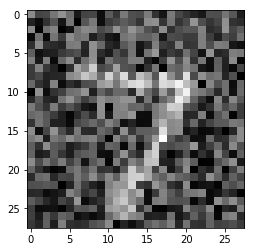

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 9.045035039575618
run with verbose=True to see details
Step 0: 1.04821e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.00697e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04334 seconds)


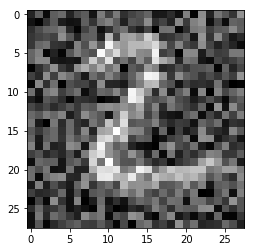

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 8.885163662272943
run with verbose=True to see details
Step 0: 1.25910e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.10144e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04182 seconds)


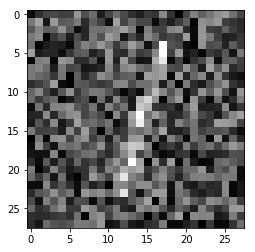

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 9.292561233491995


In [27]:
num_images_to_attack = 3
num_iterations = 50
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function=cnn_predictions,
                                                                                       model_weights="/MNIST_LeNet5_CNN.ckpt",
                                                                                      var_list=var_list_LeNet,
                                                                                       num_images_to_attack=num_images_to_attack, 
                                                                                       num_iterations=num_iterations,
                                                                                      temp_batch_size=None)


In [0]:
np.savetxt("StandardCNN_adversaries.csv", 
           np.reshape(adversary_arrays, [adversary_arrays.shape[0], adversary_arrays.shape[1]*adversary_arrays.shape[2]]), 
                      delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [30]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 9.074253311780184


Assessing the simple CNN model found 100% misclassification of the Bounday Attack, using a *mean* l-2 perturbation of only 1.735; note this is actually a slightly larger distance necesary than that found when attacking the Madry model. This fits with the notion that the Madry method actually displays poor resistance to l-2 attacks from the Boundary Attack, as it has overfit on l-infinity attacks. This result is confirmed in the earlier discussed paper by Schott et al. Note this result was based on a sample of 50 images, allowing the BoundaryAttack to perform 1000 iterations for each.

##Execute the Boundary Attack on a Binding-Capable CNN

###Model Setup

The following demonstrates the use of the Boundary Attack Method against a convolutional neural network model trained on MNIST. This model has been augmented in an attempt to capture 'hierarchical binding information' - essentially how low-level features are driving high level features. Whether this confers resistance to the l-2 based Boundary Attack is then explored. Note that the model, unlike the Madry et al method, receives *no* training on adversarial examples.

In [0]:
#Define weight and bias variables, and initialize values 
weights_Binding = {
    'conv_W1_bind' : tf.get_variable('CW1_bind', shape=(5, 5, 1, 6), initializer=tf.contrib.layers.xavier_initializer()),
    'conv_W2_bind' : tf.get_variable('CW2_bind', shape=(5, 5, 6, 16), initializer=tf.contrib.layers.xavier_initializer()),
    'dense_W1_bind' : tf.get_variable('DW1_bind', shape=(400+1600, 120), initializer=tf.contrib.layers.xavier_initializer()),
    'dense_W2_bind' : tf.get_variable('DW2_bind', shape=(120, 84), initializer=tf.contrib.layers.xavier_initializer()),
    'output_W_bind' : tf.get_variable('OW_bind', shape=(84, num_classes), initializer=tf.contrib.layers.xavier_initializer())
}

biases_Binding = {
    'conv_b1_bind' : tf.get_variable('Cb1_bind', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
    'conv_b2_bind' : tf.get_variable('Cb2_bind', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
    'dense_b1_bind' : tf.get_variable('Db1_bind', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
    'dense_b2_bind' : tf.get_variable('Db2_bind', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
    'output_b_bind' : tf.get_variable('Ob_bind', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer())
}


In [0]:
var_list_Binding = [weights_Binding['conv_W1_bind'], weights_Binding['conv_W2_bind'], weights_Binding['dense_W1_bind'], 
                    weights_Binding['dense_W2_bind'], weights_Binding['output_W_bind'], biases_Binding['conv_b1_bind'], 
                    biases_Binding['conv_b2_bind'], biases_Binding['dense_b1_bind'], biases_Binding['dense_b2_bind'], 
                    biases_Binding['output_b_bind']]

In [0]:
#Declare placeholders for the input features and labels
#The first dimension of the palceholder shape is set to None as this will later be defined by the batch size

x = tf.placeholder(training_data.dtype, [None, 28, 28, 1])
y = tf.placeholder(training_labels.dtype, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
# batch_size_placeholder = tf.placeholder(tf.int32, shape=())

In [0]:
#Define training parameters
batch_size = 128
training_epochs = 3

In [0]:
#Define the convolutional model now with binding information

def cnn_binding_predictions(features, temp_batch_size, keep_prob):

    conv1 = tf.nn.conv2d(input=tf.dtypes.cast(features, dtype=tf.float32), filter=weights_Binding['conv_W1_bind'], 
                         strides=[1, 1, 1, 1], padding="SAME")
    conv1 = tf.nn.bias_add(conv1, biases_Binding['conv_b1_bind'])
    conv1_drop = tf.nn.dropout(conv1, keep_prob)
    relu1 = tf.nn.relu(conv1_drop)
    pool1 = tf.nn.max_pool(relu1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool1_drop = tf.nn.dropout(pool1, keep_prob)
    #Note in the tuple defining strides for max_pool, the first entry is always 1 as this refers to the batches/indexed images,
    #rather than the dimensions of a particular image

    conv2 = tf.nn.conv2d(pool1, weights_Binding['conv_W2_bind'], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases_Binding['conv_b2_bind'])
    conv2_drop = tf.nn.dropout(conv2, keep_prob)
    relu2 = tf.nn.relu(conv2_drop)
    pool2 = tf.nn.max_pool(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool2_drop = tf.nn.dropout(pool2, keep_prob)
    #Flatten Pool 2 before connecting it (fully) with the dense layers 1 and 2
    pool2_flat = tf.reshape(pool2_drop, [-1, 5 * 5 * 16])
    
    
    #Output the indeces of the relu2 nodes that were maximally active (i.e. 'drove' the pool2 nodes), and flatten them
    _, binding_indeces = tf.nn.max_pool_with_argmax(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    binding_indeces_flat = tf.reshape(binding_indeces, [-1, 5 * 5 * 16])
    binding_indeces_flat_cast = tf.dtypes.cast(binding_indeces_flat, dtype=tf.int32)

    #Define update (containing the same number of ones as earlier indices), and shape, which form arguments of scatter_nd
    updates_batch = tf.ones_like(binding_indeces_flat_cast)
    shape = tf.constant([10 * 10 * 16])

    tensor_list = [] #Empty list to hold each row-like tensor, one of which will be formed for each image in the batch
    
    for batch_iter in range(temp_batch_size):

        #Add a dimension to enable use of scatter_nd with the flattened tensor
        indices_temp = tf.expand_dims(binding_indeces_flat_cast[batch_iter], axis=1) 
        
        #In a new tensor of shape 'shape', place a one wherever indicated by 'indices_temp'
        scatter = tf.scatter_nd(indices_temp, updates_batch[batch_iter], shape)

        tensor_list.append(scatter)

    #Stack the scatter tensors for each member of the batch into a single tensor of dimension (batch_size, 'shape')
    binding_mask = tf.stack(tensor_list)
    
    #Recast and flatten tensors as necessary
    binding_mask_cast = tf.dtypes.cast(binding_mask, dtype=tf.float32)
    relu2_flat = tf.reshape(relu2, [-1, 10 * 10 * 16])

    #Apply the boolean information about which lower level nodes were active as a mask to the actual activaiton values
    binding_activations = tf.math.multiply(relu2_flat, binding_mask_cast)
    #binding_activations_drop = tf.nn.dropout(binding_activations, keep_prob)
    
    dense1 = tf.add(tf.matmul(tf.concat([pool2_flat, binding_activations], axis=1), 
                              weights_Binding['dense_W1_bind']), biases_Binding['dense_b1_bind'])
    dense1_drop = tf.nn.dropout(dense1, keep_prob)
    dense1 = tf.nn.relu(dense1_drop)
    dense2 = tf.add(tf.matmul(dense1, weights_Binding['dense_W2_bind']), biases_Binding['dense_b2_bind'])
    dense2_drop = tf.nn.dropout(dense2, keep_prob)
    dense2 = tf.nn.relu(dense2_drop)

    logits = tf.add(tf.matmul(dense2, weights_Binding['output_W_bind']), biases_Binding['output_b_bind'])

    return logits


###Define Training

In [0]:
#Define the training function of the new Binding-CNN
def BindingNet_train(var_list, training_data, training_labels, testing_data, testing_labels, learning_rate, dropout_keep_prob):
    
    predictions = cnn_binding_predictions(x, 128, keep_prob) #NB that x was defined earlier with tf.placeholder
        
    #Define the main Tensors (left hand) and Operations (right hand) that will be used during training
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #Create the chosen optimizer with tf.train.Adam..., then add it to the graph with .minimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Define values to be written with the summary method for later visualization
    loss_summary = tf.summary.scalar(name="Loss_values", tensor=cost)
    accuracy_summary = tf.summary.scalar(name="Accuracy_values", tensor=accuracy)
    
    saver = tf.train.Saver(var_list)
    
    #Carry out training
    with tf.Session() as sess:
        #Initialize the new variables
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            for batch in range(int(len(training_labels)/batch_size)):

                batch_x = training_data[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                batch_y = training_labels[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                

                #Recall that tf.Session.run is the main method for running a tf.Operation or evaluation a tf.Tensor
                #By passing or more Tensors or Operations, TensorFlow will execute the operations needed
                run_optim = sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob : dropout_keep_prob})

                loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob : 1.0})
                

            print("At iteration " + str(epoch) + ", Loss = " + \
                 "{:.6f}".format(loss) + ", Training Accuracy = " + \
                                "{:.5f}".format(acc))

        print("Training complete")
        
        save_path = saver.save(sess, "/Binding_CNN.ckpt")
        print("Model saved in Binding_CNN.ckpt")
        
        test_acc_list = []
        test_loss_list = []
        
        for batch in range(int(len(testing_labels)/batch_size)):

            batch_x = testing_data[batch*batch_size:min((batch+1)*batch_size, len(testing_labels))]
            batch_y = testing_labels[batch*batch_size:min((batch+1)*batch_size, len(testing_labels))]


            test_acc, test_l = sess.run([accuracy,cost], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})

            test_acc_list.append(test_acc)
            test_loss_list.append(test_l)

        return test_acc_list, test_loss_list
        #print("Testing Accuracy:","{:.5f}".format(test_acc))



###Train the Model

In [0]:
test_acc_list, test_loss_list = BindingNet_train(var_list_Binding, training_data, training_labels, 
                                                 testing_data, testing_labels, learning_rate=0.001, dropout_keep_prob=1.0)

At iteration 0, Loss = 0.020063, Training Accuracy = 1.00000
At iteration 1, Loss = 0.010336, Training Accuracy = 1.00000
At iteration 2, Loss = 0.002924, Training Accuracy = 1.00000
Training complete
Model saved in Binding_CNN.ckpt


In [0]:
print("Achieved an accuracy of " + str(np.mean(test_acc_list)))

Achieved an accuracy of 0.97516024


###Carry Out and Visualize an Attack

In [0]:
### *** temporary code to help count the number of parameters

def Binding_predict(var_list, test_image, temp_batch_size):
    
    predictions = cnn_binding_predictions(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list)
    
    with tf.Session() as sess:
        saver.restore(sess, "/Binding_CNN.ckpt")
        
        num_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        print(num_parameters)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob: 1.0})
                
        return output_predictions

In [0]:
Binding_predict(var_list_Binding, test_image_LeNet[None,:,:,:], temp_batch_size=1)

3590046


[array([[-1.7585737, -5.107766 , -5.820657 ,  1.2050401, -4.1996875,
          7.628659 ,  0.443834 , -5.052805 ,  1.5379105,  2.3584645]],
       dtype=float32)]

In [0]:
#Function to try to identify why the Boundary Attack does not stop iteratively decreasing noise into correct classification
# def bug_test_attack(num_iterations, test_image, test_label, target_image, target_label, temp_batch_size):

#     images = x #x is a place-holder for 28x28 images earlier defined
#     logits = cnn_binding_predictions(images, temp_batch_size)

#     saver = tf.train.Saver(var_list_Binding) #Define saver object for use later when loading the model weights

#     #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
#     with tf.Session() as session:
#         saver.restore(session, "/Binding_CNN.ckpt") #Note when restoring weights its important not to run init on the same
#         #variables, as this will over-write the learned weights with randomly initialized ones

#         #Define the foolbox model
#         fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) 

#         #The predicted label of the network prior to carrying out the attack
#         pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
#         #print("The classification label prior to attack is " + str(pre_label))
#         if (pre_label != test_label):
#             print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
#             plt.imshow(test_image[:,:,0], cmap='gray')

#         #Carry out the untargeted Bounary Attack
#         attack_fmodel = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=foolbox.criteria.TargetClass(target_label_LeNet))
#         adversarial_image_fmodel = attack_fmodel(test_image, test_label, iterations=num_iterations, starting_point=target_image_LeNet,
#                                                  log_every_n_steps=50)
#         plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
#         plt.show()
        
#         #Check the output of the adversarial attack
#         adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
#         print("The classification label following attack is " + str(adversarial_label_fmodel) 
#               + " from an original classification of " + str(test_label))
        
#         return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
#To be used if a targeted attack is desired

#Unfortunately the targeted boundary attack appears to have the same odd behaviour

# image_iter = 56
# target_image_LeNet = testing_data[image_iter, :, :]
# plt.imshow(target_image_LeNet[:,:,0], cmap='gray')
# target_label_LeNet = np.argmax(testing_labels[image_iter,:])

# print(target_label_LeNet)

In [0]:
# #An example of the attack
# adversarial_image_fmodel = bug_test_attack(num_iterations=100, 
#                                                                  test_image=test_image_LeNet, 
#                                                                  test_label=test_label_LeNet,
#                                                                 target_image=target_image_LeNet,
#                                                                 target_label=target_label_LeNet,
#                                                                  temp_batch_size=1)


run with verbose=True to see details
Step 0: 1.42273e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.40382e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.05442 seconds)


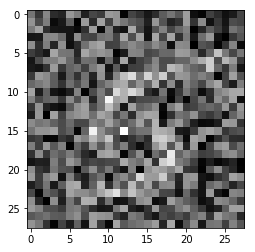

The classification label following attack is 8 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel = Boundary_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                 var_list=var_list_Binding,
                                                                 num_iterations=50, 
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1,
                                                                keep_prob = 1.0)


###Quantify the Vulnerability of the Binding-Capable CNN to the Boundary Attack

run with verbose=True to see details
Step 0: 8.51698e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.34749e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.05081 seconds)
Step 100: 7.55034e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.03884 seconds)
Step 150: 6.15129e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (5.5045e-04) (took 0.01026 seconds)
Step 200: 5.36636e-02, stepsizes = 1.5e-02/3.0e-03: d. reduced by 0.59% (3.1943e-04) (took 0.01249 seconds)
Step 250: 4.94548e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.01000 seconds)
Step 300: 4.94548e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00855 seconds)
Step 350: 4.94548e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00885 seconds)
Step 400: 4.94548e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00858 seconds)
Step 450: 4.94548e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00864 seconds)
Step 500: 4.94548e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00822 seconds)
Step 550: 4.94548e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00839 seconds)
Step 600: 4.9

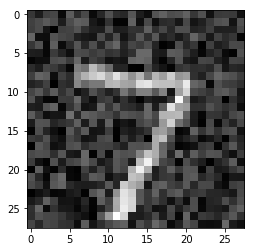

The classification label following attack is 7 from an original classification of 7
No adversarial image found
run with verbose=True to see details
Step 0: 9.96594e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.83351e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.04932 seconds)
Step 100: 9.48926e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.05050 seconds)
Step 150: 8.91558e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00818 seconds)
Step 200: 8.91558e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00837 seconds)
Step 250: 8.91558e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00830 seconds)
Step 300: 8.91558e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00862 seconds)
Step 350: 8.91558e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00836 seconds)
Step 400: 8.91558e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00853 seconds)
Step 450: 8.91558e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00892 seconds)
Step 500: 8.91558e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00845 seconds)
Step 550: 8.91558e-02, stepsizes = 1.7e-04

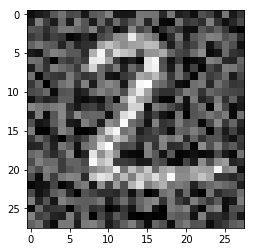

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 8.36050567294074
run with verbose=True to see details
Step 0: 4.75554e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.59896e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04724 seconds)
Step 100: 4.02369e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.05296 seconds)
Step 150: 3.22023e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.01030 seconds)
Step 200: 3.09355e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.00817 seconds)
Step 250: 3.09355e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00852 seconds)
Step 300: 3.09355e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00889 seconds)
Step 350: 3.09355e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00864 seconds)
Step 400: 3.09355e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00836 seconds)
Step 450: 3.09355e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00802 seconds)
Step 500: 3.09355e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00813 seconds)
Step 550: 3.0935

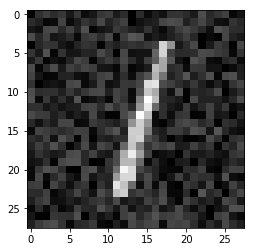

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 8.28825e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.17811e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04459 seconds)
Step 100: 7.82182e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.06410 seconds)
Step 150: 5.93453e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.89% (5.3105e-04) (took 0.01103 seconds)
Step 200: 5.11590e-02, stepsizes = 2.3e-02/3.0e-03:  (took 0.00817 seconds)
Step 250: 4.55667e-02, stepsizes = 2.3e-02/4.4e-03: d. reduced by 0.89% (4.0775e-04) (took 0.01019 seconds)
Step 300: 4.31527e-02, stepsizes = 1.5e-02/2.0e-03:  (took 0.00992 seconds)
Step 350: 4.29824e-02, stepsizes = 1.0e-02/1.3e-03:  (took 0.00846 seconds)
Step 400: 4.29824e-02, stepsizes = 6.7e-03/8.8e-04:  (took 0.00850 seconds)
Step 450: 4.29824e-02, stepsizes = 3.0e-03/3.9e-04:  (took 0.00819 seconds)
Step 500: 4.29824e-02, stepsizes = 2.0e-03/2.6e-04:  (

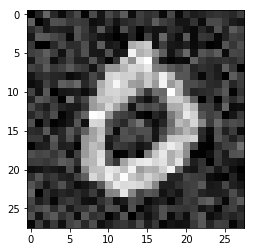

The classification label following attack is 0 from an original classification of 0
No adversarial image found
run with verbose=True to see details
Step 0: 6.22095e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.55135e-02, stepsizes = 1.5e-02/1.0e-02: d. reduced by 1.99% (1.1271e-03) (took 0.02756 seconds)
Step 100: 3.08107e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (4.1495e-04) (took 0.01046 seconds)
Step 150: 2.21530e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (1.9824e-04) (took 0.01045 seconds)
Step 200: 1.52942e-02, stepsizes = 2.3e-02/6.7e-03:  (took 0.00817 seconds)
Step 250: 1.46925e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.00793 seconds)
Step 300: 1.46925e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00808 seconds)
Step 350: 1.46925e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00847 seconds)
Step 400: 1.46925e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00844 seconds)
Step 450: 1.46925e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00819 seconds)
Step 500: 1.46925e-02,

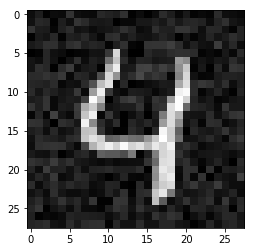

The classification label following attack is 4 from an original classification of 4
No adversarial image found
run with verbose=True to see details
Step 0: 4.35399e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.04472e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04777 seconds)
Step 100: 3.83420e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.03963 seconds)
Step 150: 3.80399e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.01015 seconds)
Step 200: 3.70831e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00874 seconds)
Step 250: 3.67588e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00819 seconds)
Step 300: 3.66729e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01099 seconds)
Step 350: 3.66729e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00817 seconds)
Step 400: 3.66729e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00824 seconds)
Step 450: 3.66729e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00825 seconds)
Step 500: 3.66729e-02, stepsizes = 1.7e-04/5.1e-05:  (took 0.00975 seconds)
Step 550: 3.66729e-02, stepsizes = 7.7e-05

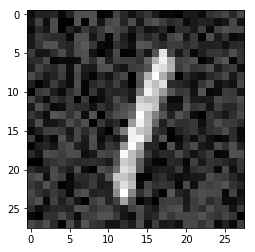

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 3.51584e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.99440e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (4.0328e-04) (took 0.01400 seconds)
Step 100: 2.48326e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.04959 seconds)
Step 150: 1.93514e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 0.59% (1.1519e-04) (took 0.01621 seconds)
Step 200: 1.51574e-02, stepsizes = 3.4e-02/1.0e-02: d. reduced by 2.98% (4.6516e-04) (took 0.01258 seconds)
Step 250: 8.12844e-03, stepsizes = 5.1e-02/1.5e-02: d. reduced by 1.99% (1.6504e-04) (took 0.01121 seconds)
Step 300: 6.57831e-03, stepsizes = 3.4e-02/1.0e-02:  (took 0.00817 seconds)
Step 350: 6.57831e-03, stepsizes = 2.3e-02/6.7e-03:  (took 0.00815 seconds)
Step 400: 6.57831e-03, stepsizes = 1.5e-02/4.4e-03:  (took 0.00867 seconds)
Step 450: 6.57831e-03, stepsizes = 6.7e-03/2.0e-03:  (took 0.00846

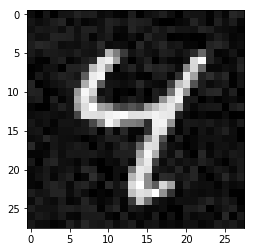

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 2.27087998752534
run with verbose=True to see details
Step 0: 8.13282e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.13282e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04493 seconds)
Step 100: 7.37364e-02, stepsizes = 1.0e-02/4.4e-03: d. reduced by 0.89% (6.5983e-04) (took 0.00612 seconds)
Step 150: 7.24343e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00853 seconds)
Step 200: 7.24343e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00846 seconds)
Step 250: 7.24343e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00810 seconds)
Step 300: 7.24343e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00806 seconds)
Step 350: 7.24343e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00865 seconds)
Step 400: 7.24343e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00835 seconds)
Step 450: 7.24343e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00895 seconds)
Step 500: 7.24343e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0

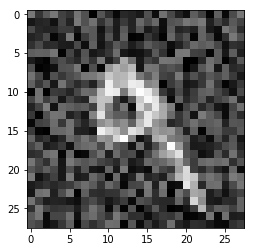

The classification label following attack is 9 from an original classification of 9
No adversarial image found
run with verbose=True to see details
Step 0: 1.49379e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.32416e-01, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.7834e-03) (took 0.02667 seconds)
Step 100: 1.26082e-01, stepsizes = 1.0e-02/4.4e-03:  (took 0.05292 seconds)
Step 150: 1.23856e-01, stepsizes = 6.7e-03/2.0e-03:  (took 0.01569 seconds)
Step 200: 1.23367e-01, stepsizes = 4.4e-03/1.3e-03:  (took 0.00833 seconds)
Step 250: 1.23367e-01, stepsizes = 3.0e-03/8.8e-04:  (took 0.00824 seconds)
Step 300: 1.23367e-01, stepsizes = 1.3e-03/3.9e-04:  (took 0.00844 seconds)
Step 350: 1.23367e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.00848 seconds)
Step 400: 1.23367e-01, stepsizes = 5.9e-04/1.7e-04:  (took 0.00820 seconds)
Step 450: 1.23367e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.00862 seconds)
Step 500: 1.23367e-01, stepsizes = 1.7e-04/5.1e-05:  (took 0.00837 seconds)
Step 550: 

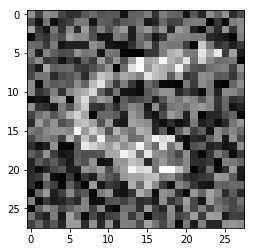

The classification label following attack is 5 from an original classification of 5
No adversarial image found
run with verbose=True to see details
Step 0: 8.26383e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.72915e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (1.0410e-03) (took 0.00579 seconds)
Step 100: 6.21255e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (5.5593e-04) (took 0.00613 seconds)
Step 150: 5.31533e-02, stepsizes = 2.2e-02/6.7e-03:  (took 0.00830 seconds)
Step 200: 5.01605e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.01000 seconds)
Step 250: 5.01605e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00822 seconds)
Step 300: 5.01605e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00861 seconds)
Step 350: 5.01605e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00836 seconds)
Step 400: 5.01605e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00823 seconds)
Step 450: 5.01605e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00852 seconds)
Step 500: 5.01605e-02, stepsizes = 5.9e-04/1.7e-04:  (

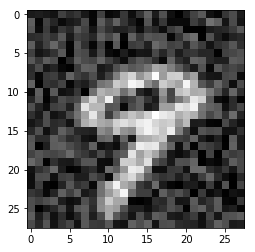

The classification label following attack is 9 from an original classification of 9
No adversarial image found
run with verbose=True to see details
Step 0: 7.63636e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.63636e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05895 seconds)
Step 100: 6.50456e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (5.8206e-04) (took 0.01036 seconds)
Step 150: 5.89738e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00908 seconds)
Step 200: 5.89738e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00911 seconds)
Step 250: 5.89738e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00839 seconds)
Step 300: 5.89738e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00844 seconds)
Step 350: 5.89738e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00855 seconds)
Step 400: 5.89738e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00812 seconds)
Step 450: 5.89738e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00834 seconds)
Step 500: 5.89738e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00860 seconds)
Step 550: 

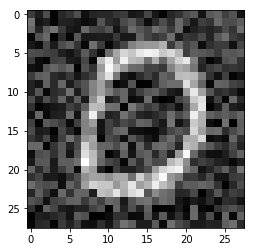

The classification label following attack is 0 from an original classification of 0
No adversarial image found
run with verbose=True to see details
Step 0: 5.30141e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.48459e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05615 seconds)
Step 100: 3.81947e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 1.33% (5.1440e-04) (took 0.02722 seconds)
Step 150: 3.55673e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00797 seconds)
Step 200: 3.55673e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00861 seconds)
Step 250: 3.55673e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00870 seconds)
Step 300: 3.55673e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.01004 seconds)
Step 350: 3.55673e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00833 seconds)
Step 400: 3.55673e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00843 seconds)
Step 450: 3.55673e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00897 seconds)
Step 500: 3.55673e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00866 seconds)
Step 550: 

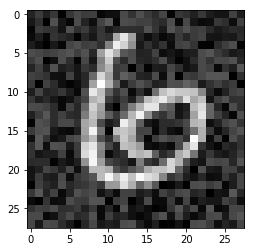

The classification label following attack is 6 from an original classification of 6
No adversarial image found
run with verbose=True to see details
Step 0: 7.09816e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.00384e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04575 seconds)
Step 100: 6.26566e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.05000 seconds)
Step 150: 5.56380e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.00868 seconds)
Step 200: 5.56380e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.00883 seconds)
Step 250: 5.56380e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00819 seconds)
Step 300: 5.56380e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00816 seconds)
Step 350: 5.56380e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00857 seconds)
Step 400: 5.56380e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00841 seconds)
Step 450: 5.56380e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00922 seconds)
Step 500: 5.56380e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00845 seconds)
Step 550: 5.56380e-02, stepsizes = 2.6e-04

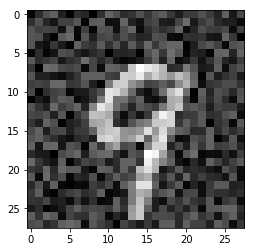

The classification label following attack is 9 from an original classification of 9
No adversarial image found
run with verbose=True to see details
Step 0: 8.30583e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.30583e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.06094 seconds)
Step 100: 7.46283e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 1.33% (1.0051e-03) (took 0.04937 seconds)
Step 150: 5.86733e-02, stepsizes = 2.2e-02/6.7e-03: d. reduced by 0.89% (5.2504e-04) (took 0.01109 seconds)
Step 200: 4.67381e-02, stepsizes = 3.4e-02/6.7e-03:  (took 0.00868 seconds)
Step 250: 4.63235e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.00866 seconds)
Step 300: 4.63235e-02, stepsizes = 1.0e-02/2.0e-03:  (took 0.00839 seconds)
Step 350: 4.63235e-02, stepsizes = 6.7e-03/1.3e-03:  (took 0.00952 seconds)
Step 400: 4.63235e-02, stepsizes = 4.4e-03/8.8e-04:  (took 0.00890 seconds)
Step 450: 4.63235e-02, stepsizes = 2.0e-03/3.9e-04:  (took 0.01032 seconds)
Step 500: 4.63235e-02, stepsizes = 1.3e-03/2.6e-04:  (

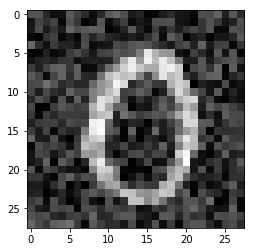

The classification label following attack is 0 from an original classification of 0
No adversarial image found
run with verbose=True to see details
Step 0: 3.53421e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 3.35006e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.05569 seconds)
Step 100: 2.65072e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04358 seconds)
Step 150: 2.59229e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00855 seconds)
Step 200: 2.59229e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00827 seconds)
Step 250: 2.58206e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00823 seconds)
Step 300: 2.58206e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00833 seconds)
Step 350: 2.58206e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00908 seconds)
Step 400: 2.58206e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00822 seconds)
Step 450: 2.58206e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00854 seconds)
Step 500: 2.58206e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00845 seconds)
Step 550: 2.58206e-02, stepsizes = 1.2e-04

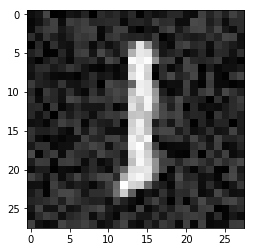

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 1.98207e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.91681e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.04768 seconds)
Step 100: 1.79279e-01, stepsizes = 1.0e-02/4.4e-03:  (took 0.05460 seconds)
Step 150: 1.69952e-01, stepsizes = 6.7e-03/2.0e-03:  (took 0.00858 seconds)
Step 200: 1.69952e-01, stepsizes = 4.4e-03/1.3e-03:  (took 0.00859 seconds)
Step 250: 1.69952e-01, stepsizes = 3.0e-03/8.8e-04:  (took 0.00842 seconds)
Step 300: 1.69952e-01, stepsizes = 2.0e-03/5.9e-04:  (took 0.00815 seconds)
Step 350: 1.69952e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.00865 seconds)
Step 400: 1.69952e-01, stepsizes = 5.9e-04/1.7e-04:  (took 0.00818 seconds)
Step 450: 1.69952e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.00834 seconds)
Step 500: 1.69952e-01, stepsizes = 2.6e-04/7.7e-05:  (took 0.00832 seconds)
Step 550: 1.69952e-01, stepsizes = 1.2e-04

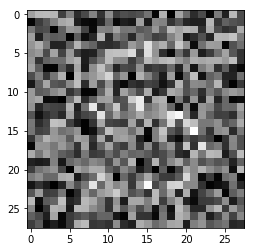

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 11.54304796856071
run with verbose=True to see details
Step 0: 1.16773e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.30007e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04391 seconds)
Step 100: 8.93422e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.05992 seconds)
Step 150: 8.67305e-02, stepsizes = 4.4e-03/2.0e-03: d. reduced by 0.39% (3.4366e-04) (took 0.01031 seconds)
Step 200: 8.63882e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00815 seconds)
Step 250: 8.63882e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00907 seconds)
Step 300: 8.63882e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00833 seconds)
Step 350: 8.63882e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00802 seconds)
Step 400: 8.63882e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00875 seconds)
Step 450: 8.63882e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0.00862 seconds)
Step 500: 8.63882e-02, stepsizes = 1.2e-04/5.1e-05:  (took 

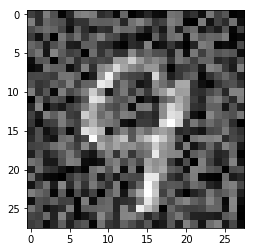

The classification label following attack is 9 from an original classification of 9
No adversarial image found
run with verbose=True to see details
Step 0: 9.96445e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.70137e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05420 seconds)
Step 100: 7.72909e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (6.9164e-04) (took 0.02448 seconds)
Step 150: 6.88385e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.01027 seconds)
Step 200: 6.48720e-02, stepsizes = 1.0e-02/2.0e-03:  (took 0.00849 seconds)
Step 250: 6.48720e-02, stepsizes = 4.4e-03/8.8e-04:  (took 0.00837 seconds)
Step 300: 6.48720e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.00854 seconds)
Step 350: 6.48720e-02, stepsizes = 2.0e-03/3.9e-04:  (took 0.00849 seconds)
Step 400: 6.48720e-02, stepsizes = 1.3e-03/2.6e-04:  (took 0.00816 seconds)
Step 450: 6.48720e-02, stepsizes = 5.9e-04/1.2e-04:  (took 0.00846 seconds)
Step 500: 6.48720e-02, stepsizes = 3.9e-04/7.7e-05:  (took 0.00832 seconds)
Step 550: 

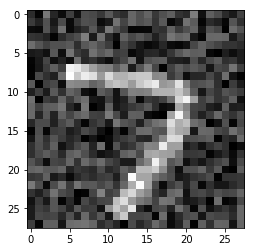

The classification label following attack is 7 from an original classification of 7
No adversarial image found
The model predicted a 8 when the ground-truth label is 3


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


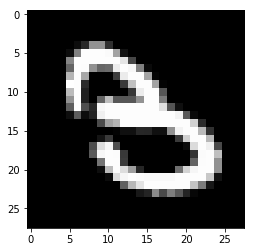

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 0.0
run with verbose=True to see details
Step 0: 8.02234e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.40357e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05510 seconds)
Step 100: 5.49252e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (4.9150e-04) (took 0.03567 seconds)
Step 150: 5.39552e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00846 seconds)
Step 200: 5.39552e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00844 seconds)
Step 250: 5.39552e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00837 seconds)
Step 300: 5.39552e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00819 seconds)
Step 350: 5.39552e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00813 seconds)
Step 400: 5.39552e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00857 seconds)
Step 450: 5.39552e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00807 seconds)
Step 500: 5.39552e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00817 second

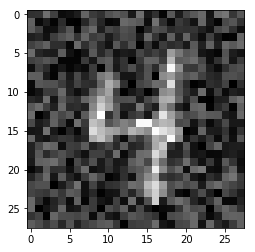

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 6.503905084786922
run with verbose=True to see details
Step 0: 7.54376e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.29538e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04184 seconds)
Step 100: 7.29538e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.04367 seconds)
Step 150: 7.20929e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00817 seconds)
Step 200: 7.20929e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00891 seconds)
Step 250: 7.20929e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00824 seconds)
Step 300: 7.20929e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00907 seconds)
Step 350: 7.20929e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00829 seconds)
Step 400: 7.20929e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00844 seconds)
Step 450: 7.20929e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00872 seconds)
Step 500: 7.20929e-02, stepsizes = 1.2e-04/5.1e-05:  (took 0.00842 seconds)
Step 550: 7.209

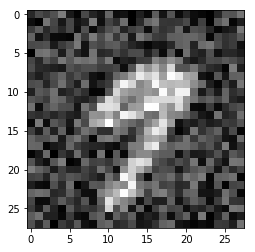

The classification label following attack is 9 from an original classification of 9
No adversarial image found
run with verbose=True to see details
Step 0: 5.11387e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.04591e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04767 seconds)
Step 100: 4.24094e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (3.7950e-04) (took 0.02608 seconds)
Step 150: 4.20332e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00794 seconds)
Step 200: 4.20332e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00789 seconds)
Step 250: 4.20332e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00882 seconds)
Step 300: 4.20332e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00815 seconds)
Step 350: 4.20332e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00819 seconds)
Step 400: 4.20332e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00833 seconds)
Step 450: 4.20332e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00841 seconds)
Step 500: 4.20332e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00809 seconds)
Step 550: 

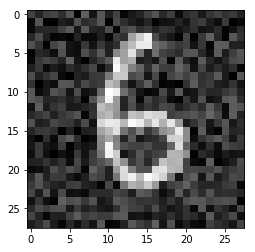

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 5.740556680138127
run with verbose=True to see details
Step 0: 5.98100e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.66936e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05883 seconds)
Step 100: 5.00443e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.05239 seconds)
Step 150: 4.56470e-02, stepsizes = 1.0e-02/2.0e-03: d. reduced by 0.39% (1.8087e-04) (took 0.01044 seconds)
Step 200: 4.45764e-02, stepsizes = 1.0e-02/2.0e-03:  (took 0.00849 seconds)
Step 250: 4.45764e-02, stepsizes = 6.7e-03/1.3e-03:  (took 0.00834 seconds)
Step 300: 4.45764e-02, stepsizes = 4.4e-03/8.8e-04:  (took 0.00810 seconds)
Step 350: 4.45764e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.00841 seconds)
Step 400: 4.45764e-02, stepsizes = 1.3e-03/2.6e-04:  (took 0.00833 seconds)
Step 450: 4.45764e-02, stepsizes = 8.8e-04/1.7e-04:  (took 0.00834 seconds)
Step 500: 4.45764e-02, stepsizes = 5.9e-04/1.2e-04:  (took 

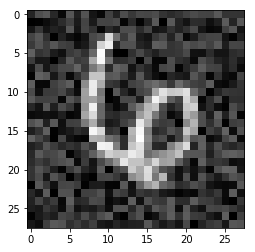

The classification label following attack is 6 from an original classification of 6
No adversarial image found
run with verbose=True to see details
Step 0: 1.46819e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.42943e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.05124 seconds)
Step 100: 1.09396e-01, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (9.7893e-04) (took 0.00317 seconds)
Step 150: 9.67676e-02, stepsizes = 2.2e-02/1.0e-02:  (took 0.00972 seconds)
Step 200: 8.69461e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.01007 seconds)
Step 250: 7.45129e-02, stepsizes = 1.5e-02/2.0e-03: d. reduced by 0.59% (4.4353e-04) (took 0.00994 seconds)
Step 300: 6.36961e-02, stepsizes = 1.5e-02/1.3e-03: d. reduced by 0.26% (1.6809e-04) (took 0.01129 seconds)
Step 350: 5.55700e-02, stepsizes = 2.2e-02/3.0e-03: d. reduced by 0.59% (3.3077e-04) (took 0.00994 seconds)
Step 400: 4.46153e-02, stepsizes = 3.4e-02/3.0e-03: d. reduced by 0.59% (2.6557e-04) (took 0.01049 seconds)
Step 450: 3.73354e-02, stepsizes =

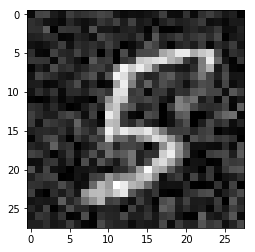

The classification label following attack is 5 from an original classification of 5
No adversarial image found
run with verbose=True to see details
Step 0: 3.09586e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.25988e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05312 seconds)
Step 100: 1.85756e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.05234 seconds)
Step 150: 1.82475e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00848 seconds)
Step 200: 1.82475e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00808 seconds)
Step 250: 1.82475e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00823 seconds)
Step 300: 1.82475e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00833 seconds)
Step 350: 1.82475e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00940 seconds)
Step 400: 1.82475e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00802 seconds)
Step 450: 1.82475e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00812 seconds)
Step 500: 1.82475e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0.00819 seconds)
Step 550: 1.82475e-02, stepsizes = 7.7e-05

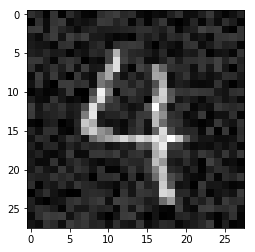

The classification label following attack is 4 from an original classification of 4
No adversarial image found
run with verbose=True to see details
Step 0: 6.18075e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.01757e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04465 seconds)
Step 100: 5.31181e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.04952 seconds)
Step 150: 4.99090e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00804 seconds)
Step 200: 4.99090e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00844 seconds)
Step 250: 4.99090e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00867 seconds)
Step 300: 4.99090e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00803 seconds)
Step 350: 4.99090e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00850 seconds)
Step 400: 4.99090e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00858 seconds)
Step 450: 4.99090e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00812 seconds)
Step 500: 4.99090e-02, stepsizes = 1.7e-04/5.1e-05:  (took 0.00821 seconds)
Step 550: 4.99090e-02, stepsizes = 1.2e-04

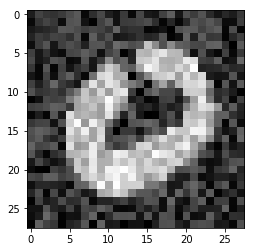

The classification label following attack is 0 from an original classification of 0
No adversarial image found
run with verbose=True to see details
Step 0: 9.67199e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.01248e-02, stepsizes = 1.5e-02/1.0e-02: d. reduced by 1.33% (9.4443e-04) (took 0.03534 seconds)
Step 100: 6.07976e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.04586 seconds)
Step 150: 5.86692e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00988 seconds)
Step 200: 5.86692e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00803 seconds)
Step 250: 5.86692e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.01010 seconds)
Step 300: 5.86692e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00803 seconds)
Step 350: 5.86692e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.01144 seconds)
Step 400: 5.86692e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00847 seconds)
Step 450: 5.86692e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00828 seconds)
Step 500: 5.86692e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00848 seconds)
Step 550: 

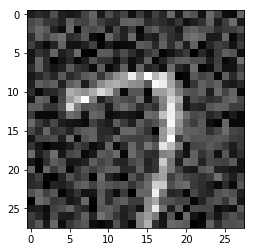

The classification label following attack is 7 from an original classification of 7
No adversarial image found
run with verbose=True to see details
Step 0: 5.51771e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.30029e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.04467 seconds)
Step 100: 5.11474e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.05286 seconds)
Step 150: 5.03938e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00825 seconds)
Step 200: 5.03938e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00809 seconds)
Step 250: 5.03938e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00818 seconds)
Step 300: 5.03938e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00849 seconds)
Step 350: 5.03938e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00815 seconds)
Step 400: 5.03938e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00823 seconds)
Step 450: 5.03938e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00806 seconds)
Step 500: 5.03938e-02, stepsizes = 1.2e-04/5.1e-05:  (took 0.00835 seconds)
Step 550: 5.03938e-02, stepsizes = 7.7e-05

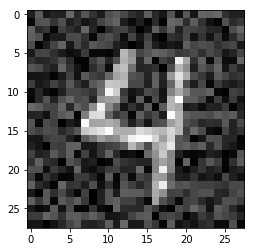

The classification label following attack is 4 from an original classification of 4
No adversarial image found
run with verbose=True to see details
Step 0: 8.88412e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.53405e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04733 seconds)
Step 100: 7.14041e-02, stepsizes = 1.0e-02/4.4e-03: d. reduced by 0.89% (6.3896e-04) (took 0.04005 seconds)
Step 150: 5.76573e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.01034 seconds)
Step 200: 4.68374e-02, stepsizes = 2.2e-02/4.4e-03: d. reduced by 0.89% (4.1912e-04) (took 0.01053 seconds)
Step 250: 4.40058e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.00820 seconds)
Step 300: 4.37454e-02, stepsizes = 1.0e-02/2.0e-03:  (took 0.00844 seconds)
Step 350: 4.37454e-02, stepsizes = 6.7e-03/1.3e-03:  (took 0.00837 seconds)
Step 400: 4.37454e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.00834 seconds)
Step 450: 4.37454e-02, stepsizes = 2.0e-03/3.9e-04:  (took 0.00806 seconds)
Step 500: 4.37454e-02, stepsizes = 1.3e-03/2.6e-04:  (

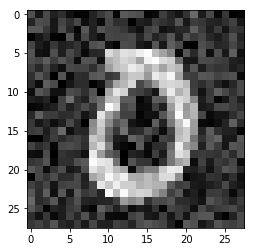

The classification label following attack is 0 from an original classification of 0
No adversarial image found
run with verbose=True to see details
Step 0: 4.80119e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.43057e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05269 seconds)
Step 100: 3.98088e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04596 seconds)
Step 150: 3.92797e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00901 seconds)
Step 200: 3.92797e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00869 seconds)
Step 250: 3.92797e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00930 seconds)
Step 300: 3.92797e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00826 seconds)
Step 350: 3.92797e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00918 seconds)
Step 400: 3.92797e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00829 seconds)
Step 450: 3.92797e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00820 seconds)
Step 500: 3.92797e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00833 seconds)
Step 550: 3.92797e-02, stepsizes = 1.2e-04

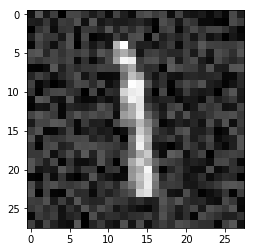

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 1.73565e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.39153e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.04640 seconds)
Step 100: 1.35480e-01, stepsizes = 6.7e-03/4.4e-03:  (took 0.04146 seconds)
Step 150: 1.31907e-01, stepsizes = 4.4e-03/3.0e-03:  (took 0.00857 seconds)
Step 200: 1.31907e-01, stepsizes = 3.0e-03/2.0e-03:  (took 0.00830 seconds)
Step 250: 1.31907e-01, stepsizes = 1.3e-03/8.8e-04:  (took 0.00821 seconds)
Step 300: 1.31907e-01, stepsizes = 8.8e-04/5.9e-04:  (took 0.00832 seconds)
Step 350: 1.31907e-01, stepsizes = 5.9e-04/3.9e-04:  (took 0.00828 seconds)
Step 400: 1.31907e-01, stepsizes = 3.9e-04/2.6e-04:  (took 0.00820 seconds)
Step 450: 1.31907e-01, stepsizes = 1.7e-04/1.2e-04:  (took 0.00848 seconds)
Step 500: 1.31907e-01, stepsizes = 1.2e-04/7.7e-05:  (took 0.00863 seconds)
Step 550: 1.31907e-01, stepsizes = 7.7e-05

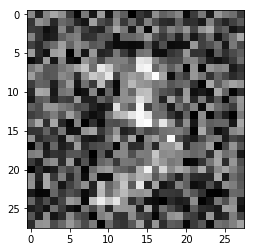

The classification label following attack is 3 from an original classification of 3
No adversarial image found
run with verbose=True to see details
Step 0: 3.11164e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 3.04972e-02, stepsizes = 1.0e-02/1.0e-02:  (took 0.04389 seconds)
Step 100: 2.85240e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04424 seconds)
Step 150: 2.77709e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00823 seconds)
Step 200: 2.77709e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00807 seconds)
Step 250: 2.77709e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00861 seconds)
Step 300: 2.77709e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00826 seconds)
Step 350: 2.77709e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00823 seconds)
Step 400: 2.77709e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00836 seconds)
Step 450: 2.77709e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00821 seconds)
Step 500: 2.77709e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0.00875 seconds)
Step 550: 2.77709e-02, stepsizes = 1.2e-04

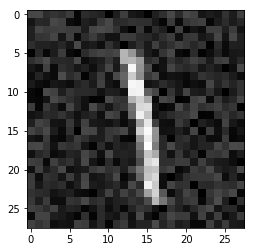

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 2.44578e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.08304e-01, stepsizes = 1.5e-02/6.7e-03:  (took 0.05194 seconds)
Step 100: 1.87162e-01, stepsizes = 1.0e-02/4.4e-03:  (took 0.03987 seconds)
Step 150: 1.83856e-01, stepsizes = 6.7e-03/3.0e-03:  (took 0.00832 seconds)
Step 200: 1.83856e-01, stepsizes = 4.4e-03/2.0e-03:  (took 0.00817 seconds)
Step 250: 1.83856e-01, stepsizes = 2.0e-03/8.8e-04:  (took 0.01184 seconds)
Step 300: 1.83856e-01, stepsizes = 1.3e-03/5.9e-04:  (took 0.00783 seconds)
Step 350: 1.83856e-01, stepsizes = 8.8e-04/3.9e-04:  (took 0.00782 seconds)
Step 400: 1.83856e-01, stepsizes = 5.9e-04/2.6e-04:  (took 0.00798 seconds)
Step 450: 1.83856e-01, stepsizes = 2.6e-04/1.2e-04:  (took 0.00859 seconds)
Step 500: 1.83856e-01, stepsizes = 1.7e-04/7.7e-05:  (took 0.00821 seconds)
Step 550: 1.83856e-01, stepsizes = 1.2e-04

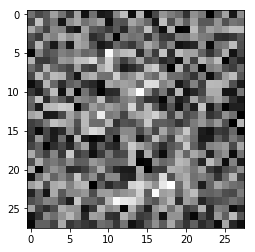

The classification label following attack is 3 from an original classification of 3
No adversarial image found
run with verbose=True to see details
Step 0: 2.62151e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.11637e-02, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (2.8503e-04) (took 0.00868 seconds)
Step 100: 1.54903e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (1.3862e-04) (took 0.00347 seconds)
Step 150: 1.24509e-02, stepsizes = 2.2e-02/1.0e-02: d. reduced by 1.33% (1.6769e-04) (took 0.01065 seconds)
Step 200: 8.00106e-03, stepsizes = 2.2e-02/1.0e-02:  (took 0.00789 seconds)
Step 250: 6.37135e-03, stepsizes = 1.5e-02/1.0e-02:  (took 0.00850 seconds)
Step 300: 6.28668e-03, stepsizes = 6.7e-03/4.4e-03:  (took 0.00853 seconds)
Step 350: 6.28668e-03, stepsizes = 4.4e-03/2.0e-03:  (took 0.00810 seconds)
Step 400: 6.28668e-03, stepsizes = 3.0e-03/1.3e-03:  (took 0.00818 seconds)
Step 450: 6.28668e-03, stepsizes = 2.0e-03/8.8e-04:  (took 0.00808 seconds)
Step 500: 6.28668e-03,

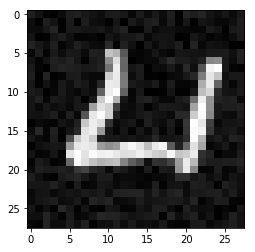

The classification label following attack is 4 from an original classification of 4
No adversarial image found
run with verbose=True to see details
Step 0: 1.10491e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.79441e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04879 seconds)
Step 100: 9.28434e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.03986 seconds)
Step 150: 9.03947e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00894 seconds)
Step 200: 9.03947e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00786 seconds)
Step 250: 9.03947e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00851 seconds)
Step 300: 9.03947e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00833 seconds)
Step 350: 9.03947e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00813 seconds)
Step 400: 9.03947e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00800 seconds)
Step 450: 9.03947e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00823 seconds)
Step 500: 9.03947e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0.00846 seconds)
Step 550: 9.03947e-02, stepsizes = 7.7e-05

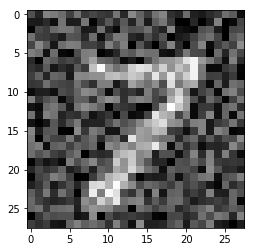

The classification label following attack is 7 from an original classification of 7
No adversarial image found
run with verbose=True to see details
Step 0: 9.31789e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 8.95134e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.06328 seconds)
Step 100: 7.29182e-02, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (6.5251e-04) (took 0.00943 seconds)
Step 150: 6.99492e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00904 seconds)
Step 200: 6.99492e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00857 seconds)
Step 250: 6.99492e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00842 seconds)
Step 300: 6.99492e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00862 seconds)
Step 350: 6.99492e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00826 seconds)
Step 400: 6.99492e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00903 seconds)
Step 450: 6.99492e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00899 seconds)
Step 500: 6.99492e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00845 seconds)
Step 550: 

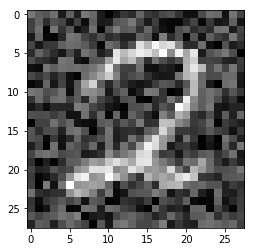

The classification label following attack is 2 from an original classification of 2
No adversarial image found
run with verbose=True to see details
Step 0: 5.01525e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.02146e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05099 seconds)
Step 100: 2.99642e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.05725 seconds)
Step 150: 2.89153e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00828 seconds)
Step 200: 2.89153e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00808 seconds)
Step 250: 2.89153e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00796 seconds)
Step 300: 2.89153e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00851 seconds)
Step 350: 2.89153e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00845 seconds)
Step 400: 2.89153e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00828 seconds)
Step 450: 2.89153e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00813 seconds)
Step 500: 2.89153e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0.00825 seconds)
Step 550: 2.89153e-02, stepsizes = 1.2e-04

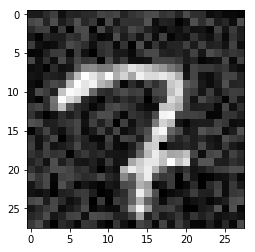

The classification label following attack is 7 from an original classification of 7
No adversarial image found
run with verbose=True to see details
Step 0: 5.78502e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.78502e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.04818 seconds)
Step 100: 5.26787e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04456 seconds)
Step 150: 5.19785e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00834 seconds)
Step 200: 5.03598e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00843 seconds)
Step 250: 4.95262e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00895 seconds)
Step 300: 4.95262e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00813 seconds)
Step 350: 4.95262e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00842 seconds)
Step 400: 4.95262e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00854 seconds)
Step 450: 4.95262e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00843 seconds)
Step 500: 4.95262e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00811 seconds)
Step 550: 4.95262e-02, stepsizes = 1.7e-04

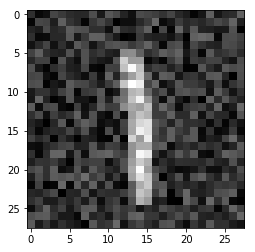

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 6.45476e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 5.49633e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05306 seconds)
Step 100: 4.74420e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04697 seconds)
Step 150: 4.61894e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.00836 seconds)
Step 200: 4.61894e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00838 seconds)
Step 250: 4.61894e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00814 seconds)
Step 300: 4.61894e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00822 seconds)
Step 350: 4.61894e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00814 seconds)
Step 400: 4.61894e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00831 seconds)
Step 450: 4.61894e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00870 seconds)
Step 500: 4.61894e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00849 seconds)
Step 550: 4.61894e-02, stepsizes = 1.7e-04

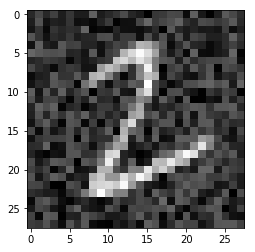

The classification label following attack is 2 from an original classification of 2
No adversarial image found
run with verbose=True to see details
Step 0: 1.62133e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.55745e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04944 seconds)
Step 100: 1.33857e-02, stepsizes = 1.0e-02/3.0e-03: d. reduced by 0.89% (1.1978e-04) (took 0.03685 seconds)
Step 150: 1.21731e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00841 seconds)
Step 200: 1.04013e-02, stepsizes = 1.5e-02/3.0e-03:  (took 0.01178 seconds)
Step 250: 8.58556e-03, stepsizes = 1.5e-02/3.0e-03: d. reduced by 0.59% (5.1104e-05) (took 0.01052 seconds)
Step 300: 7.45555e-03, stepsizes = 1.5e-02/4.4e-03:  (took 0.00846 seconds)
Step 350: 7.45555e-03, stepsizes = 1.0e-02/3.0e-03:  (took 0.00839 seconds)
Step 400: 7.45555e-03, stepsizes = 6.7e-03/2.0e-03:  (took 0.00834 seconds)
Step 450: 7.45555e-03, stepsizes = 4.4e-03/1.3e-03:  (took 0.00815 seconds)
Step 500: 7.45555e-03, stepsizes = 2.0e-03/5.9e-04:  (

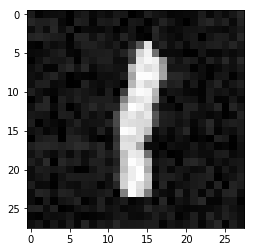

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 1.98416e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.94468e-02, stepsizes = 6.7e-03/6.7e-03:  (took 0.04700 seconds)
Step 100: 1.89339e-02, stepsizes = 6.7e-03/4.4e-03:  (took 0.05034 seconds)
Step 150: 1.87660e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00986 seconds)
Step 200: 1.67108e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00823 seconds)
Step 250: 1.66448e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00855 seconds)
Step 300: 1.66448e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00873 seconds)
Step 350: 1.66448e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00804 seconds)
Step 400: 1.66448e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00866 seconds)
Step 450: 1.66448e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00827 seconds)
Step 500: 1.66448e-02, stepsizes = 2.6e-04/7.7e-05:  (took 0.00852 seconds)
Step 550: 1.66448e-02, stepsizes = 1.7e-04

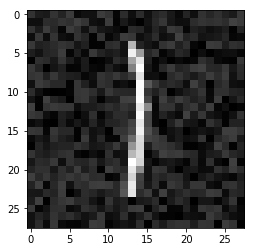

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 7.59649e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.29765e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.05069 seconds)
Step 100: 6.88676e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.04455 seconds)
Step 150: 6.55455e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.01014 seconds)
Step 200: 6.16080e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00824 seconds)
Step 250: 6.12434e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00847 seconds)
Step 300: 6.12434e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.00819 seconds)
Step 350: 6.12434e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00816 seconds)
Step 400: 6.12434e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00825 seconds)
Step 450: 6.12434e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00821 seconds)
Step 500: 6.12434e-02, stepsizes = 3.9e-04/1.2e-04:  (took 0.00876 seconds)
Step 550: 6.12434e-02, stepsizes = 2.6e-04

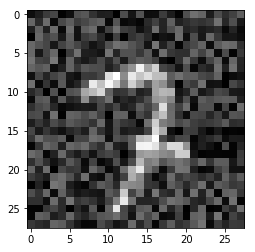

The classification label following attack is 7 from an original classification of 7
No adversarial image found
run with verbose=True to see details
Step 0: 7.34517e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 7.15125e-02, stepsizes = 1.0e-02/6.7e-03:  (took 0.04678 seconds)
Step 100: 5.85208e-02, stepsizes = 1.0e-02/4.4e-03: d. reduced by 0.89% (5.2367e-04) (took 0.01536 seconds)
Step 150: 4.98556e-02, stepsizes = 1.0e-02/3.0e-03: d. reduced by 0.59% (2.9676e-04) (took 0.01043 seconds)
Step 200: 4.06656e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00823 seconds)
Step 250: 4.05051e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00859 seconds)
Step 300: 4.03985e-02, stepsizes = 3.0e-03/8.8e-04:  (took 0.01284 seconds)
Step 350: 4.03985e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00818 seconds)
Step 400: 4.03985e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00851 seconds)
Step 450: 4.03985e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.00857 seconds)
Step 500: 4.03985e-02, stepsizes = 3.9e-04/1.2e-04:  (

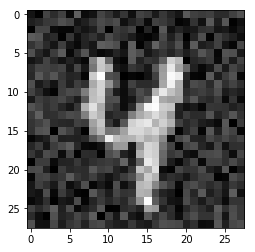

The classification label following attack is 4 from an original classification of 4
No adversarial image found
run with verbose=True to see details
Step 0: 1.31014e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.02252e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.05507 seconds)
Step 100: 8.67113e-02, stepsizes = 1.0e-02/4.4e-03: d. reduced by 0.89% (7.7594e-04) (took 0.03116 seconds)
Step 150: 8.41749e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00857 seconds)
Step 200: 8.41749e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00841 seconds)
Step 250: 8.41749e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00814 seconds)
Step 300: 8.41749e-02, stepsizes = 1.3e-03/5.9e-04:  (took 0.00829 seconds)
Step 350: 8.41749e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00823 seconds)
Step 400: 8.41749e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00876 seconds)
Step 450: 8.41749e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00856 seconds)
Step 500: 8.41749e-02, stepsizes = 1.7e-04/7.7e-05:  (took 0.00830 seconds)
Step 550: 

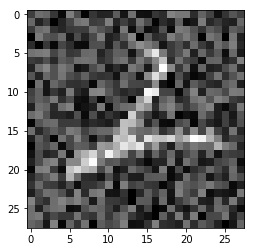

The classification label following attack is 2 from an original classification of 2
No adversarial image found
run with verbose=True to see details
Step 0: 1.44924e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.42040e-01, stepsizes = 1.0e-02/1.0e-02:  (took 0.04563 seconds)
Step 100: 1.28773e-01, stepsizes = 1.0e-02/4.4e-03:  (took 0.04718 seconds)
Step 150: 1.26125e-01, stepsizes = 6.7e-03/3.0e-03:  (took 0.00819 seconds)
Step 200: 1.23900e-01, stepsizes = 3.0e-03/1.3e-03:  (took 0.00870 seconds)
Step 250: 1.23357e-01, stepsizes = 2.0e-03/5.9e-04:  (took 0.00812 seconds)
Step 300: 1.23357e-01, stepsizes = 1.3e-03/3.9e-04:  (took 0.00809 seconds)
Step 350: 1.23357e-01, stepsizes = 8.8e-04/2.6e-04:  (took 0.00840 seconds)
Step 400: 1.23357e-01, stepsizes = 3.9e-04/1.2e-04:  (took 0.00950 seconds)
Step 450: 1.23357e-01, stepsizes = 2.6e-04/7.7e-05:  (took 0.00860 seconds)
Step 500: 1.23357e-01, stepsizes = 1.7e-04/5.1e-05:  (took 0.00833 seconds)
Step 550: 1.23357e-01, stepsizes = 1.2e-04

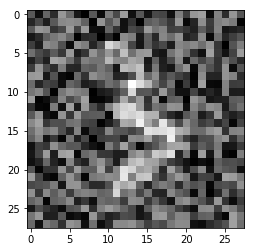

The classification label following attack is 3 from an original classification of 3
No adversarial image found
run with verbose=True to see details
Step 0: 1.57262e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.35732e-01, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (1.8280e-03) (took 0.00588 seconds)
Step 100: 1.03869e-01, stepsizes = 1.5e-02/6.7e-03: d. reduced by 1.33% (1.3989e-03) (took 0.00895 seconds)
Step 150: 8.31228e-02, stepsizes = 2.2e-02/1.0e-02: d. reduced by 0.89% (7.4382e-04) (took 0.01108 seconds)
Step 200: 6.53077e-02, stepsizes = 2.2e-02/6.7e-03:  (took 0.01031 seconds)
Step 250: 2.08001e-02, stepsizes = 3.4e-02/1.5e-02: d. reduced by 2.98% (6.3833e-04) (took 0.01365 seconds)
Step 300: 7.42211e-03, stepsizes = 5.1e-02/2.2e-02: d. reduced by 4.45% (3.4562e-04) (took 0.01054 seconds)
Step 350: 5.45772e-03, stepsizes = 3.4e-02/1.0e-02:  (took 0.00824 seconds)
Step 400: 5.45772e-03, stepsizes = 2.3e-02/6.7e-03:  (took 0.00787 seconds)
Step 450: 5.45772e-03, stepsizes =

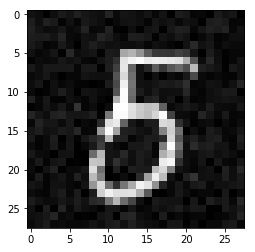

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 2.0685195764699156
run with verbose=True to see details
Step 0: 2.42440e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.26738e-02, stepsizes = 1.5e-02/1.0e-02:  (took 0.05239 seconds)
Step 100: 2.02360e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04150 seconds)
Step 150: 1.99671e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00883 seconds)
Step 200: 1.99671e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00837 seconds)
Step 250: 1.99671e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00847 seconds)
Step 300: 1.99671e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00804 seconds)
Step 350: 1.99671e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00869 seconds)
Step 400: 1.99671e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00804 seconds)
Step 450: 1.99671e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00812 seconds)
Step 500: 1.99671e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00806 seconds)
Step 550: 1.99

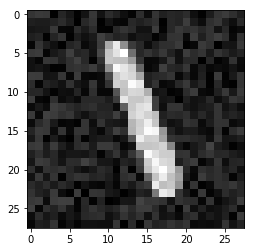

The classification label following attack is 1 from an original classification of 1
No adversarial image found
run with verbose=True to see details
Step 0: 4.19730e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 4.14152e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05431 seconds)
Step 100: 3.29925e-02, stepsizes = 2.2e-02/6.7e-03:  (took 0.05262 seconds)
Step 150: 2.67577e-02, stepsizes = 2.2e-02/4.4e-03:  (took 0.00973 seconds)
Step 200: 2.65204e-02, stepsizes = 1.0e-02/2.0e-03:  (took 0.00824 seconds)
Step 250: 2.65204e-02, stepsizes = 6.7e-03/1.3e-03:  (took 0.00849 seconds)
Step 300: 2.65204e-02, stepsizes = 4.4e-03/8.8e-04:  (took 0.00850 seconds)
Step 350: 2.65204e-02, stepsizes = 3.0e-03/5.9e-04:  (took 0.00909 seconds)
Step 400: 2.65204e-02, stepsizes = 1.3e-03/2.6e-04:  (took 0.00850 seconds)
Step 450: 2.65204e-02, stepsizes = 8.8e-04/1.7e-04:  (took 0.00812 seconds)
Step 500: 2.65204e-02, stepsizes = 5.9e-04/1.2e-04:  (took 0.00819 seconds)
Step 550: 2.65204e-02, stepsizes = 3.9e-04

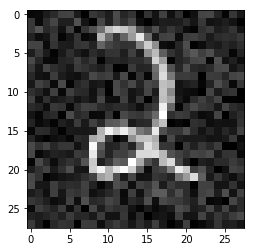

The classification label following attack is 2 from an original classification of 2
No adversarial image found
run with verbose=True to see details
Step 0: 5.43039e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 3.17853e-02, stepsizes = 1.0e-02/6.7e-03: d. reduced by 1.33% (4.2808e-04) (took 0.00324 seconds)
Step 100: 2.53241e-02, stepsizes = 1.0e-02/4.4e-03: d. reduced by 0.89% (2.2661e-04) (took 0.01045 seconds)
Step 150: 1.99105e-02, stepsizes = 1.0e-02/3.0e-03:  (took 0.00870 seconds)
Step 200: 1.89124e-02, stepsizes = 6.7e-03/2.0e-03:  (took 0.00812 seconds)
Step 250: 1.89124e-02, stepsizes = 4.4e-03/1.3e-03:  (took 0.00821 seconds)
Step 300: 1.89124e-02, stepsizes = 2.0e-03/5.9e-04:  (took 0.00854 seconds)
Step 350: 1.89124e-02, stepsizes = 1.3e-03/3.9e-04:  (took 0.00855 seconds)
Step 400: 1.89124e-02, stepsizes = 8.8e-04/2.6e-04:  (took 0.00830 seconds)
Step 450: 1.89124e-02, stepsizes = 5.9e-04/1.7e-04:  (took 0.01051 seconds)
Step 500: 1.89124e-02, stepsizes = 2.6e-04/7.7e-05:  (

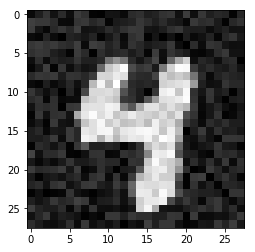

The classification label following attack is 4 from an original classification of 4
No adversarial image found
run with verbose=True to see details
Step 0: 7.51101e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.57006e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04878 seconds)
Step 100: 6.06331e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04980 seconds)
Step 150: 5.98273e-02, stepsizes = 6.7e-03/3.0e-03:  (took 0.00927 seconds)
Step 200: 5.98273e-02, stepsizes = 4.4e-03/2.0e-03:  (took 0.00822 seconds)
Step 250: 5.98273e-02, stepsizes = 3.0e-03/1.3e-03:  (took 0.00814 seconds)
Step 300: 5.98273e-02, stepsizes = 2.0e-03/8.8e-04:  (took 0.00834 seconds)
Step 350: 5.98273e-02, stepsizes = 8.8e-04/3.9e-04:  (took 0.00820 seconds)
Step 400: 5.98273e-02, stepsizes = 5.9e-04/2.6e-04:  (took 0.00810 seconds)
Step 450: 5.98273e-02, stepsizes = 3.9e-04/1.7e-04:  (took 0.00856 seconds)
Step 500: 5.98273e-02, stepsizes = 2.6e-04/1.2e-04:  (took 0.00817 seconds)
Step 550: 5.98273e-02, stepsizes = 1.2e-04

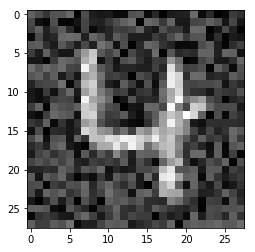

The classification label following attack is 4 from an original classification of 4
No adversarial image found


In [0]:
num_images_to_attack = 50
num_iterations = 1000
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function=cnn_binding_predictions,
                                                                                        model_weights="/Binding_CNN.ckpt", 
                                                                                      var_list=var_list_Binding,
                                                                                        num_images_to_attack=num_images_to_attack,
                                                                                        num_iterations=num_iterations, temp_batch_size=1)
#Note that as the Boundary Attack appears to display unusual behaviour against this network, each adversarial image is also shown

In [0]:
np.savetxt("BindingNetwork_adversaries.csv", 
           np.reshape(adversary_arrays, [adversary_arrays.shape[0], adversary_arrays.shape[1]*adversary_arrays.shape[2]]), 
                      delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [0]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 0.14
The mean distance is 5.212487852917393


In [0]:
!find -type f | grep -P '\.csv' | tar cvzf Generated_adversaries.gz -T -

./Madry_adversaries.csv
./StandardCNN_adversaries.csv
./BindingNetwork_adversaries.csv
./mnist_test.csv
./california_housing_train.csv
./california_housing_test.csv
./mnist_train_small.csv


In [0]:
from google.colab import files
files.download('Generated_adversaries.gz') 

On running the above, the Binding-network appears to only misclassify 24% of the examples generated, and of these, the mean L-2 distance required to cause misclassification is 8.32. This is much better performance than for the other networks, but on inspecting the running of the code, the Boundary Attack appears to be performing oddly together with the network, in that after identifying an adversarial example (i.e. with 100% success, as for the other models), it continues to iteratively decrease the noise over the 1000 iteraitons. After this reduction in noise, the network is generally able to classify the example; thus the issue appears to be that the Boundary Attack is not remaining in what the 'region of adversity'. It is likely this is due to a bug in my own execution of the attack, and so an alternative measure of adversarial resistance is explored below.

#Part 3 - Direct Comparison of Each Network's Performance

##Transfer Attacks

As it is unclear from the above results whether the Binding CNN is genuinely more resistant to adversarial attacks, or there is simply an issue with how the Boundary Attack is being leveraged against it, an additional measure will be performed. The following assesses how resistant each network is to the adversarial examples generated by the other networks; such an attack is in fact a form of a blac box attack know as a 'transfer attack'. Generally speaking, adversarial examples generalize well across models, and so any indication that a model is resistant to the adversarial examples of other is a positive sign that it is genuinely resistant. As this assessment does not make use of FoolBox, any possible issues with the implementation of the Boundary Attack against the binding network should not confer non-genuine resistance to the transfer attacks.

###Transfer Attacks Against the Keras Models

In [0]:
def Transfer_Attack_KerasModel(model, transfer_attack_images):
    
    #Load transfer_attack_images and reshape
    transfer_images = np.genfromtxt(transfer_attack_images, delimiter=',')
    

    
    for ii in range(transfer_images.shape[0]):
        test_image = transfer_images[ii, :]
                
        plt.imshow(np.reshape(test_image, [28, 28, 1])[:,:,0], cmap='gray')
        plt.show()
        print("The network predicted a class label of " + str(np.argmax(model.predictions(test_image))))
        


####Madry Model vs Standard CNN Adversaries

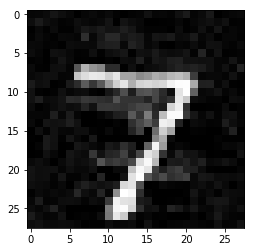

The network predicted a class label of 7


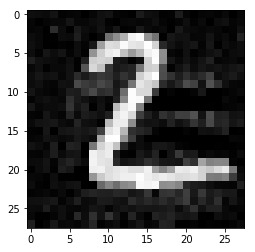

The network predicted a class label of 2


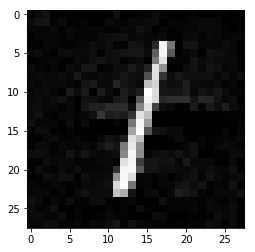

The network predicted a class label of 1


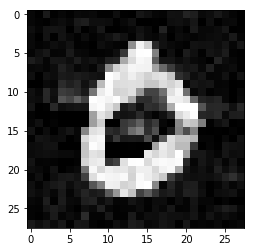

The network predicted a class label of 0


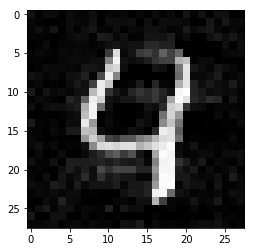

The network predicted a class label of 4


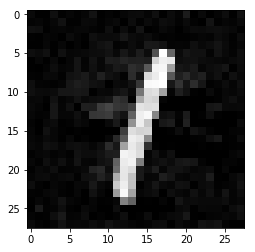

The network predicted a class label of 1


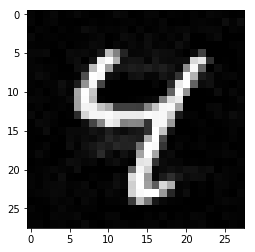

The network predicted a class label of 4


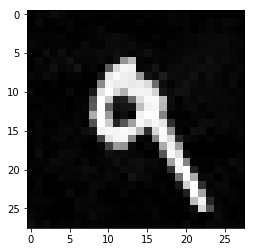

The network predicted a class label of 9


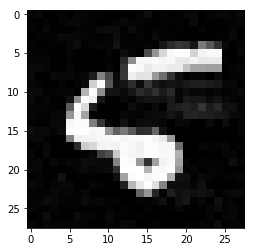

The network predicted a class label of 5


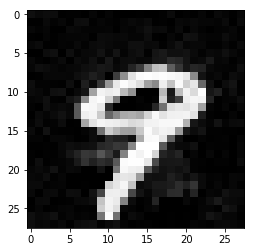

The network predicted a class label of 9


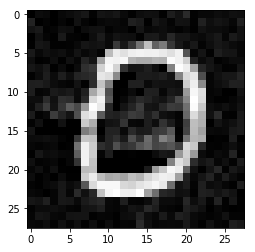

The network predicted a class label of 0


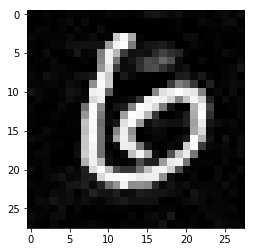

The network predicted a class label of 6


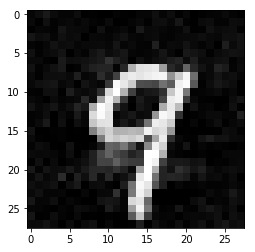

The network predicted a class label of 9


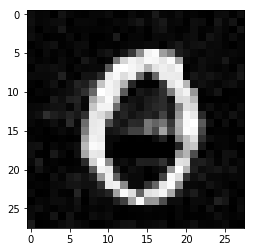

The network predicted a class label of 0


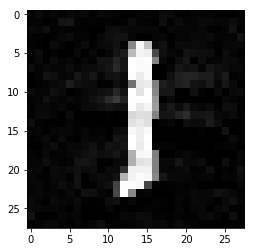

The network predicted a class label of 1


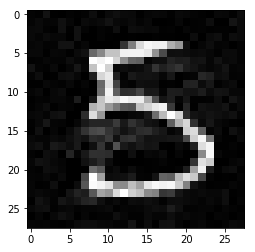

The network predicted a class label of 5


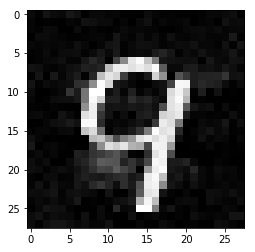

The network predicted a class label of 9


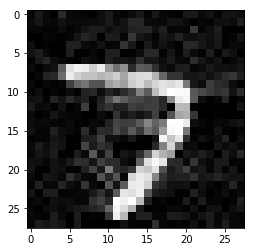

The network predicted a class label of 7


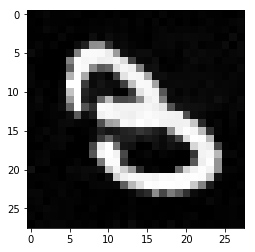

The network predicted a class label of 3


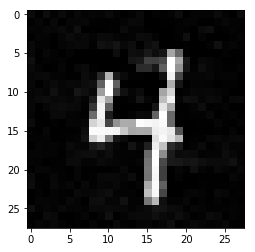

The network predicted a class label of 4


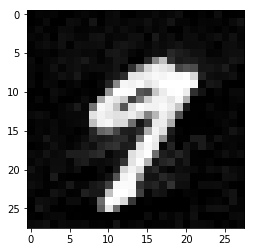

The network predicted a class label of 9


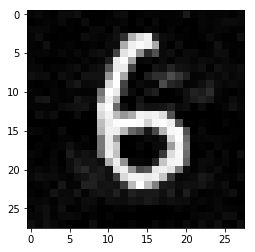

The network predicted a class label of 6


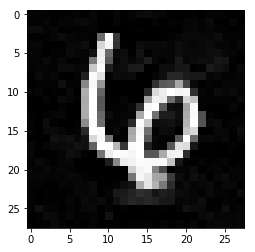

The network predicted a class label of 6


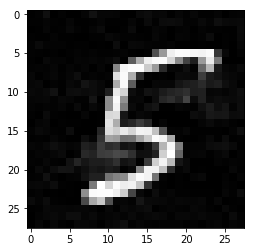

The network predicted a class label of 5


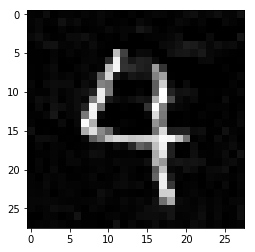

The network predicted a class label of 4


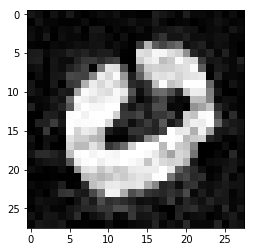

The network predicted a class label of 0


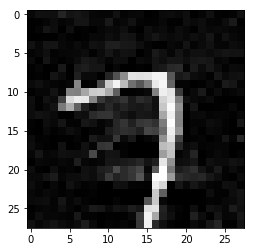

The network predicted a class label of 7


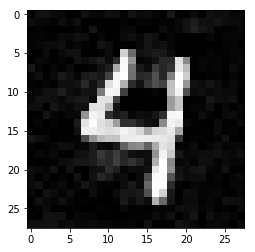

The network predicted a class label of 4


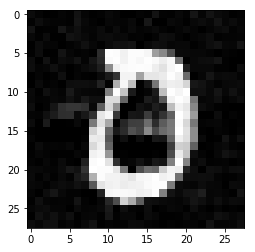

The network predicted a class label of 0


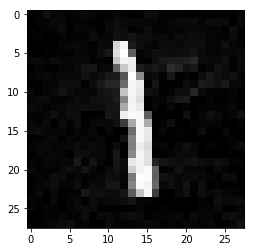

The network predicted a class label of 1


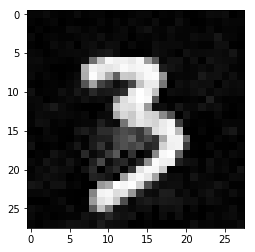

The network predicted a class label of 3


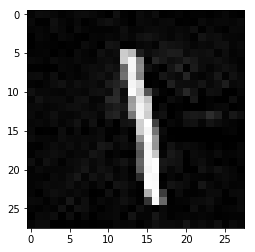

The network predicted a class label of 1


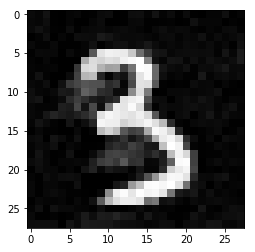

The network predicted a class label of 3


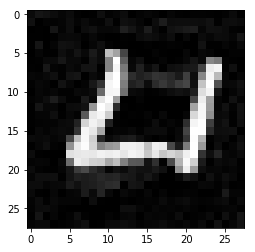

The network predicted a class label of 4


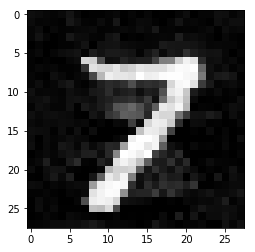

The network predicted a class label of 7


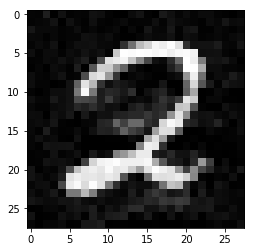

The network predicted a class label of 2


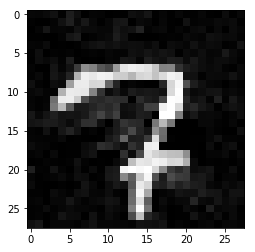

The network predicted a class label of 7


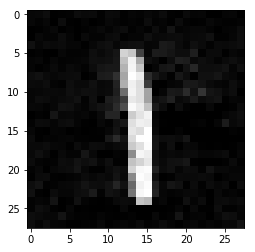

The network predicted a class label of 1


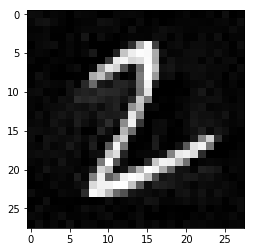

The network predicted a class label of 2


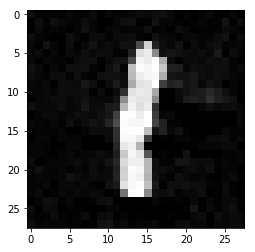

The network predicted a class label of 1


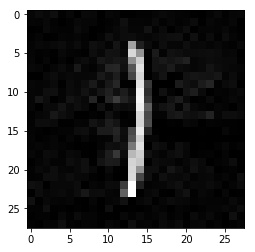

The network predicted a class label of 1


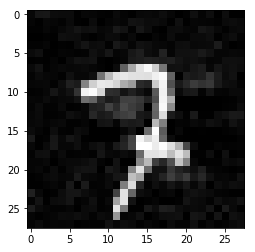

The network predicted a class label of 7


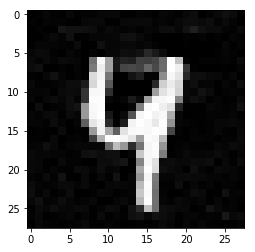

The network predicted a class label of 4


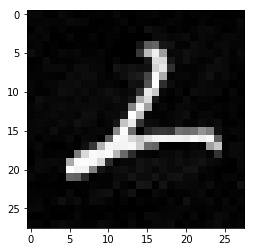

The network predicted a class label of 2


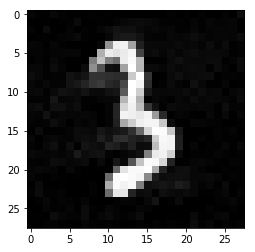

The network predicted a class label of 3


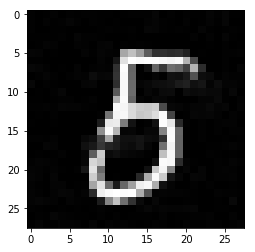

The network predicted a class label of 5


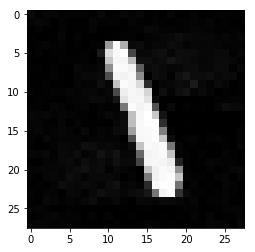

The network predicted a class label of 1


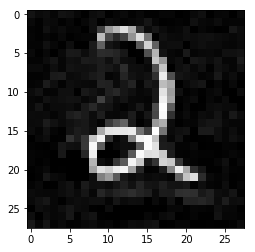

The network predicted a class label of 2


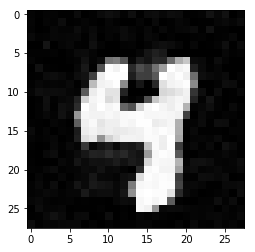

The network predicted a class label of 4


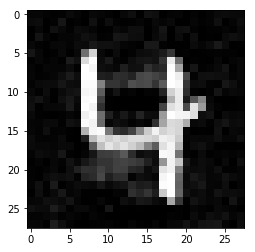

The network predicted a class label of 4


In [0]:
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="StandardCNN_adversaries.csv")

The Madry network performs well against standard CNN adversaries, getting 10/10.

####Madry Model vs Binding CNN Adversaries

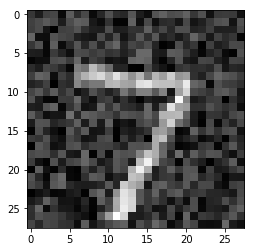

The network predicted a class label of 7


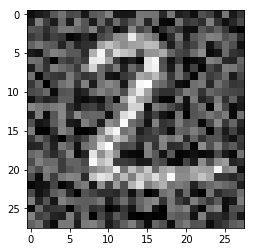

The network predicted a class label of 2


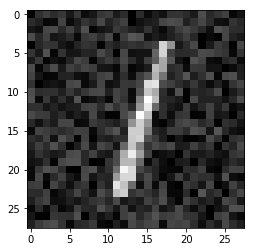

The network predicted a class label of 1


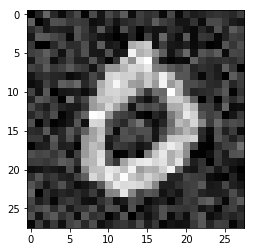

The network predicted a class label of 0


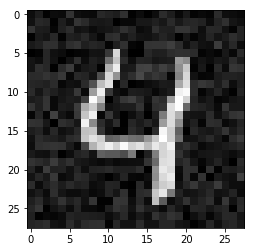

The network predicted a class label of 4


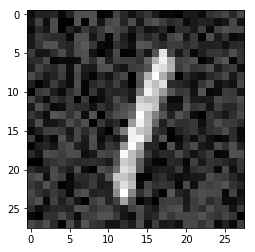

The network predicted a class label of 1


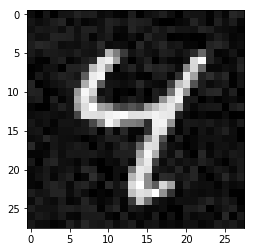

The network predicted a class label of 4


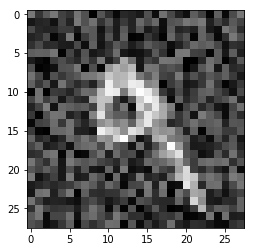

The network predicted a class label of 8


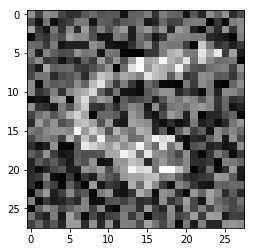

The network predicted a class label of 0


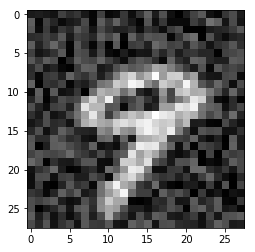

The network predicted a class label of 9


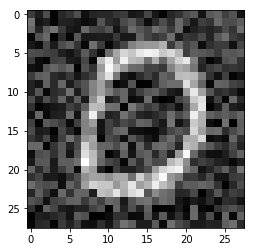

The network predicted a class label of 0


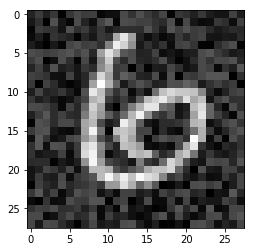

The network predicted a class label of 6


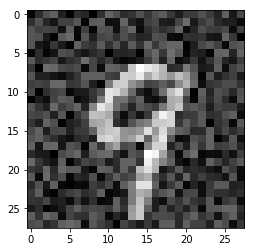

The network predicted a class label of 9


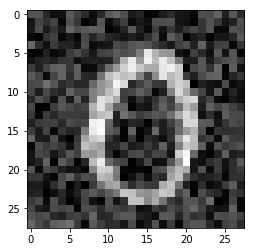

The network predicted a class label of 0


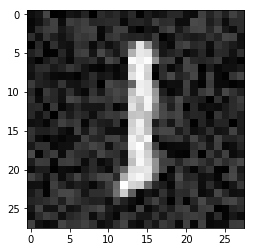

The network predicted a class label of 1


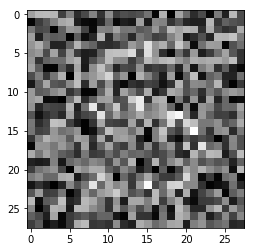

The network predicted a class label of 0


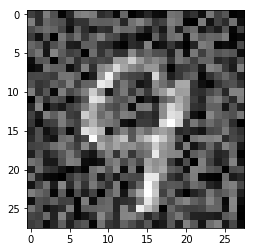

The network predicted a class label of 9


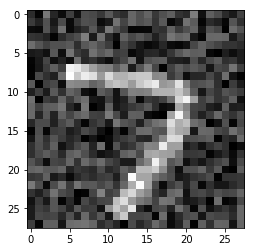

The network predicted a class label of 7


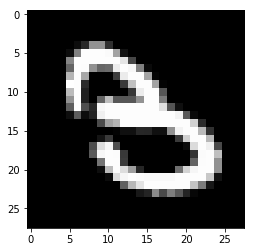

The network predicted a class label of 3


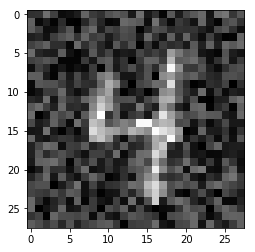

The network predicted a class label of 4


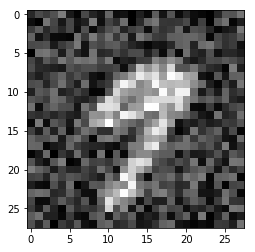

The network predicted a class label of 0


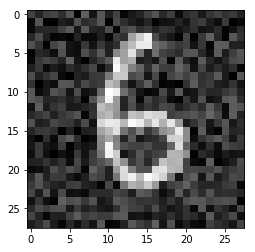

The network predicted a class label of 6


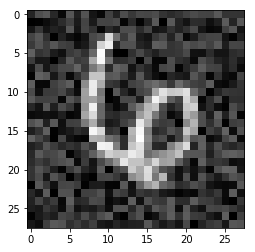

The network predicted a class label of 6


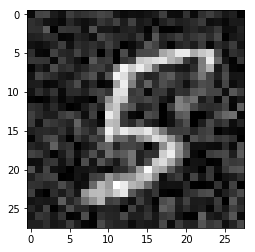

The network predicted a class label of 5


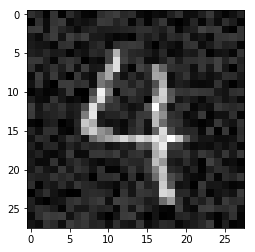

The network predicted a class label of 4


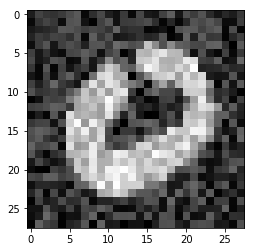

The network predicted a class label of 0


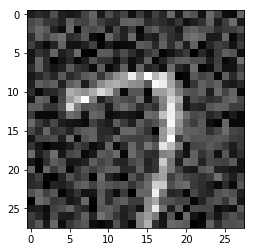

The network predicted a class label of 7


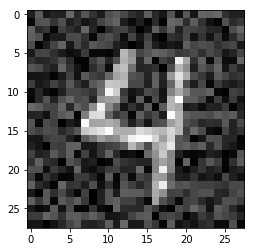

The network predicted a class label of 4


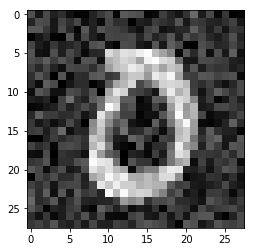

The network predicted a class label of 0


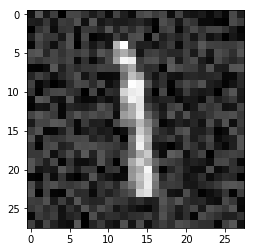

The network predicted a class label of 1


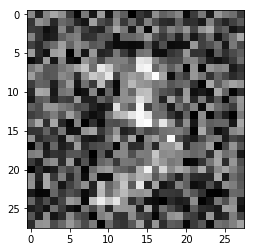

The network predicted a class label of 0


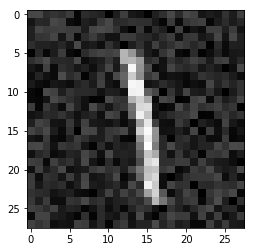

The network predicted a class label of 1


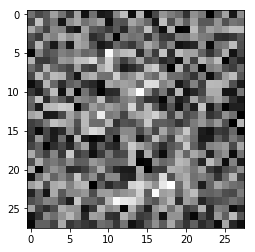

The network predicted a class label of 2


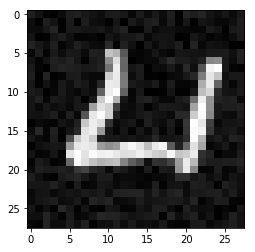

The network predicted a class label of 4


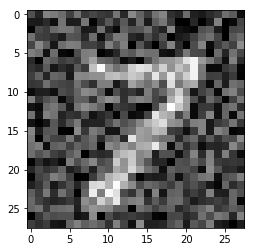

The network predicted a class label of 8


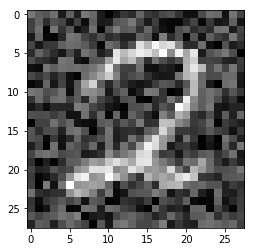

The network predicted a class label of 2


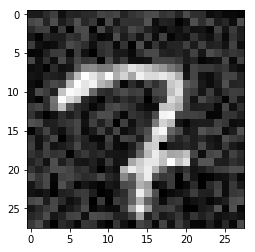

The network predicted a class label of 7


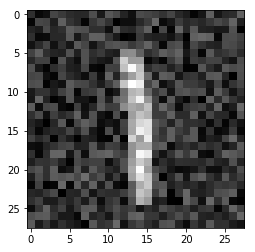

The network predicted a class label of 1


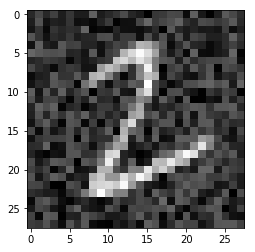

The network predicted a class label of 2


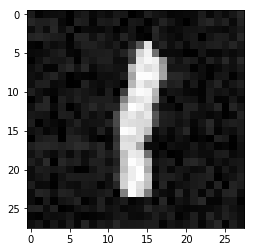

The network predicted a class label of 1


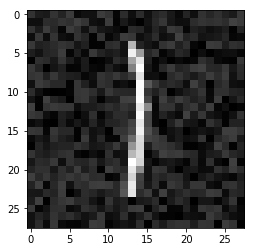

The network predicted a class label of 1


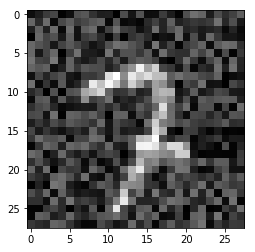

The network predicted a class label of 7


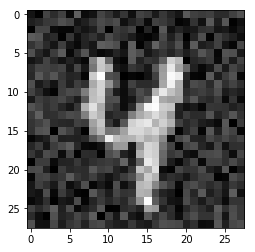

The network predicted a class label of 4


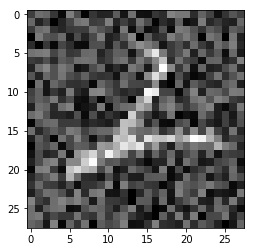

The network predicted a class label of 2


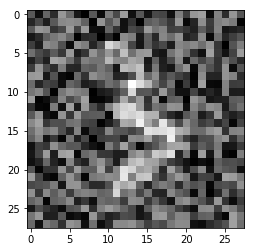

The network predicted a class label of 0


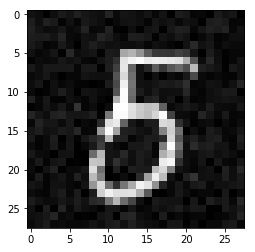

The network predicted a class label of 5


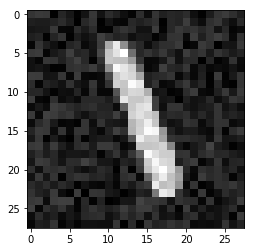

The network predicted a class label of 1


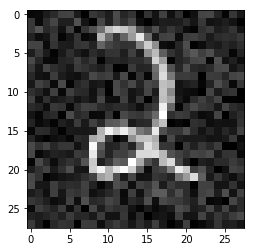

The network predicted a class label of 2


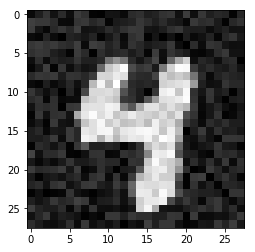

The network predicted a class label of 4


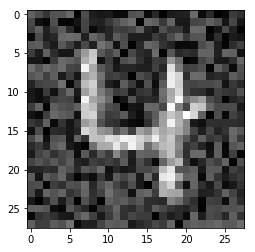

The network predicted a class label of 4


In [0]:
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="BindingNetwork_adversaries.csv")

The Madry network does reasonably well against the Binding-CNN adversaries, scoring 7/10. Note this may be more appropriately measured as 5/8, given that the '0' above is essentially uninformative to a human, and that the second-to-last example of a 5 is also arguably of poor ground-truth.

####Madry Model vs Its Own Adversaries

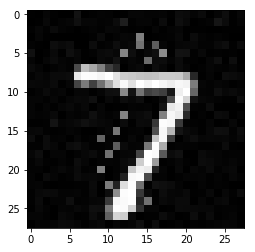

The network predicted a class label of 0


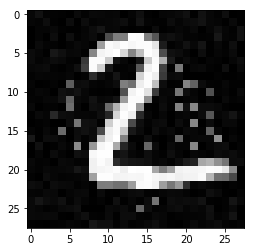

The network predicted a class label of 0


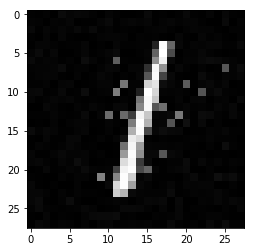

The network predicted a class label of 8


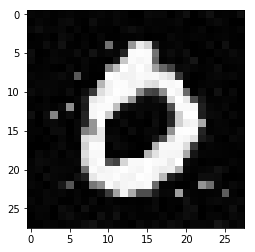

The network predicted a class label of 0


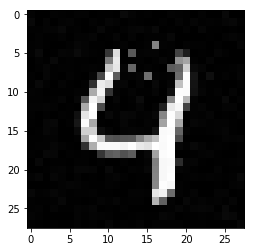

The network predicted a class label of 4


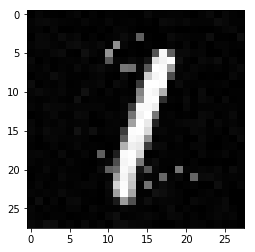

The network predicted a class label of 2


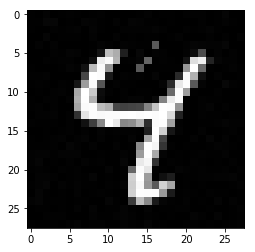

The network predicted a class label of 8


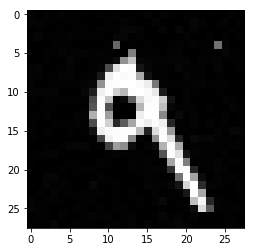

The network predicted a class label of 4


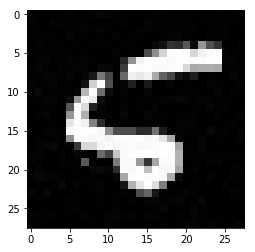

The network predicted a class label of 6


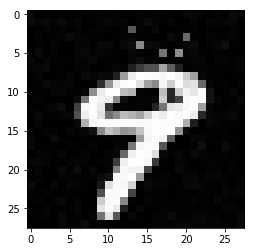

The network predicted a class label of 4


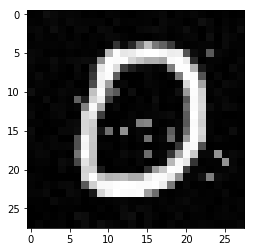

The network predicted a class label of 2


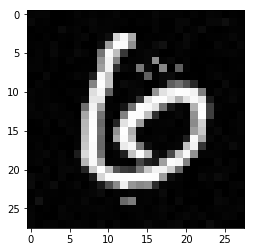

The network predicted a class label of 0


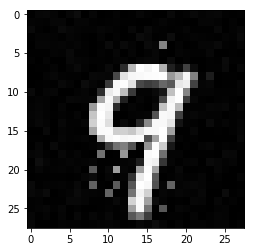

The network predicted a class label of 8


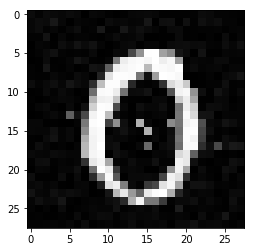

The network predicted a class label of 8


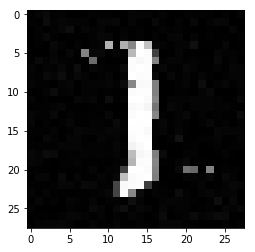

The network predicted a class label of 2


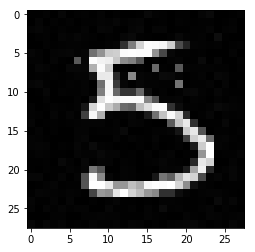

The network predicted a class label of 3


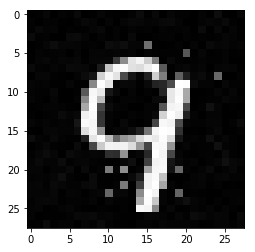

The network predicted a class label of 9


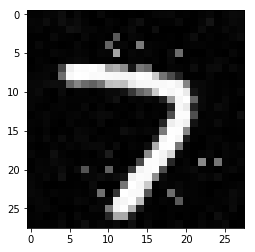

The network predicted a class label of 2


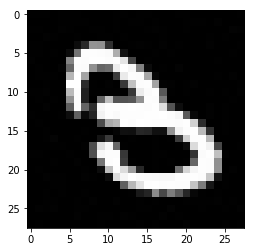

The network predicted a class label of 8


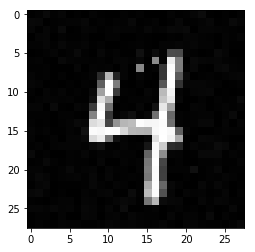

The network predicted a class label of 9


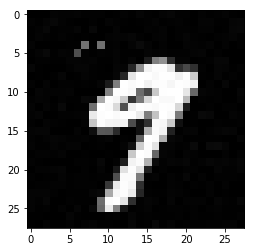

The network predicted a class label of 7


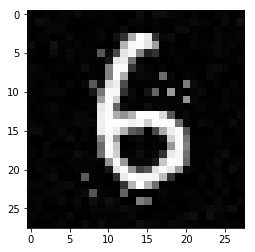

The network predicted a class label of 8


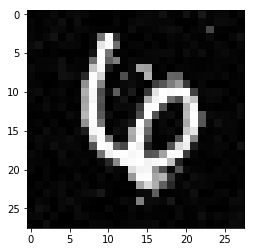

The network predicted a class label of 0


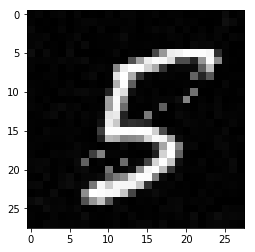

The network predicted a class label of 8


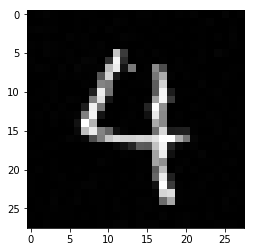

The network predicted a class label of 9


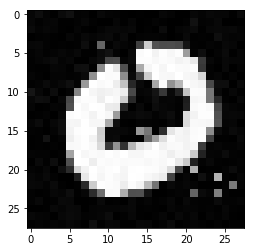

The network predicted a class label of 2


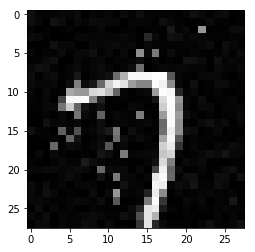

The network predicted a class label of 0


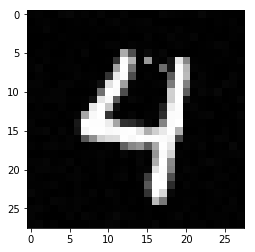

The network predicted a class label of 9


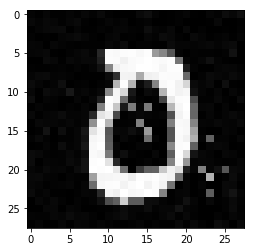

The network predicted a class label of 2


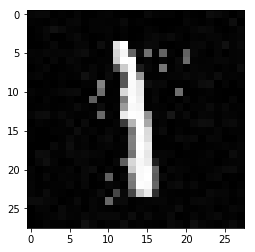

The network predicted a class label of 8


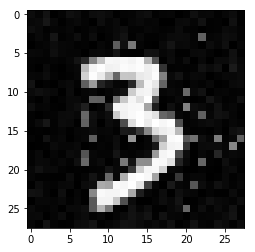

The network predicted a class label of 2


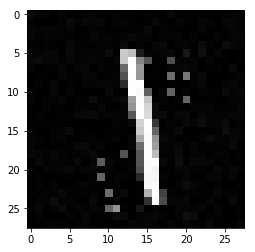

The network predicted a class label of 8


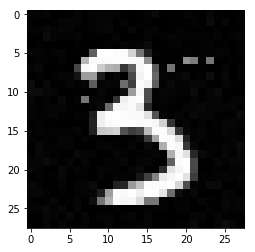

The network predicted a class label of 5


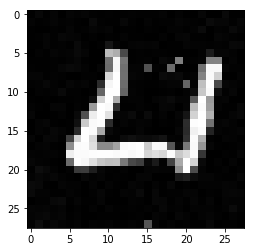

The network predicted a class label of 0


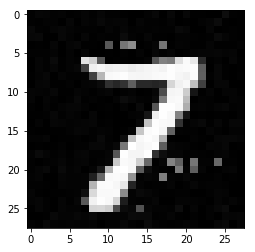

The network predicted a class label of 2


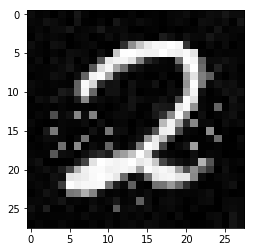

The network predicted a class label of 0


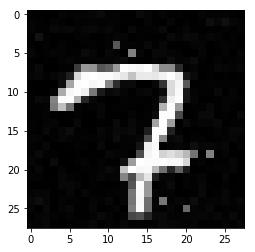

The network predicted a class label of 2


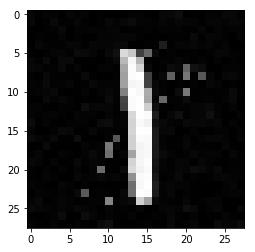

The network predicted a class label of 8


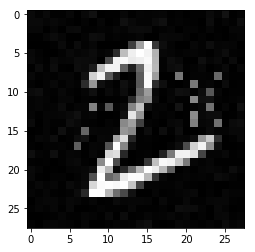

The network predicted a class label of 0


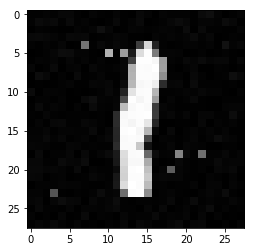

The network predicted a class label of 2


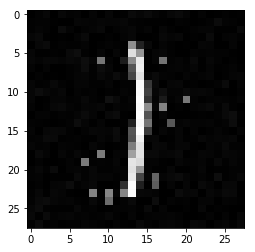

The network predicted a class label of 8


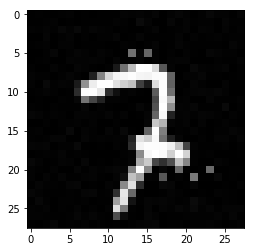

The network predicted a class label of 7


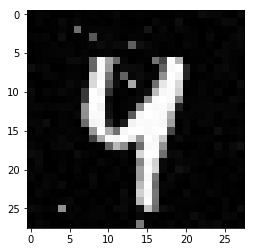

The network predicted a class label of 9


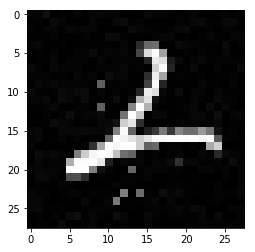

The network predicted a class label of 4


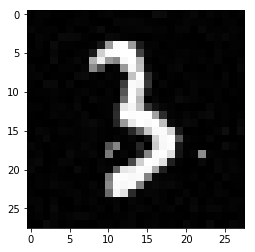

The network predicted a class label of 2


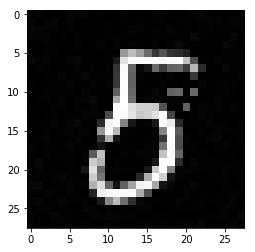

The network predicted a class label of 8


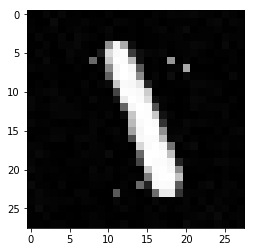

The network predicted a class label of 8


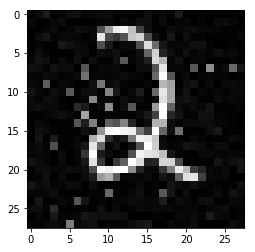

The network predicted a class label of 4


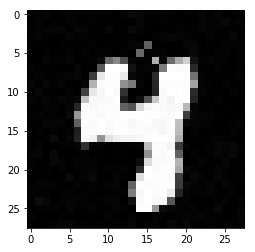

The network predicted a class label of 9


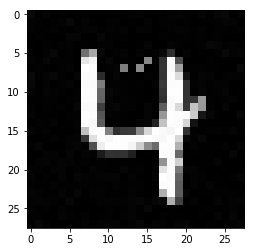

The network predicted a class label of 9


In [0]:
#Double check the adversaries work against the model they were developed for
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="Madry_adversaries.csv")

As expected, the Madry network scores 0/10 against its own adversaries.

###Transfer Attacks Against the TensorFlow Models

In [0]:
def Transfer_Attack_prediction_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, temp_batch_size):
    
    predictions = model_prediction_function(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list)
    
    with tf.Session() as sess:
        saver.restore(sess, model_weights)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob: 1.0})
                
        return output_predictions

In [0]:
def Transfer_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, transfer_attack_images, temp_batch_size):
    
    #Load transfer_attack_images and reshape
    transfer_images = np.genfromtxt(transfer_attack_images, delimiter=',')
    
    
    transfer_images = np.reshape(transfer_images, [transfer_images.shape[0], 28, 28, 1])

    
    for ii in range(transfer_images.shape[0]):
        test_image = transfer_images[ii, :, :, :]
        
        output_predictions = Transfer_Attack_prediction_customTensorFlowModel(model_prediction_function, model_weights, var_list, 
                                                                              test_image[None, :, :, :], temp_batch_size)
        
        plt.imshow(test_image[:,:,0], cmap='gray')
        plt.show()
        print("The network predicted a class label of " + str(np.argmax(output_predictions)))

####Standard CNN vs Madry Adversaries

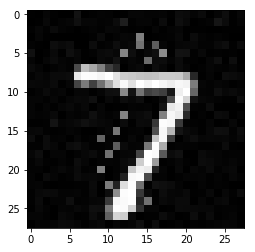

The network predicted a class label of 7


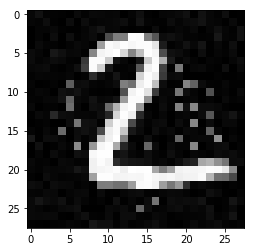

The network predicted a class label of 2


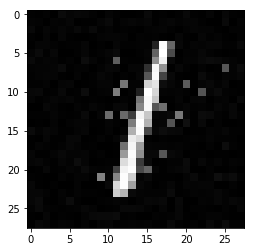

The network predicted a class label of 1


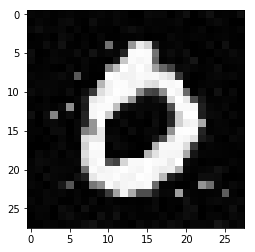

The network predicted a class label of 0


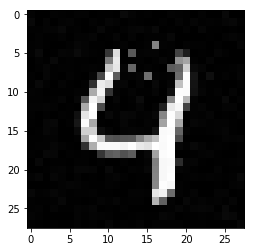

The network predicted a class label of 4


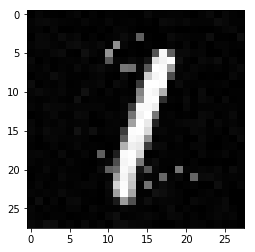

The network predicted a class label of 1


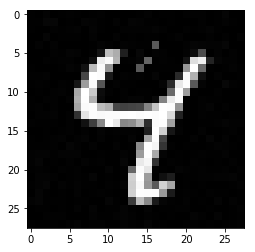

The network predicted a class label of 4


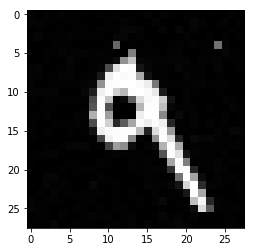

The network predicted a class label of 9


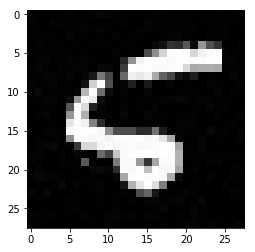

The network predicted a class label of 5


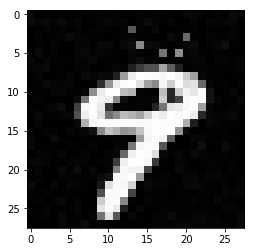

The network predicted a class label of 9


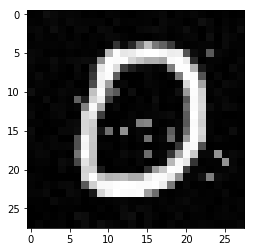

The network predicted a class label of 0


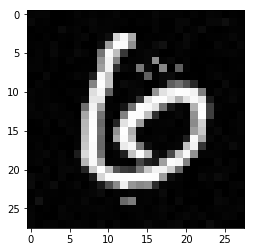

The network predicted a class label of 6


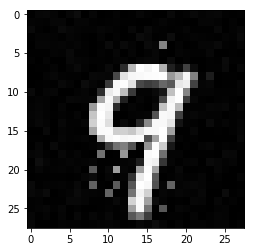

The network predicted a class label of 9


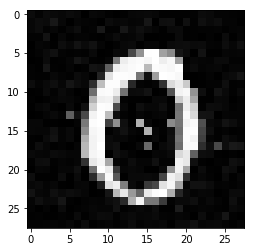

The network predicted a class label of 0


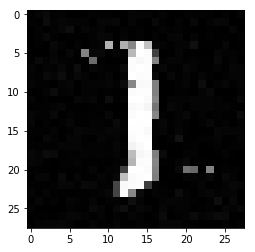

The network predicted a class label of 1


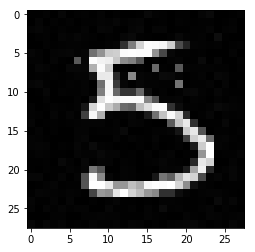

The network predicted a class label of 5


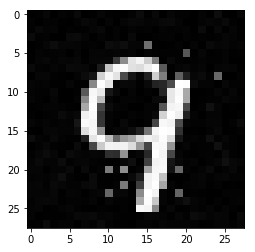

The network predicted a class label of 9


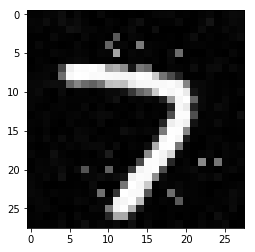

The network predicted a class label of 7


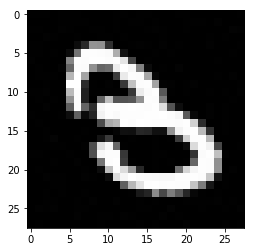

The network predicted a class label of 3


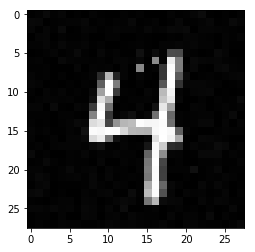

The network predicted a class label of 4


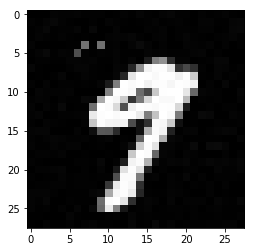

The network predicted a class label of 9


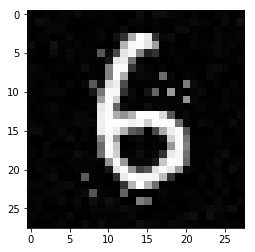

The network predicted a class label of 6


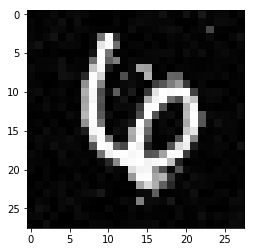

The network predicted a class label of 6


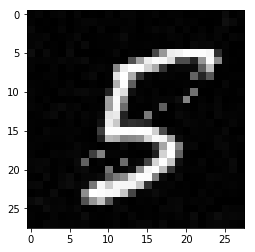

The network predicted a class label of 5


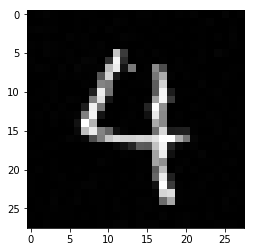

The network predicted a class label of 4


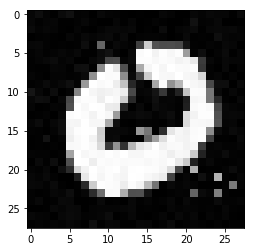

The network predicted a class label of 0


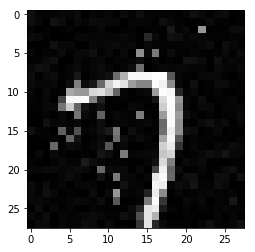

The network predicted a class label of 7


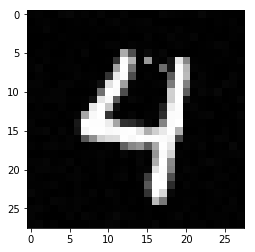

The network predicted a class label of 4


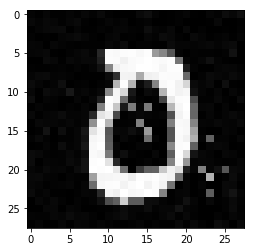

The network predicted a class label of 0


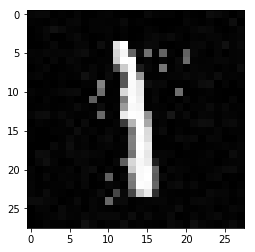

The network predicted a class label of 1


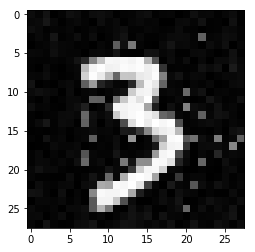

The network predicted a class label of 3


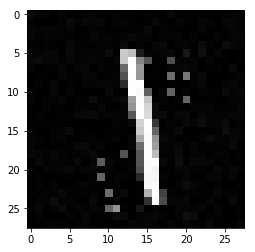

The network predicted a class label of 1


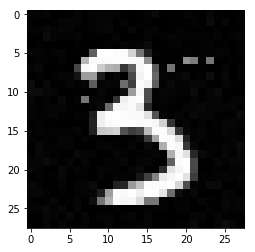

The network predicted a class label of 3


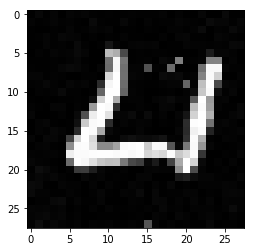

The network predicted a class label of 4


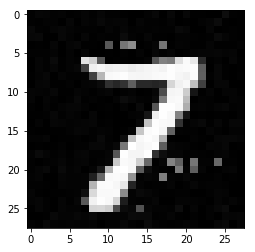

The network predicted a class label of 7


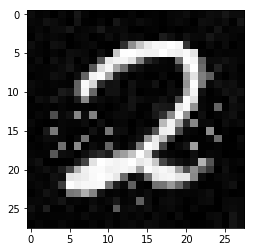

The network predicted a class label of 2


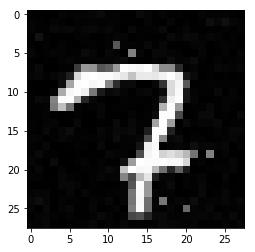

The network predicted a class label of 7


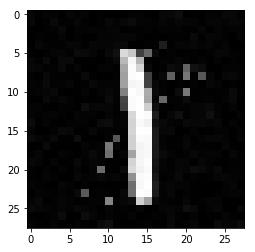

The network predicted a class label of 1


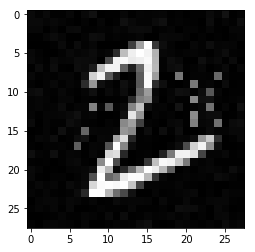

The network predicted a class label of 2


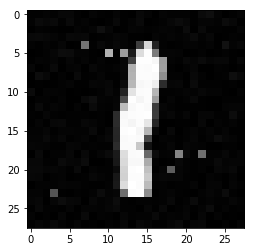

The network predicted a class label of 1


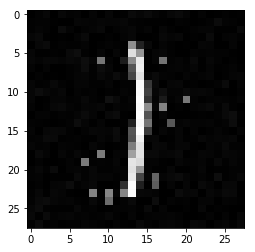

The network predicted a class label of 1


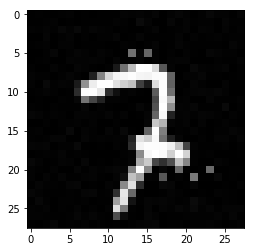

The network predicted a class label of 7


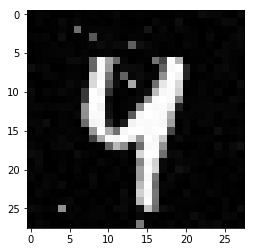

The network predicted a class label of 4


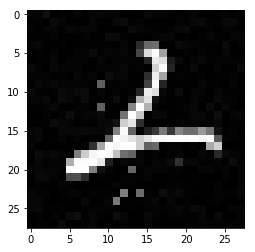

The network predicted a class label of 2


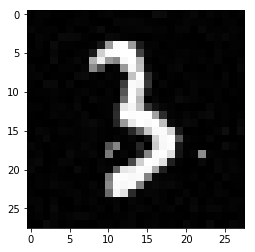

The network predicted a class label of 3


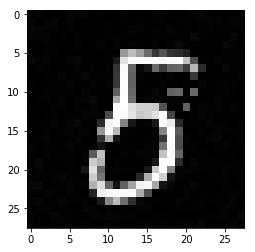

The network predicted a class label of 5


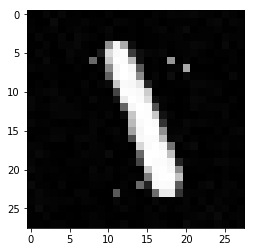

The network predicted a class label of 1


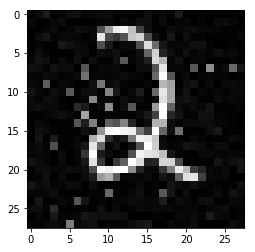

The network predicted a class label of 2


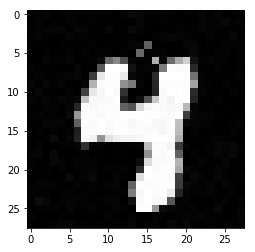

The network predicted a class label of 4


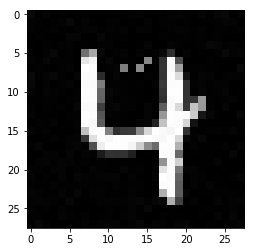

The network predicted a class label of 4


In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="Madry_adversaries.csv",
                                      temp_batch_size=None)

The standard CNN scores 5/10 against the Madry examples; this is worse than the binding CNN, but not significantly so, suggesting that the binding-CNN may have most of its advantage simply from e.g. more parameters.

####Standard CNN vs Binding Network Adversaries

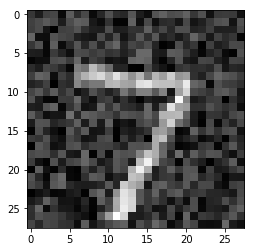

The network predicted a class label of 7


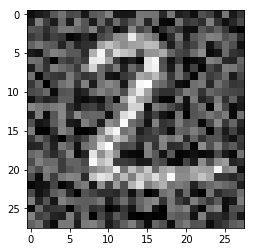

The network predicted a class label of 8


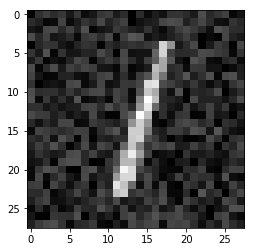

The network predicted a class label of 1


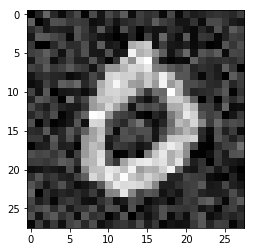

The network predicted a class label of 0


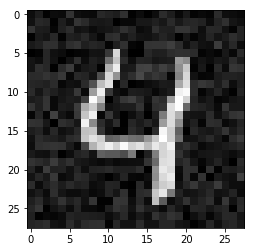

The network predicted a class label of 4


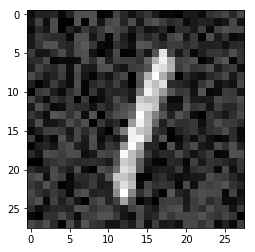

The network predicted a class label of 1


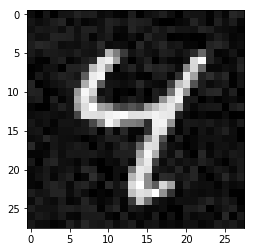

The network predicted a class label of 4


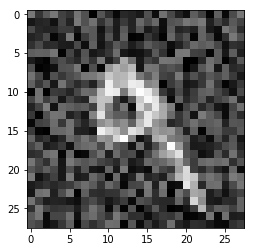

The network predicted a class label of 8


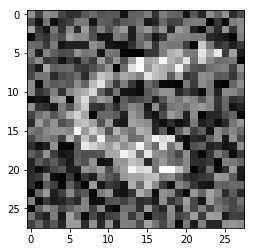

The network predicted a class label of 8


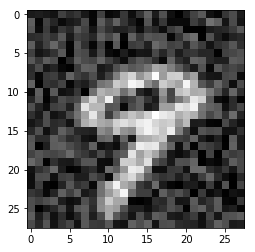

The network predicted a class label of 8


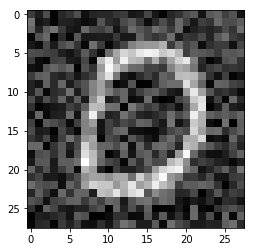

The network predicted a class label of 0


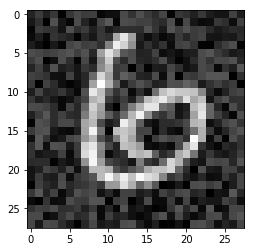

The network predicted a class label of 6


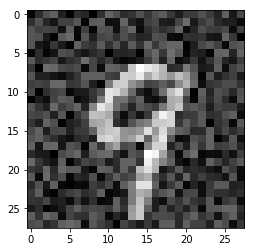

The network predicted a class label of 9


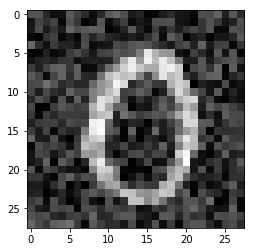

The network predicted a class label of 0


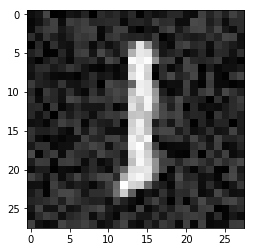

The network predicted a class label of 1


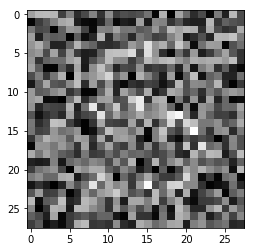

The network predicted a class label of 8


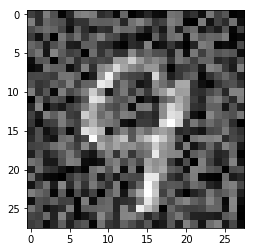

The network predicted a class label of 4


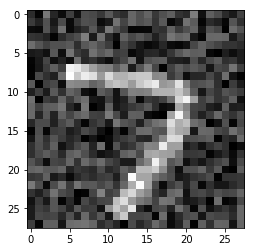

The network predicted a class label of 7


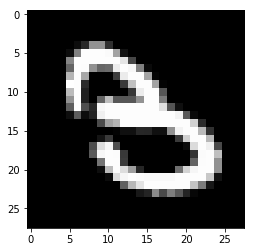

The network predicted a class label of 3


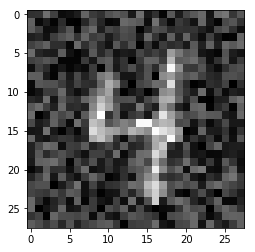

The network predicted a class label of 4


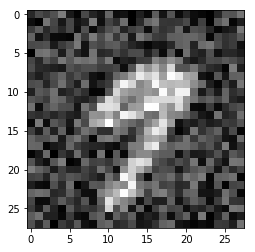

The network predicted a class label of 8


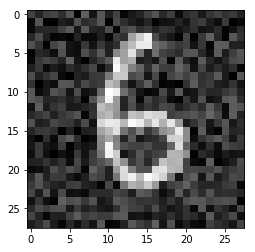

The network predicted a class label of 8


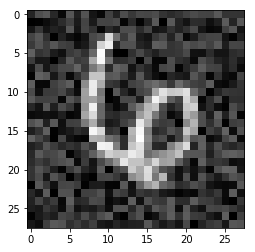

The network predicted a class label of 6


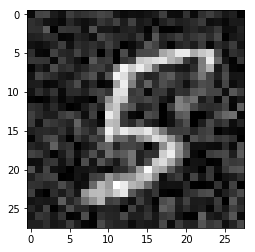

The network predicted a class label of 8


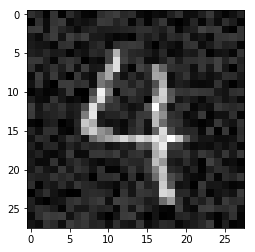

The network predicted a class label of 4


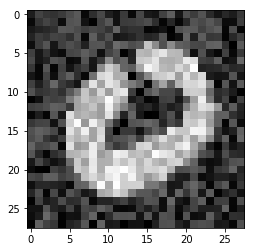

The network predicted a class label of 0


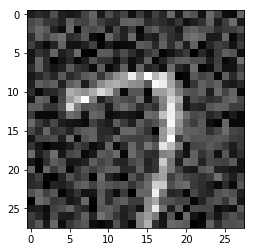

The network predicted a class label of 7


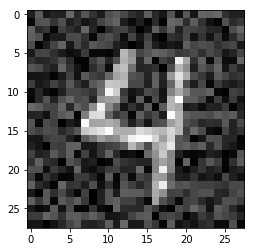

The network predicted a class label of 4


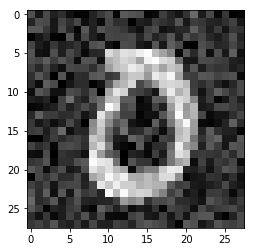

The network predicted a class label of 0


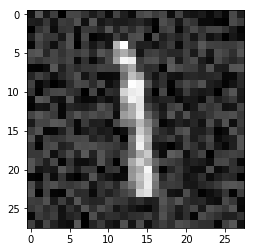

The network predicted a class label of 1


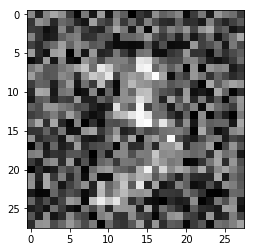

The network predicted a class label of 8


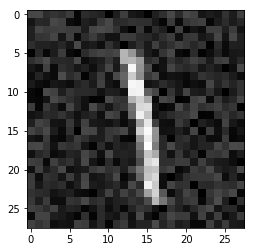

The network predicted a class label of 8


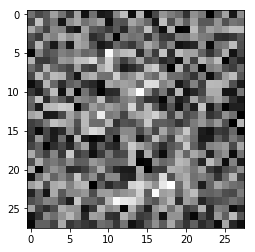

The network predicted a class label of 8


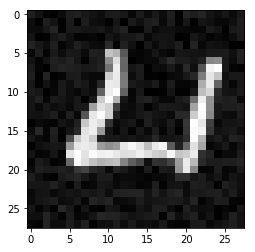

The network predicted a class label of 4


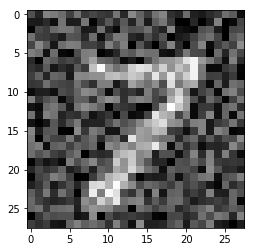

The network predicted a class label of 8


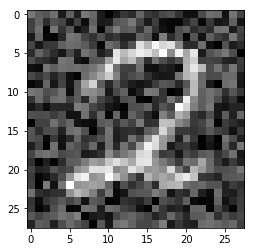

The network predicted a class label of 2


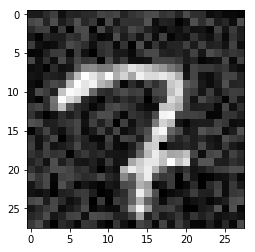

The network predicted a class label of 7


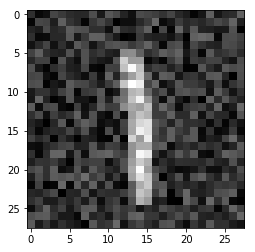

The network predicted a class label of 8


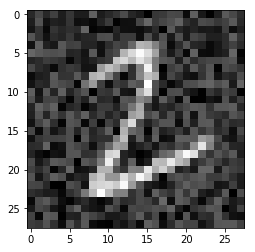

The network predicted a class label of 0


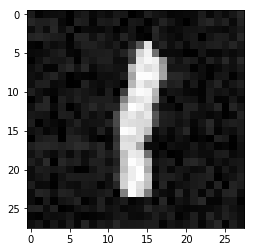

The network predicted a class label of 1


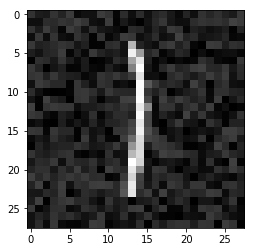

The network predicted a class label of 1


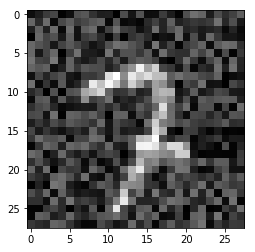

The network predicted a class label of 7


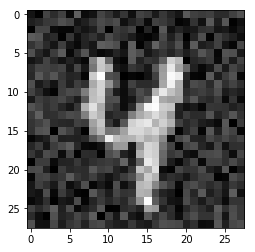

The network predicted a class label of 4


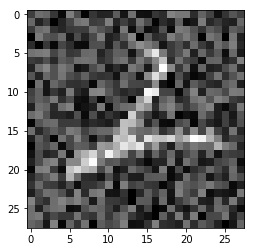

The network predicted a class label of 4


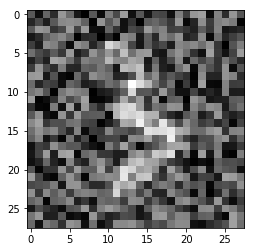

The network predicted a class label of 8


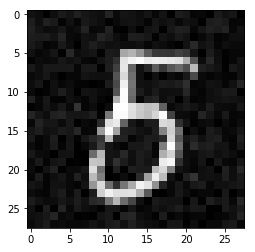

The network predicted a class label of 5


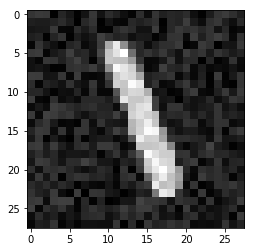

The network predicted a class label of 8


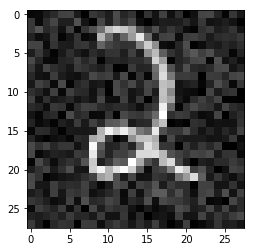

The network predicted a class label of 2


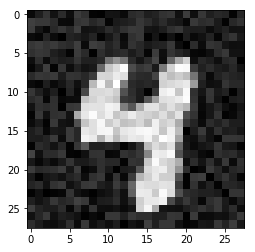

The network predicted a class label of 4


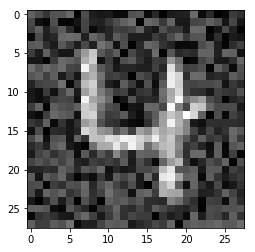

The network predicted a class label of 4


In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="BindingNetwork_adversaries.csv",
                                      temp_batch_size=None)

The standard CNN performs poorly (2/10) against the binding networks adversaries.

####Standard CNN vs Its Own Adversaries

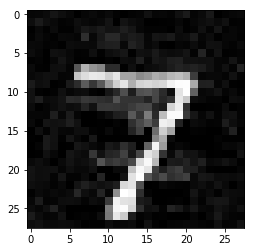

The network predicted a class label of 8


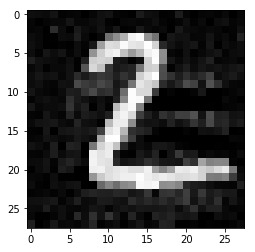

The network predicted a class label of 8


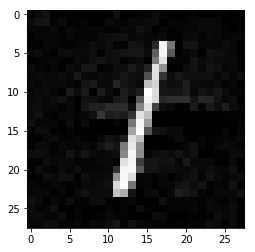

The network predicted a class label of 8


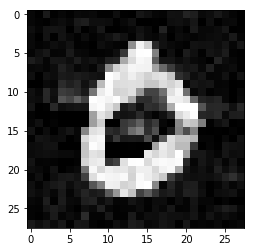

The network predicted a class label of 8


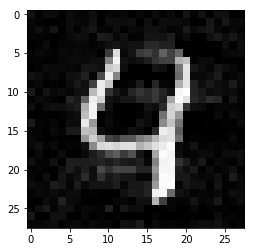

The network predicted a class label of 8


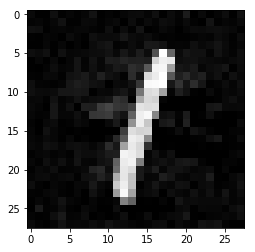

The network predicted a class label of 8


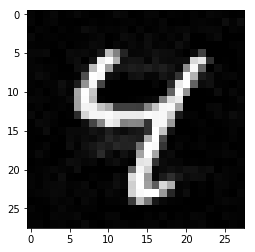

The network predicted a class label of 8


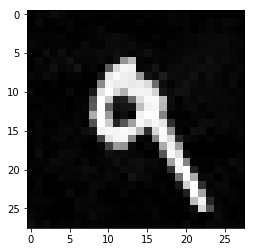

The network predicted a class label of 4


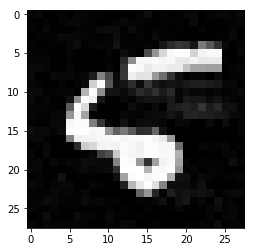

The network predicted a class label of 8


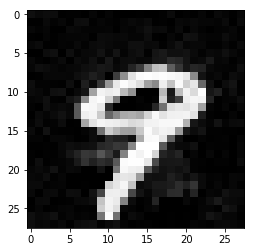

The network predicted a class label of 8


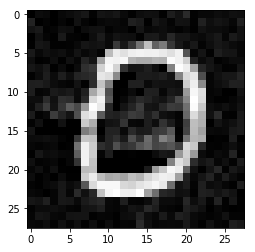

The network predicted a class label of 8


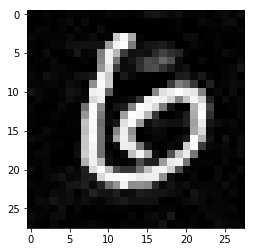

The network predicted a class label of 0


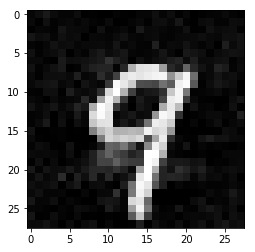

The network predicted a class label of 8


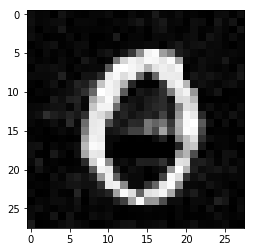

The network predicted a class label of 8


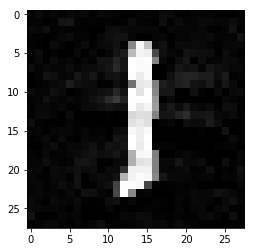

The network predicted a class label of 8


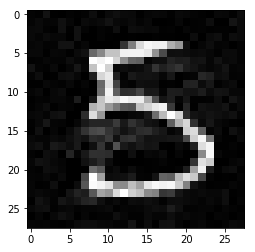

The network predicted a class label of 8


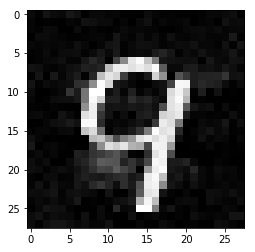

The network predicted a class label of 8


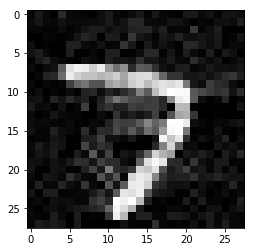

The network predicted a class label of 8


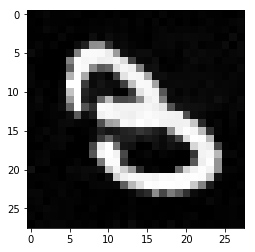

The network predicted a class label of 8


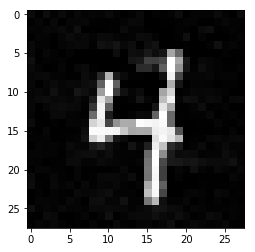

The network predicted a class label of 9


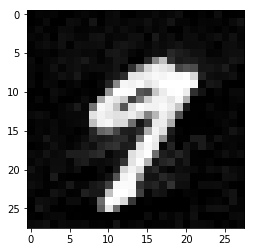

The network predicted a class label of 8


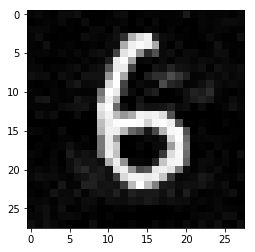

The network predicted a class label of 8


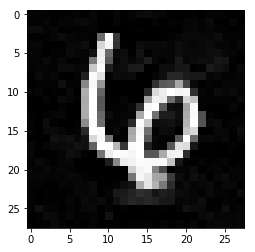

The network predicted a class label of 4


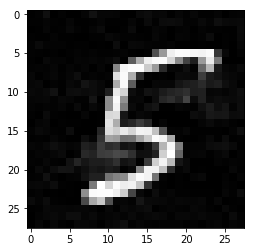

The network predicted a class label of 8


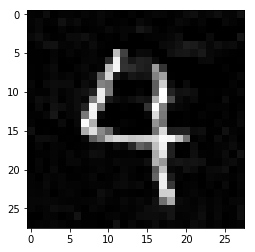

The network predicted a class label of 9


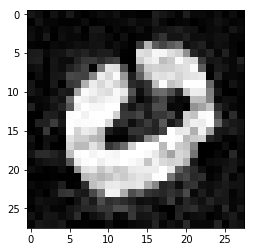

The network predicted a class label of 8


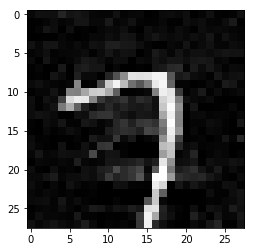

The network predicted a class label of 8


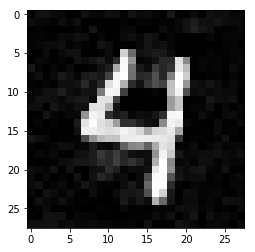

The network predicted a class label of 9


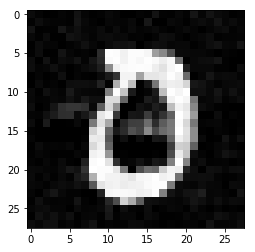

The network predicted a class label of 8


KeyboardInterrupt: ignored

In [0]:
#Double check the adversaries work against the model they were developed for
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="StandardCNN_adversaries.csv",
                                      temp_batch_size=None)

As expected, the standard CNN scores 0/10 against its own adversaries.

####Binding Model vs Standard CNN Adversaries

In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="StandardCNN_adversaries.csv",
                                      temp_batch_size=1)

The binding network performs well against the standard CNN adversaries, scoring 9/10, although note the one class it scored incorrectly (the second to last example) has a debatable ground truth.

####Binding Network vs Mardy Adversaries

In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="Madry_adversaries.csv",
                                      temp_batch_size=1)

The binding network performed reasonably against the Madry adversaries, scoring 7/10. Note in particular that the binding network has had *no* training on adversarial examples, and yet its performance is comparable to that of the highly optimized (and I believe larger-parameter) Madry model.

####Binding Network vs Its Own Adversaries

In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="BindingNetwork_adversaries.csv",
                                      temp_batch_size=1)

As expected, the binding network scores 0/10 against its own adversaries.

##Point-Wise Attack

###Point-Wise Attack Functions for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def PointWise_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, test_label, temp_batch_size):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.PointwiseAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
#Iterate through a series of images to be attacked
def evaluate_l0_PointWiseAttack_resistance_CustomModel(model_prediction_function, model_weights, var_list, num_images_to_attack, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = PointWise_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l0_distance = scipy.spatial.distance.hamming(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L0 distance of the adversary is " + str(l0_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l0_distance
        
    return adversary_found, adversary_distance, adversary_arrays

###Visualize the Point-Wise Attack

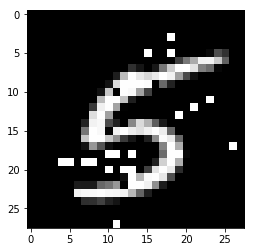

The classification label following attack is 6 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = PointWise_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None)


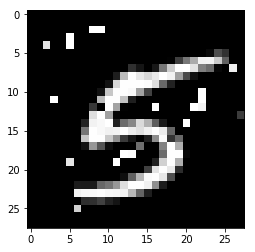

The classification label following attack is 8 from an original classification of 5


In [0]:
adversarial_image_fmodel, adversarial_label_fmodel = PointWise_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                  var_list=var_list_Binding,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1)


###Quantify Vulnerability

In [0]:
num_images_to_attack=10

####Standard CNN

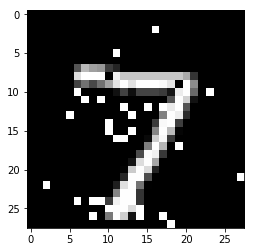

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.03826530612244898


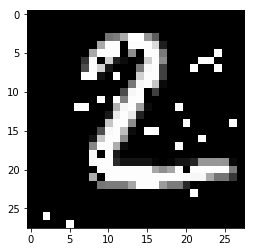

The classification label following attack is 6 from an original classification of 2
The L0 distance of the adversary is 0.04081632653061224


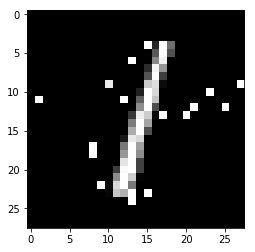

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.021683673469387755


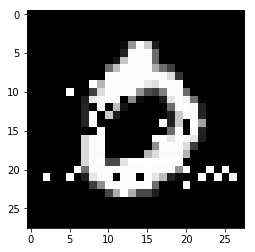

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.03316326530612245


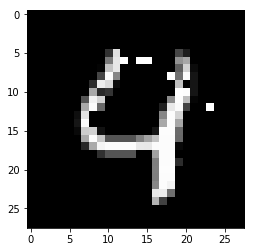

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.012755102040816327


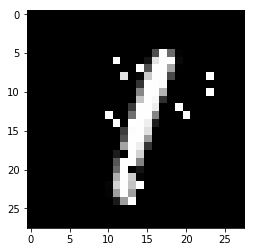

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.017857142857142856


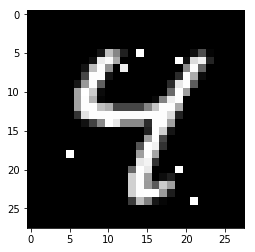

The classification label following attack is 8 from an original classification of 4
The L0 distance of the adversary is 0.007653061224489796


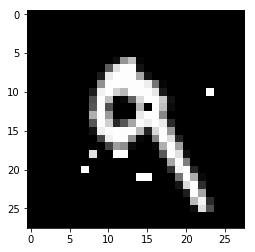

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.01020408163265306


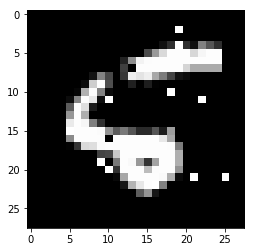

The classification label following attack is 6 from an original classification of 5
The L0 distance of the adversary is 0.016581632653061226


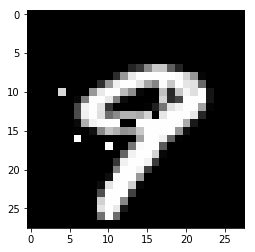

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.007653061224489796


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_l0_PointWiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_predictions, model_weights="/MNIST_LeNet5_CNN.ckpt", var_list=var_list_LeNet,
    num_images_to_attack=num_images_to_attack, temp_batch_size=None)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))


The success ratio is 1.0
The mean distance is 0.020663265306122454


The Point-Wise attack is able to achieve 100% misclassification against the binding CNN with a mean l-0 distance of 0.0233. This is a larger distance than that required against the binding CNN, arguing against increased adversarial resistance through the 'binding' representations. Note these results were obtained from 100 images. 

####Binding CNN

INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


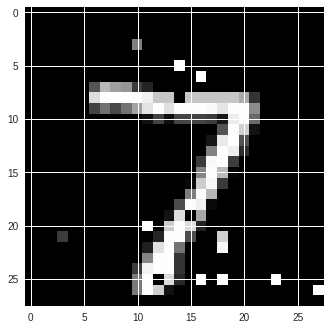

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


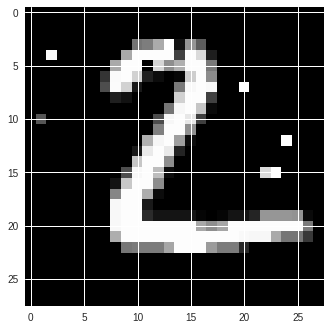

The classification label following attack is 6 from an original classification of 2
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


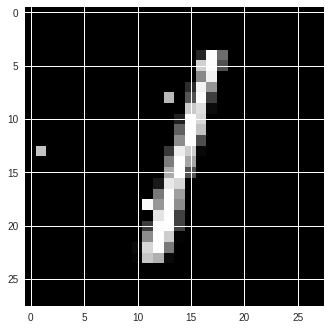

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


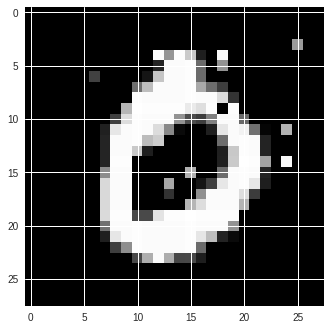

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.015306122448979591
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


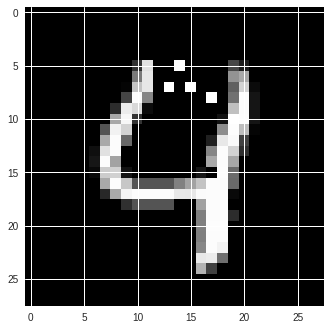

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


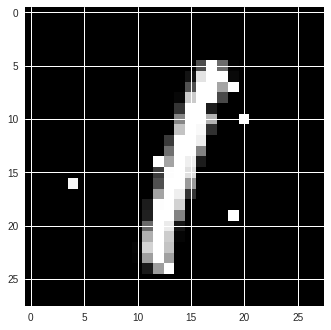

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


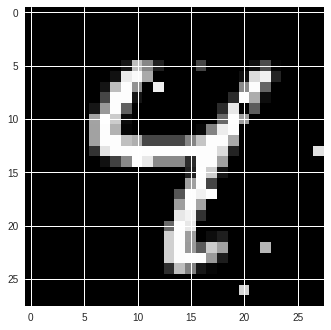

The classification label following attack is 8 from an original classification of 4
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


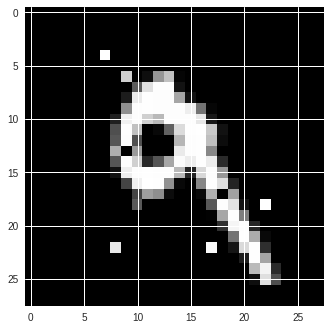

The classification label following attack is 3 from an original classification of 9
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


The model predicted a 6 when the ground-truth label is 5


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


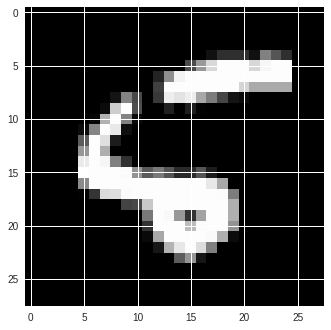

The classification label following attack is 6 from an original classification of 5
The L0 distance of the adversary is 0.0
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


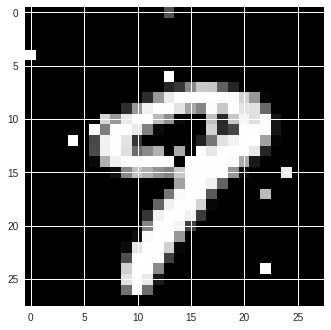

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


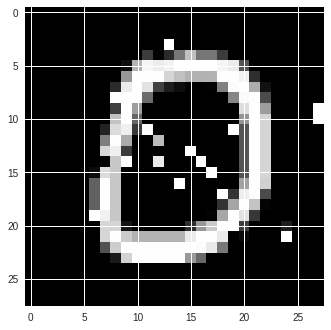

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.02423469387755102
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


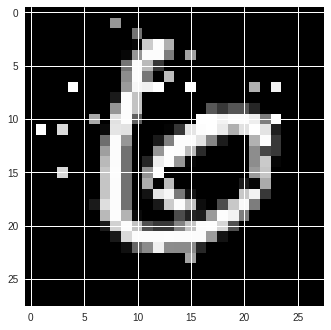

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.029336734693877552
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


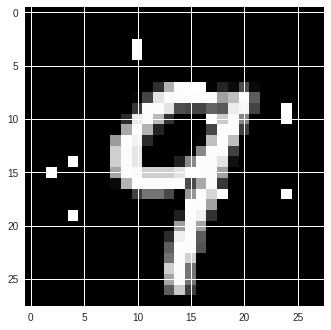

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.01403061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


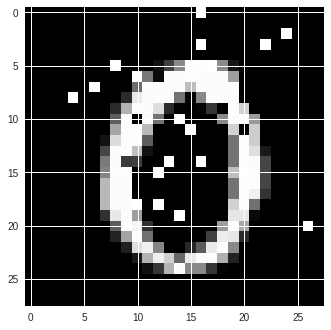

The classification label following attack is 5 from an original classification of 0
The L0 distance of the adversary is 0.030612244897959183
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


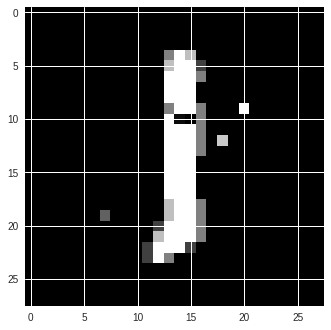

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


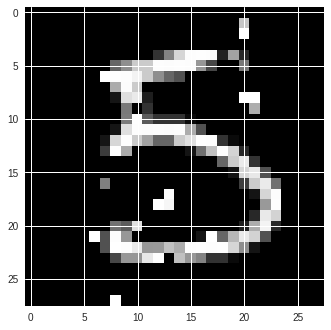

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.02295918367346939
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


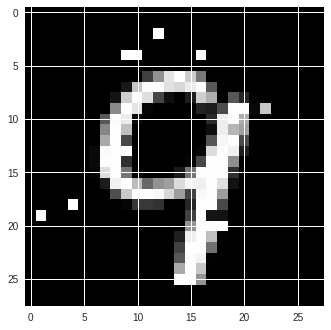

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.01403061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


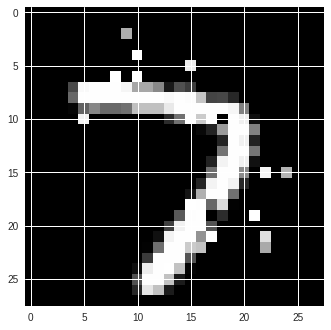

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.02423469387755102
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


The model predicted a 8 when the ground-truth label is 3


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


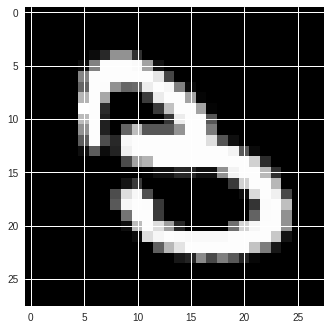

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.0
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


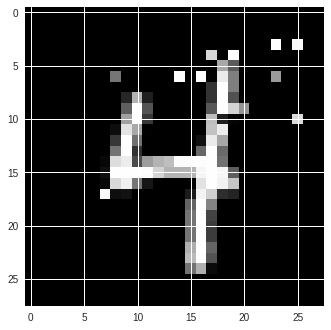

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


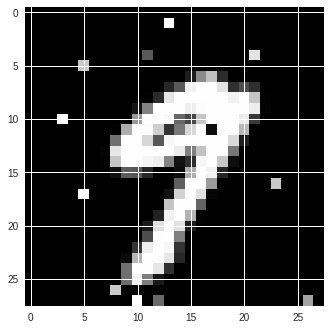

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


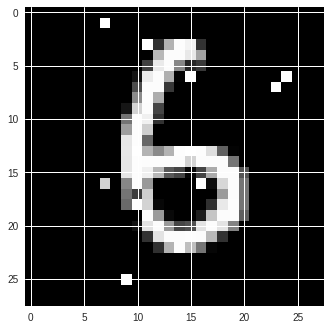

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


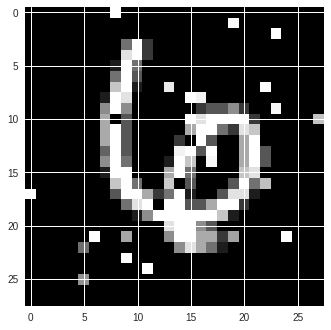

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.03826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


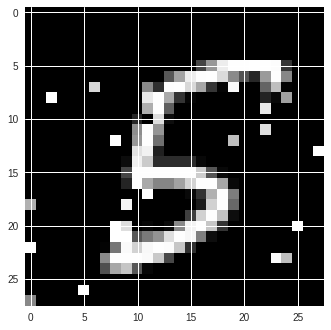

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.03188775510204082
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


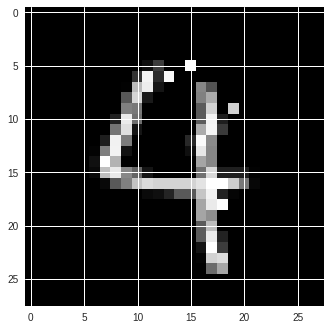

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


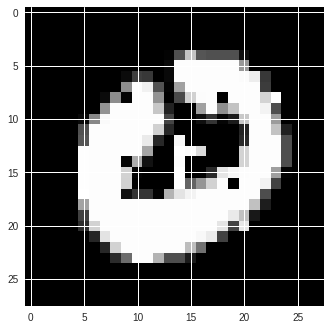

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.02040816326530612
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


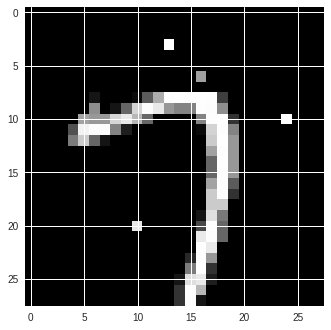

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


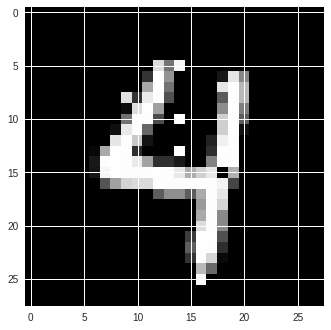

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.008928571428571428
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


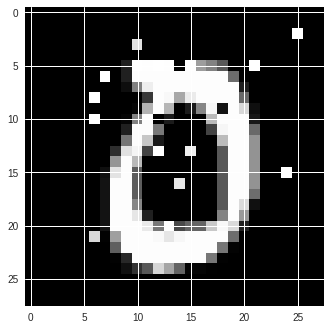

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


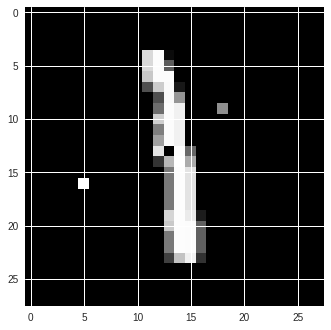

The classification label following attack is 5 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


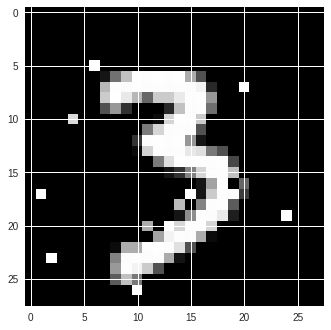

The classification label following attack is 7 from an original classification of 3
The L0 distance of the adversary is 0.015306122448979591
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


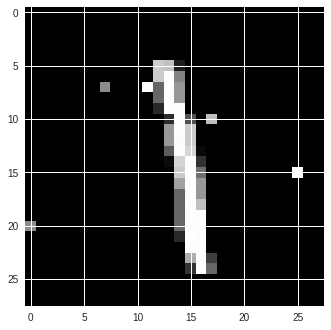

The classification label following attack is 7 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


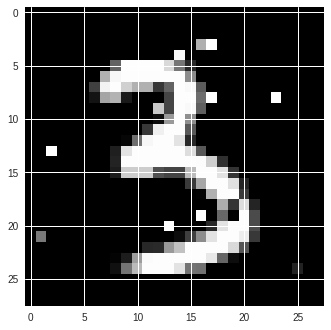

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


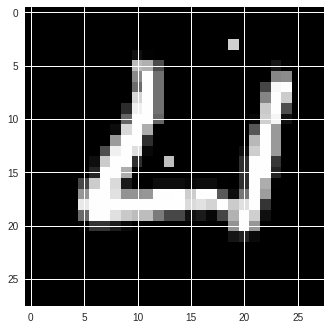

The classification label following attack is 6 from an original classification of 4
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


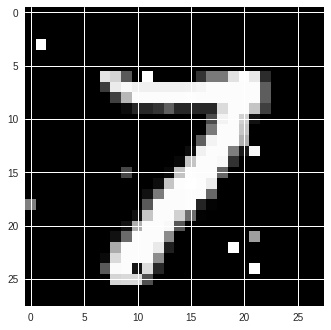

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


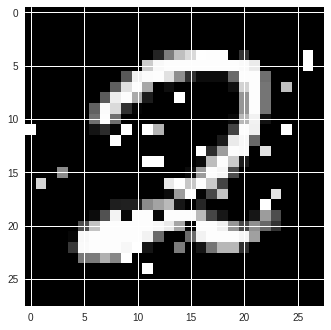

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.044642857142857144
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


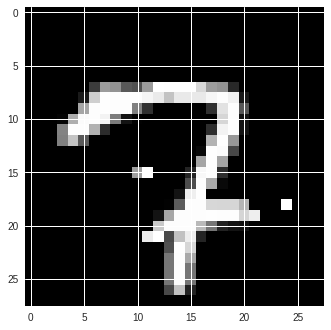

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


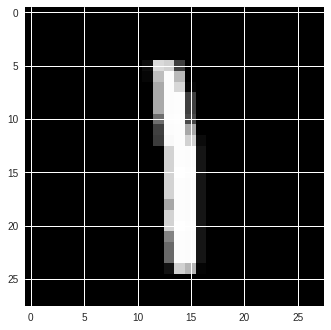

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


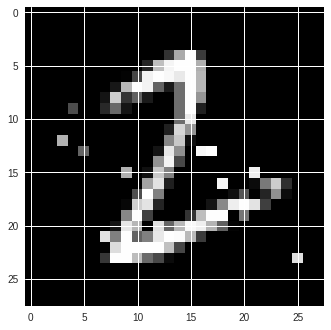

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.02040816326530612
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


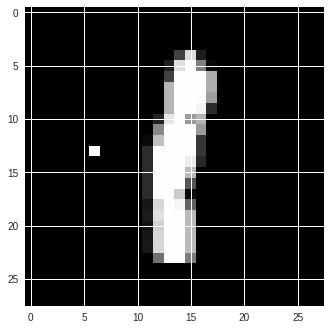

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


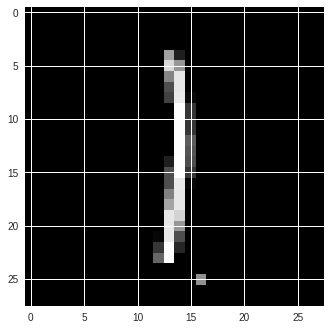

The classification label following attack is 2 from an original classification of 1
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


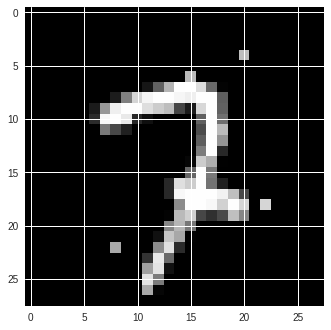

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


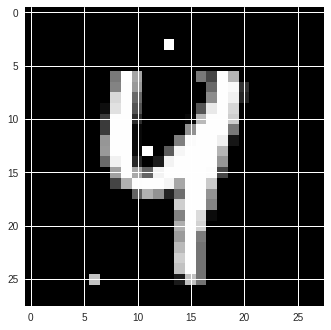

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


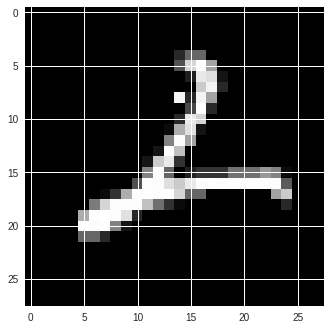

The classification label following attack is 6 from an original classification of 2
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


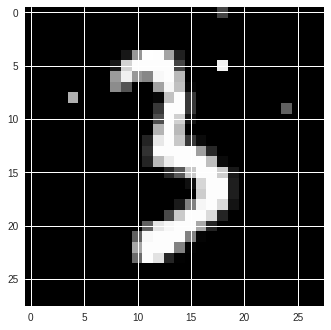

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


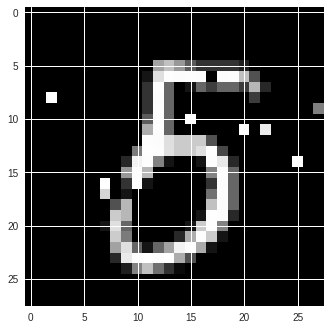

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


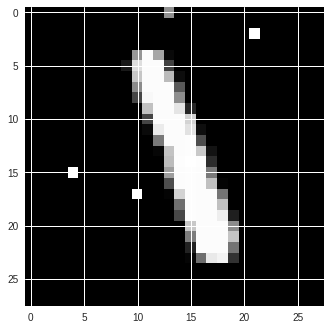

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


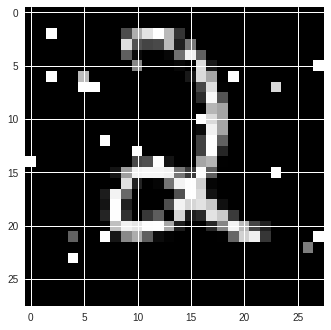

The classification label following attack is 4 from an original classification of 2
The L0 distance of the adversary is 0.03188775510204082
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


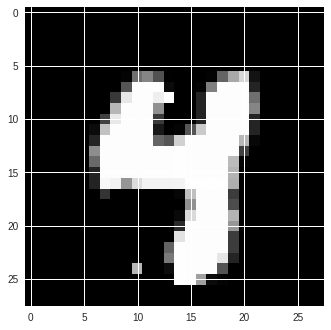

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


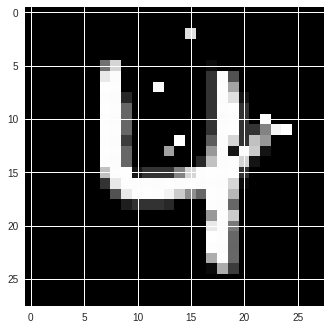

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


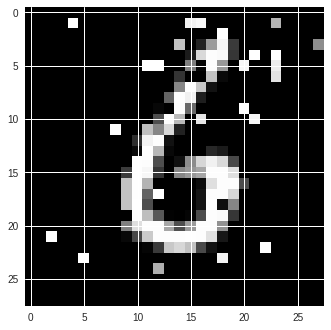

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.042091836734693876
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


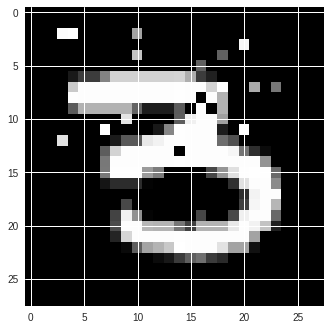

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.02423469387755102
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


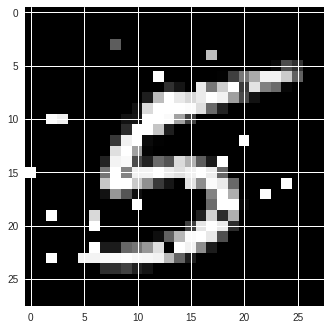

The classification label following attack is 2 from an original classification of 5
The L0 distance of the adversary is 0.03443877551020408
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


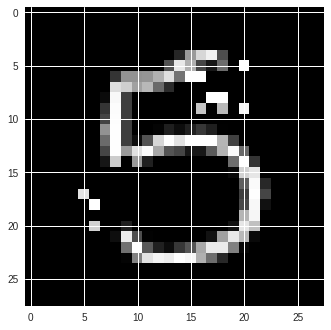

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.016581632653061226
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


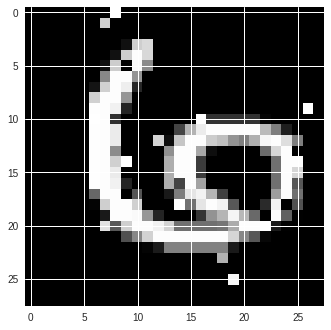

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.02295918367346939
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


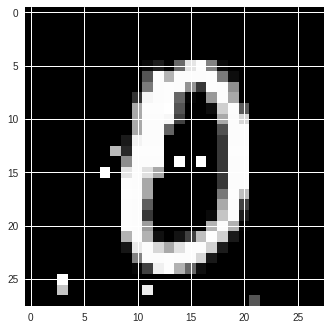

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


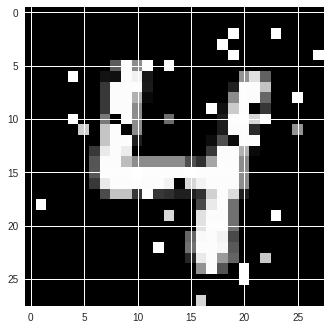

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.039540816326530615
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


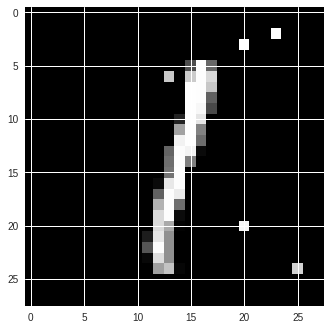

The classification label following attack is 2 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


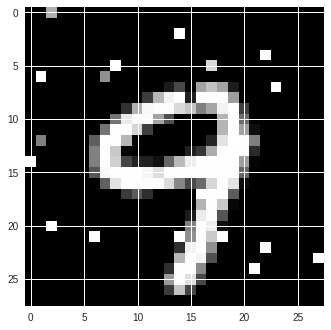

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


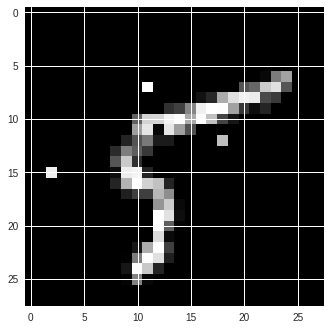

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


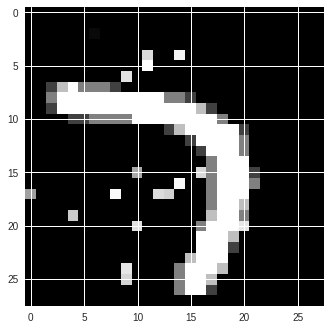

The classification label following attack is 3 from an original classification of 7
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


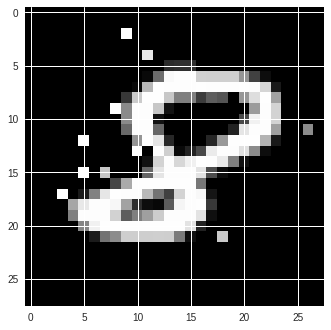

The classification label following attack is 2 from an original classification of 8
The L0 distance of the adversary is 0.015306122448979591
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


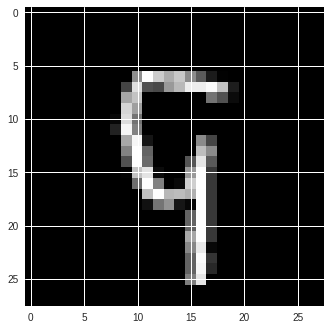

The classification label following attack is 5 from an original classification of 9
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


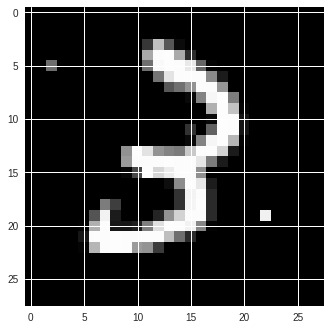

The classification label following attack is 2 from an original classification of 3
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


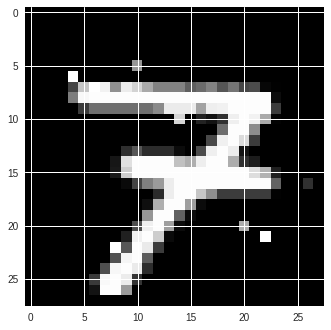

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.011479591836734694
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


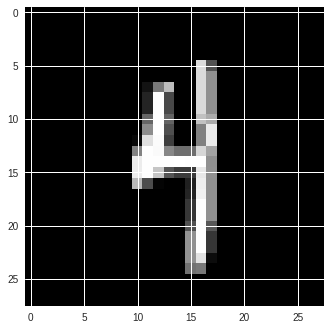

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.0012755102040816326
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


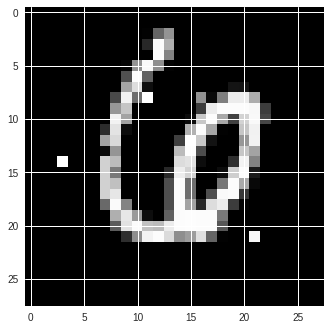

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


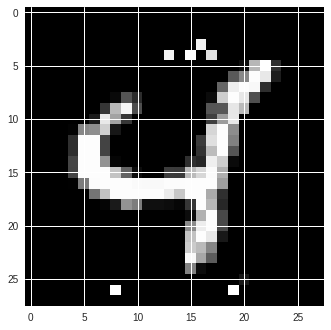

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


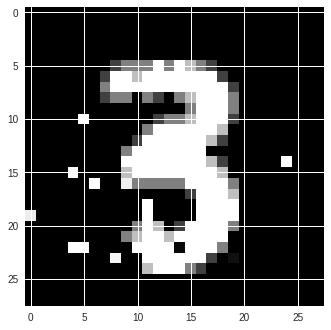

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


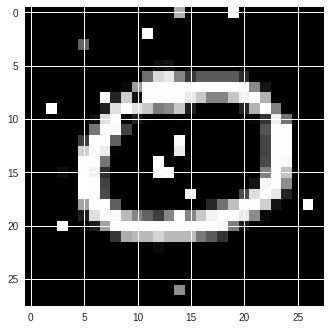

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


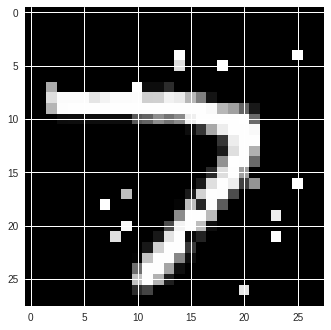

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


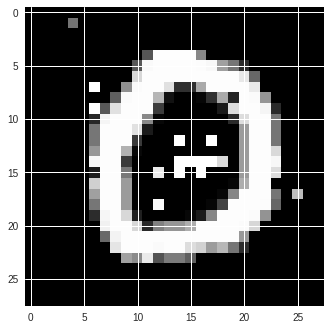

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.02295918367346939
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


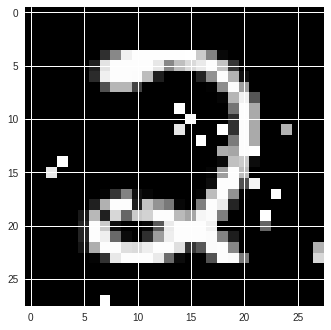

The classification label following attack is 3 from an original classification of 2
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


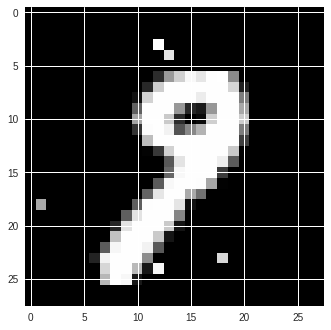

The classification label following attack is 2 from an original classification of 9
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


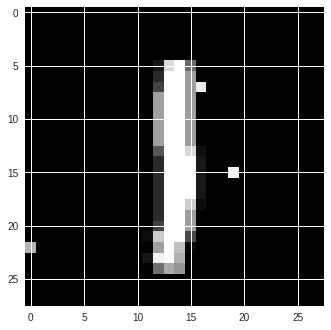

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


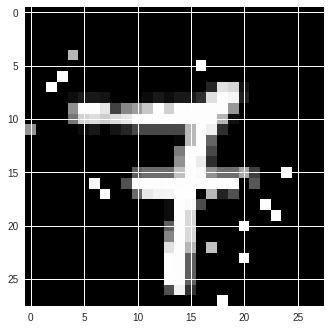

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


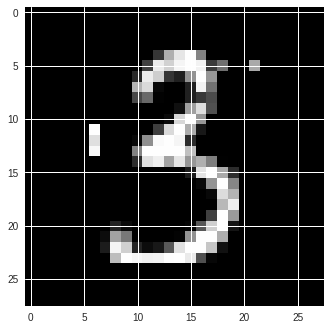

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.007653061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


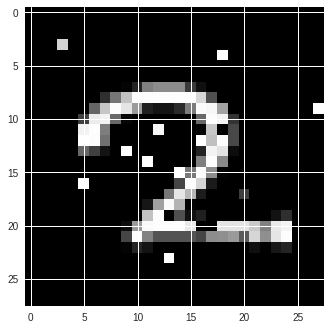

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.01913265306122449
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


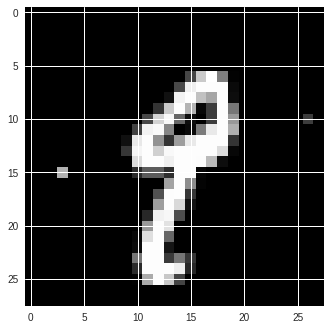

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


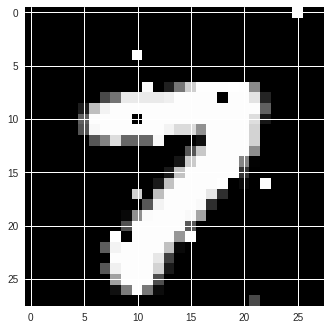

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.02040816326530612
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


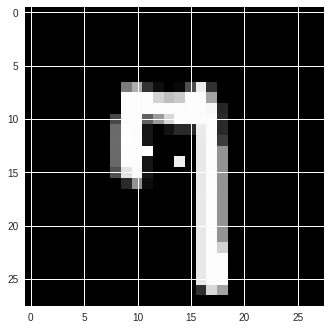

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


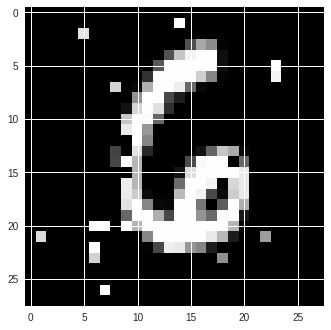

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


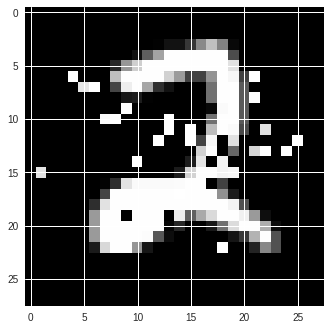

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.039540816326530615
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


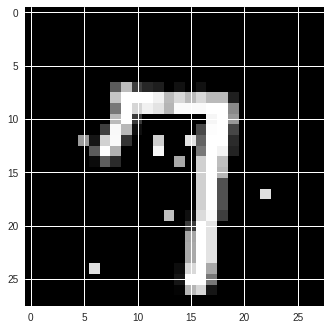

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.01020408163265306
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


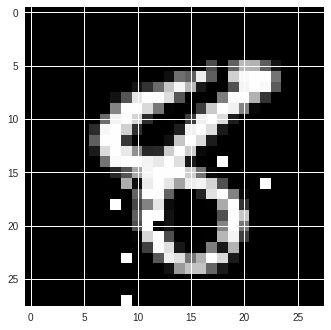

The classification label following attack is 5 from an original classification of 8
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


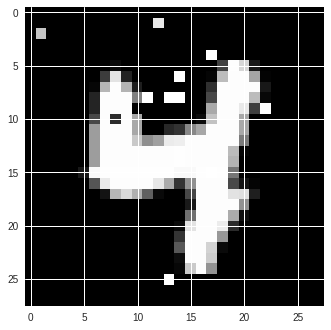

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.01403061224489796
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


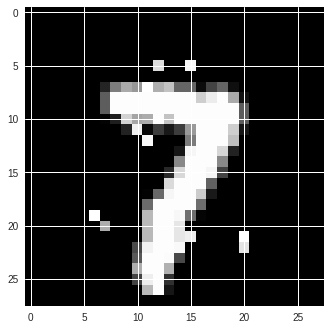

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.012755102040816327
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


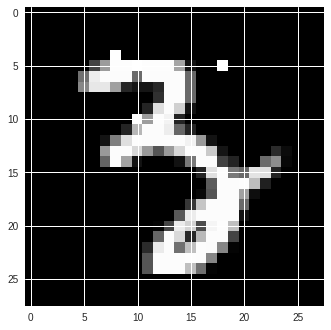

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


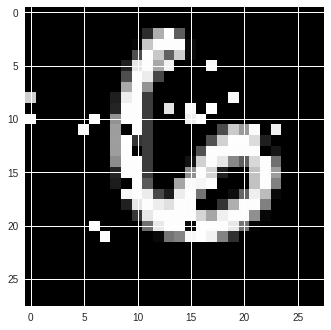

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.030612244897959183
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


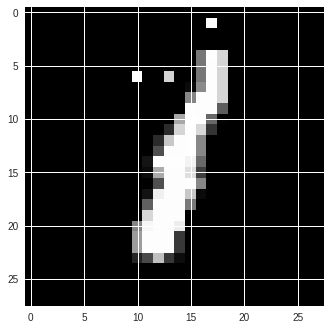

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


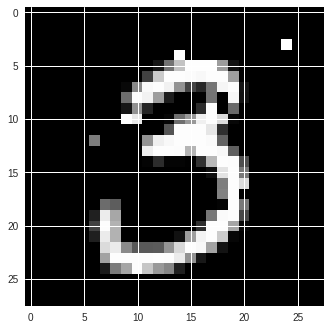

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.011479591836734694
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


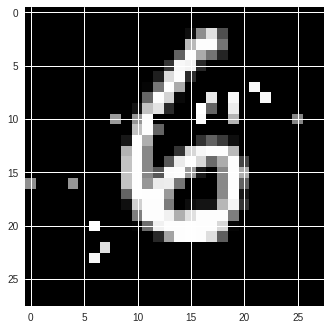

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.021683673469387755
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


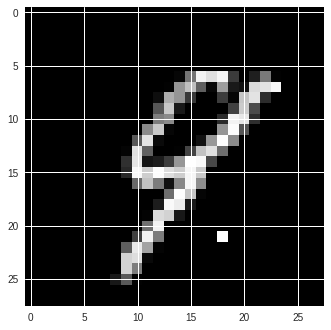

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.002551020408163265
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


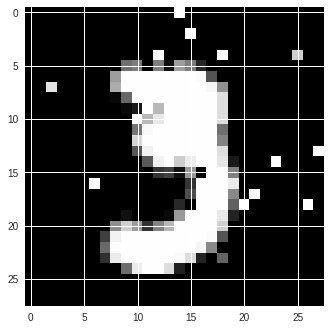

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.025510204081632654
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


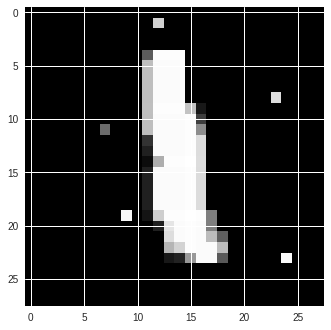

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


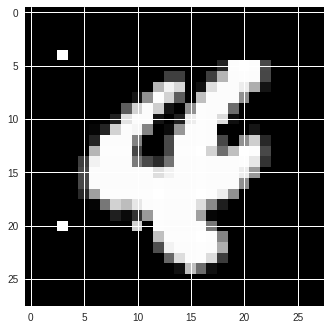

The classification label following attack is 6 from an original classification of 4
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


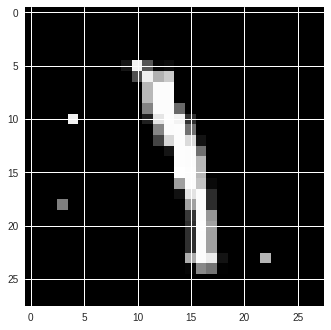

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.00510204081632653
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


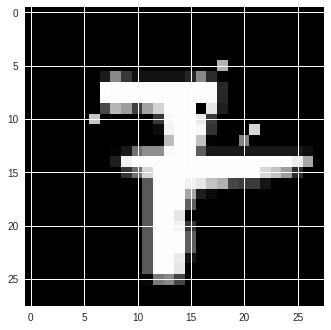

The classification label following attack is 8 from an original classification of 7
The L0 distance of the adversary is 0.006377551020408163
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


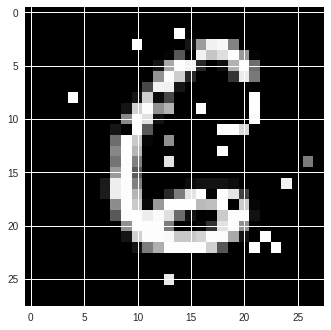

The classification label following attack is 2 from an original classification of 6
The L0 distance of the adversary is 0.03188775510204082
INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


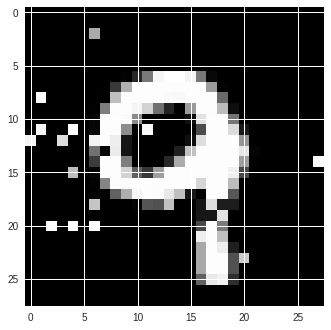

The classification label following attack is 2 from an original classification of 9
The L0 distance of the adversary is 0.02806122448979592


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_l0_PointWiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_binding_predictions, model_weights="/Binding_CNN.ckpt", var_list=var_list_Binding,
    num_images_to_attack=num_images_to_attack, temp_batch_size=1)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))


The success ratio is 1.0
The mean distance is 0.014719387755102042


The Point-Wise attack is able to achieve 100% misclassification against the binding CNN with a mean l-0 distance of 0.0147. This is a smaller distance than that required against the standard CNN, arguing against increased adversarial resistance. Note these results were obtained from 100 images. 

##Basic Iterative (Gradient-Based) Attack

L-infinity minimising, gradient based method.

###BIM Attack Functions for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def BIM_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, test_label, temp_batch_size):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.LinfinityBasicIterativeAttack(model=fmodel, criterion=foolbox.criteria.Misclassification(),
                                                                     distance=foolbox.distances.Linfinity)
        adversarial_image_fmodel = attack_fmodel(test_image, test_label, epsilon=0.001)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

###Visualize the BIM Attack

INFO:tensorflow:Restoring parameters from /MNIST_LeNet5_CNN.ckpt


INFO:tensorflow:Restoring parameters from /MNIST_LeNet5_CNN.ckpt


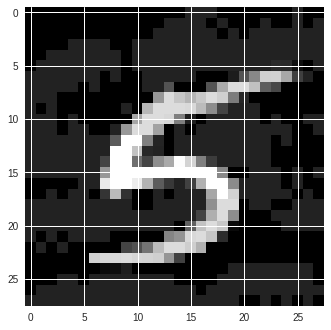

The classification label following attack is 4 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = BIM_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None)


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


INFO:tensorflow:Restoring parameters from /Binding_CNN.ckpt


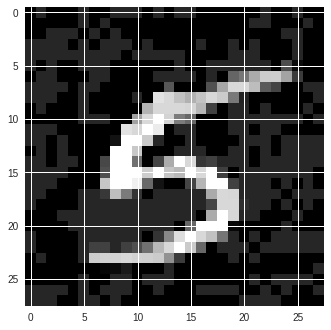

The classification label following attack is 6 from an original classification of 5


In [0]:
adversarial_image_fmodel, adversarial_label_fmodel = BIM_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                  var_list=var_list_Binding,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1)


##Blended Uniform Noise Attack

###Blended Uniform Noise Attack Function for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function, model_weights, 
                                                     var_list, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.BlendedUniformNoiseAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
# *** this code can eventually be refractored with earlier functions

#Iterate through a series of images to be attacked
def evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(model_prediction_function, model_weights, 
                                                              var_list, num_images_to_attack, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                     keep_prob=1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
        
    return adversary_found, adversary_distance, adversary_arrays

###Blended Uniform Noise Attack Function for the Keras Models

In [0]:
#Function to iterate through a series of images to be attacked
def evaluate_BlendedUniformNoiseAttack_resistance_MadryModel(num_images_to_attack):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, Madry_testing_data.shape[1]])
    
    for ii in range(num_images_to_attack):
        test_image_Madry = Madry_testing_data[ii, :]
        test_label_Madry = np.argmax(Madry_testing_labels[ii,:])

        Madry_attack = foolbox.attacks.BlendedUniformNoiseAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
        Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry)
        adversary_arrays[ii, :] = Madry_adversarial_image
        
        # **** need to check this logical statement for accuracy
        if np.any(np.any(Madry_adversarial_image == None) | (Madry_model.predictions(Madry_adversarial_image) == test_label_Madry)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image_Madry, Madry_adversarial_image)
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance

    return adversary_found, adversary_distance, adversary_arrays


###Visualize the Attack

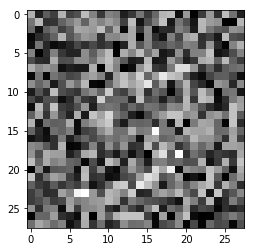

The classification label following attack is 8 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                                                     keep_prob=1.0)


###Quantify Vulnerability

In [0]:
num_images_to_attack=50

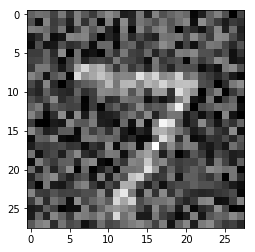

The classification label following attack is 5 from an original classification of 7
The L2 distance of the adversary is 8.831406646497449


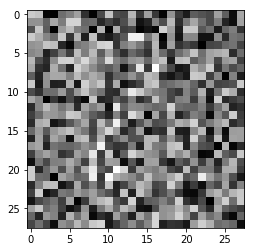

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 13.101077755262716


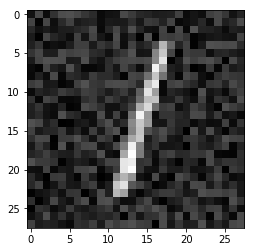

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 5.007629106017482


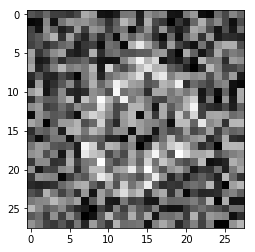

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.26329647700372


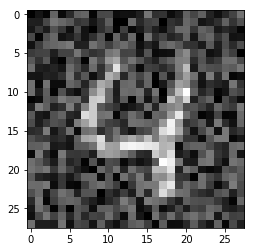

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 7.487200682614683


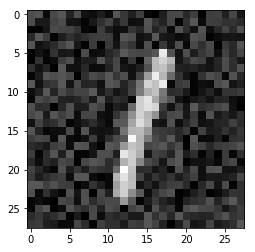

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 5.528495641950864


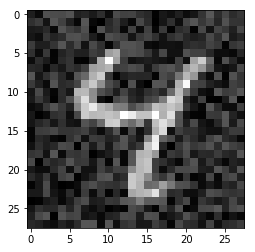

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 5.386947992511152


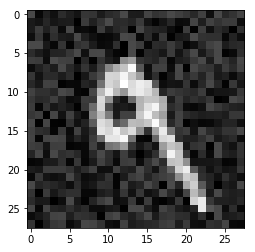

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 4.619717528554763
The model predicted a 6 when the ground-truth label is 5


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


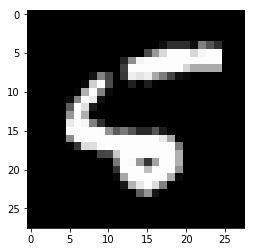

The classification label following attack is 6 from an original classification of 5
The L2 distance of the adversary is 0.0


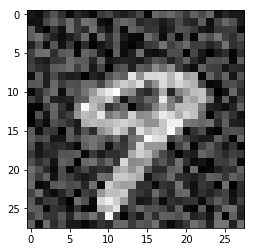

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 6.994633436422234


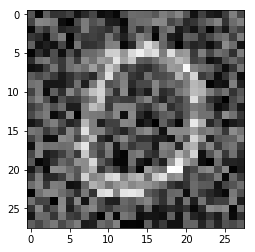

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 8.730618488475745


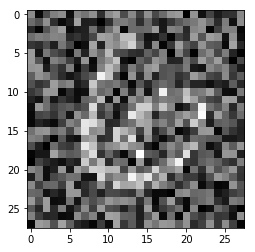

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 9.636821840394205


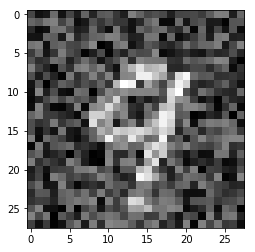

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 8.359431607519365


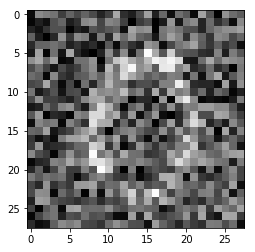

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 10.27209582696262


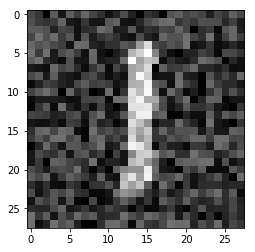

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 6.953147235993673


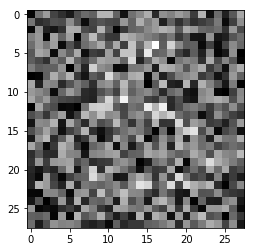

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 11.520758167322521


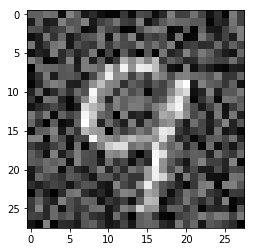

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 8.07759599746131


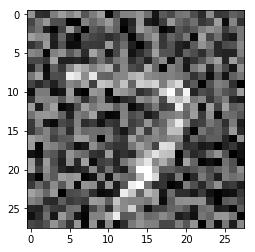

The classification label following attack is 3 from an original classification of 7
The L2 distance of the adversary is 10.047529563043714
The model predicted a 8 when the ground-truth label is 3


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


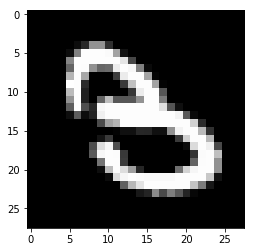

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 0.0


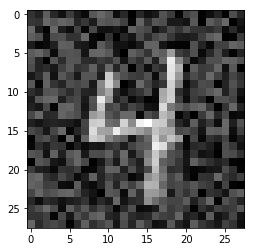

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 6.513853743843189


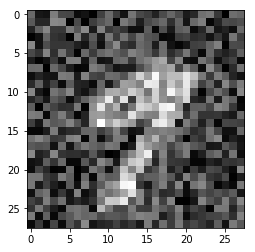

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 8.41682936283411


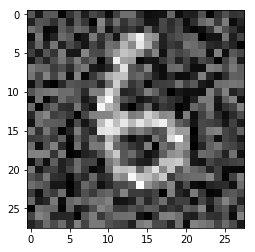

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 7.922039258226234


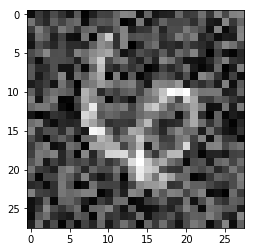

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 8.336953547419222


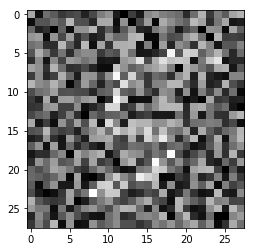

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 11.014863016778229


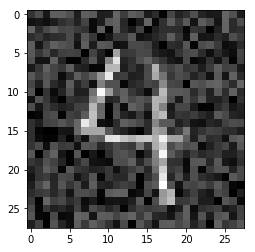

The classification label following attack is 5 from an original classification of 4
The L2 distance of the adversary is 6.076342465160233


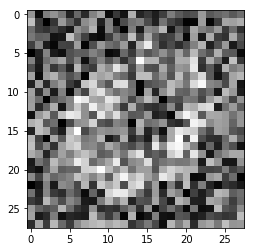

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.564851912262775


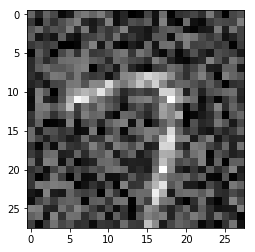

The classification label following attack is 5 from an original classification of 7
The L2 distance of the adversary is 8.095635276706659


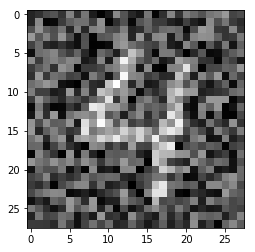

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 9.387986588142274


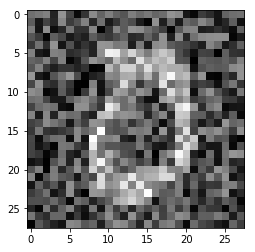

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 9.384290087253218


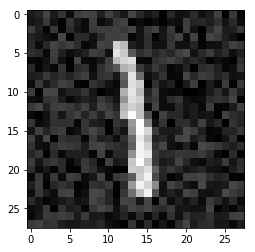

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 4.382912077739014


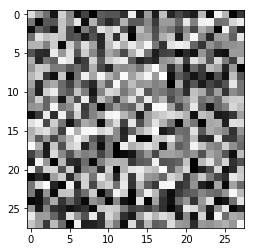

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 15.038896550191254


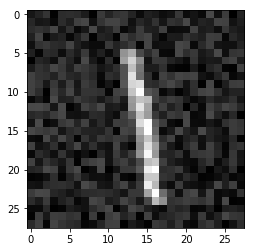

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 4.608210182065918


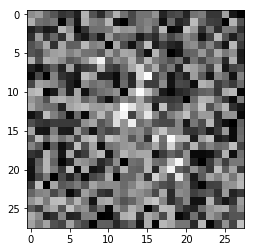

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 12.011996828189867


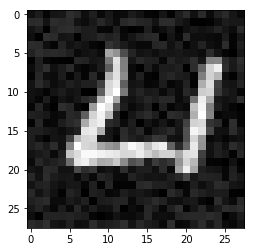

The classification label following attack is 6 from an original classification of 4
The L2 distance of the adversary is 2.879718769739149


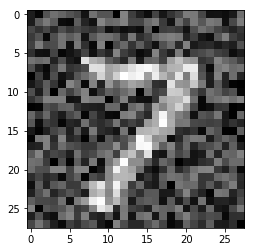

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 8.143570047255364


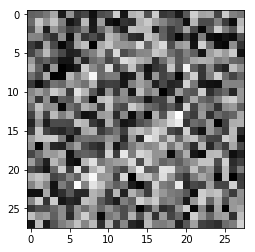

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 12.496499219881581


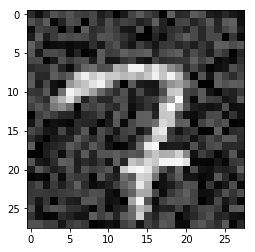

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 5.919672018725292


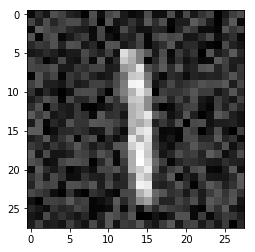

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 5.677489049092258


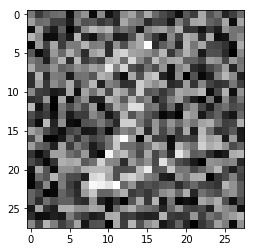

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 11.100735722159456


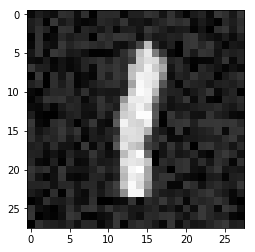

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 3.670692333445949


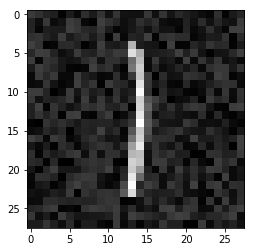

The classification label following attack is 2 from an original classification of 1
The L2 distance of the adversary is 3.919544159119132


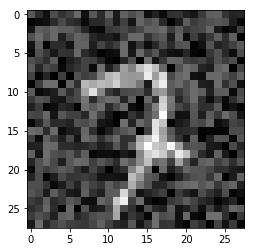

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 6.859988490422061


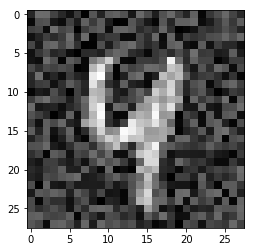

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 6.86685094072154


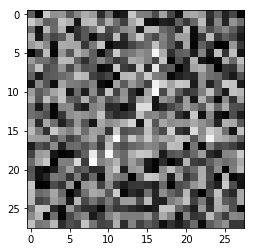

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 12.277684808493428


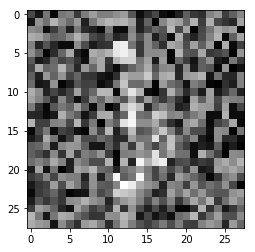

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 10.90567868151072


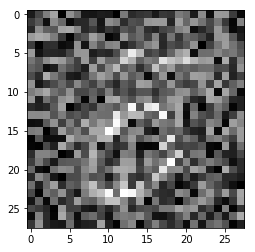

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 10.395345557762887


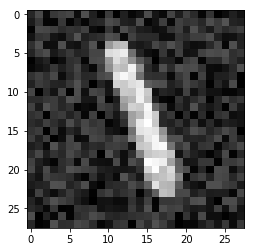

The classification label following attack is 3 from an original classification of 1
The L2 distance of the adversary is 5.114222325538802


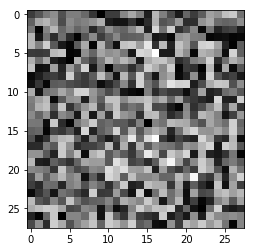

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 12.672939054359206


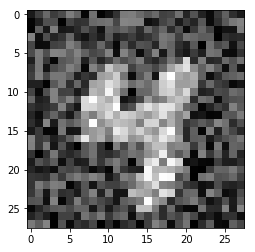

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.261774564186846


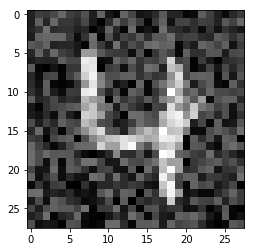

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 6.842328682370097


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_predictions, model_weights="/MNIST_LeNet5_CNN.ckpt", var_list=var_list_LeNet,
    num_images_to_attack=num_images_to_attack, temp_batch_size=None)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Standard_mean, Standard_var, Standard_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Standard_mean))
print("Variance: " + str(Standard_var))
print("Standard deviation: " + str(Standard_std))


The success ratio is 1.0
Mean: Mean(statistic=7.971575986312084, minmax=(7.202157665277472, 8.740994307346696))
Variance: Variance(statistic=10.97892430962212, minmax=(7.778413510020756, 15.207922037415122))
Standard deviation: Std_dev(statistic=3.295869387661391, minmax=(2.7889807295893525, 3.899733585440821))


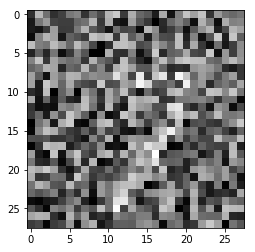

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 12.037280682678034


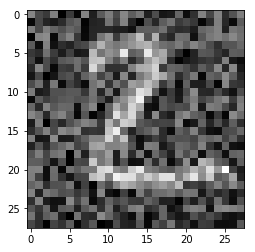

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 8.740392005193206


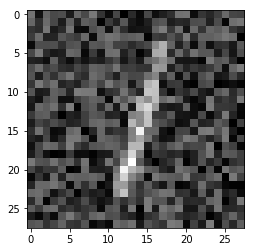

The classification label following attack is 6 from an original classification of 1
The L2 distance of the adversary is 7.722775702693177


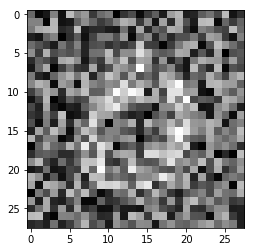

The classification label following attack is 7 from an original classification of 0
The L2 distance of the adversary is 11.665619229375967


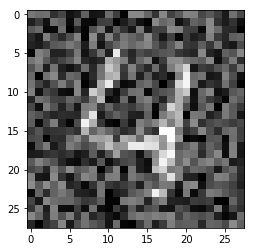

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 8.551442245464816


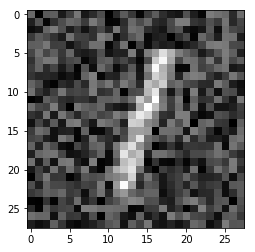

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 7.778309977600876


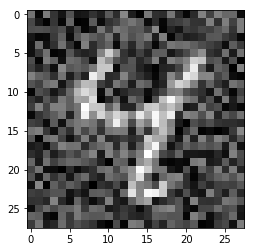

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.057528619305767


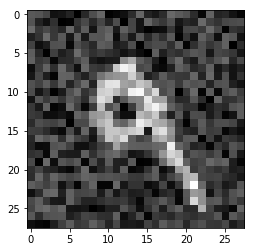

The classification label following attack is 3 from an original classification of 9
The L2 distance of the adversary is 6.694534561380482


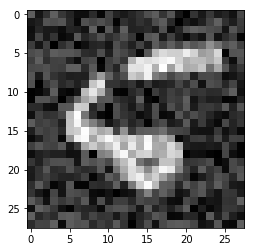

The classification label following attack is 6 from an original classification of 5
The L2 distance of the adversary is 5.956591331772009


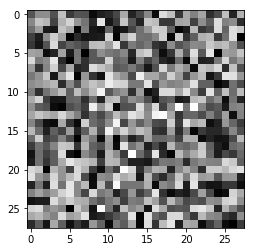

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 14.15966401273755


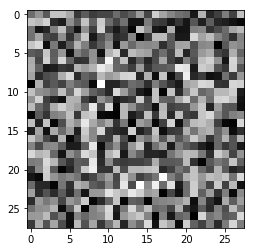

The classification label following attack is 7 from an original classification of 0
The L2 distance of the adversary is 13.091500186219


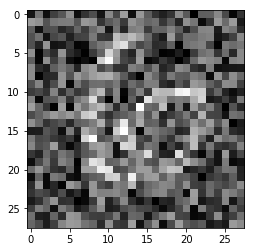

The classification label following attack is 0 from an original classification of 6
The L2 distance of the adversary is 9.626128281417543


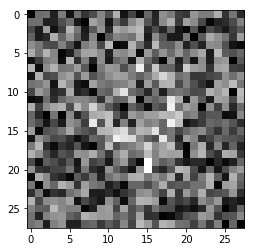

The classification label following attack is 3 from an original classification of 9
The L2 distance of the adversary is 11.334384925094986


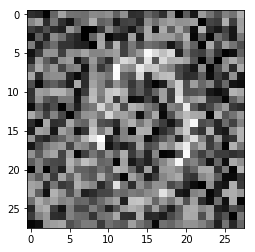

The classification label following attack is 7 from an original classification of 0
The L2 distance of the adversary is 11.416019249710853


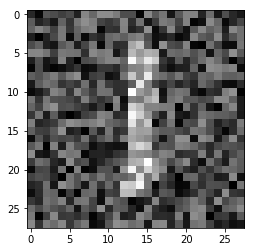

The classification label following attack is 3 from an original classification of 1
The L2 distance of the adversary is 9.19366778555512


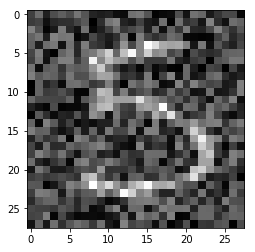

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 8.043494595103532


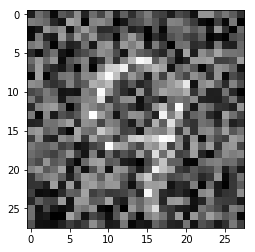

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 9.985541148925854


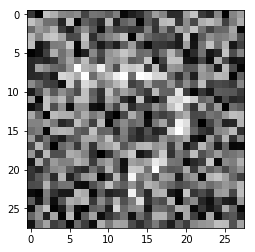

The classification label following attack is 9 from an original classification of 7
The L2 distance of the adversary is 12.360105154999667


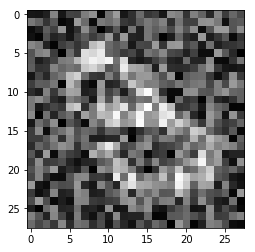

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 9.347328344972912


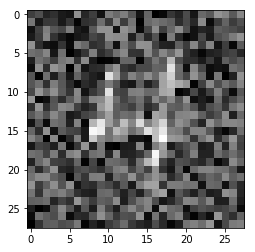

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 9.166518924117657


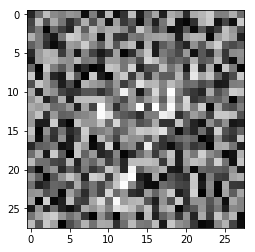

The classification label following attack is 0 from an original classification of 9
The L2 distance of the adversary is 13.145692270417237


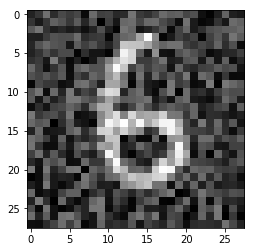

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 7.058818207305713


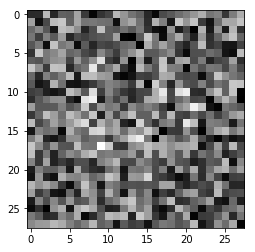

The classification label following attack is 0 from an original classification of 6
The L2 distance of the adversary is 12.163376707512004


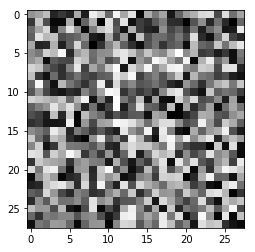

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 14.683741012741875


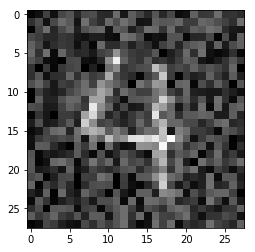

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 7.112909921885986


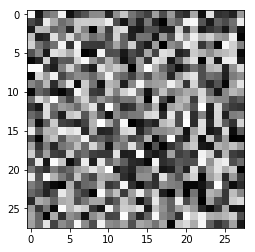

The classification label following attack is 5 from an original classification of 0
The L2 distance of the adversary is 15.167929019148438


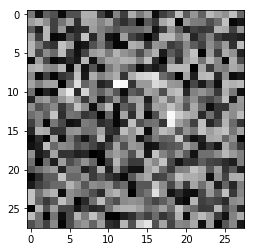

The classification label following attack is 9 from an original classification of 7
The L2 distance of the adversary is 12.425273261899793


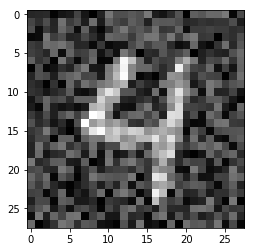

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 7.417486628160709


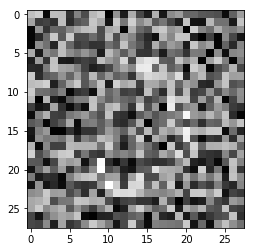

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 12.91408777537541


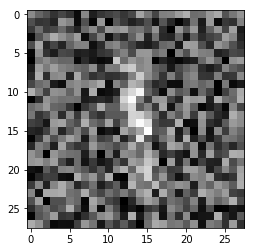

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 10.526674331575325


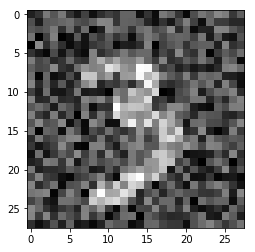

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.648169555267737


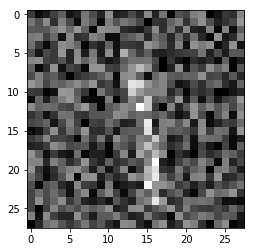

The classification label following attack is 7 from an original classification of 1
The L2 distance of the adversary is 9.330082369716022


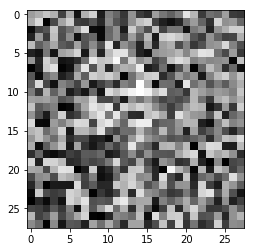

The classification label following attack is 7 from an original classification of 3
The L2 distance of the adversary is 13.8356447102477


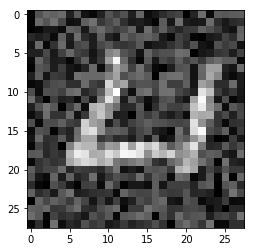

The classification label following attack is 0 from an original classification of 4
The L2 distance of the adversary is 6.993221664407599


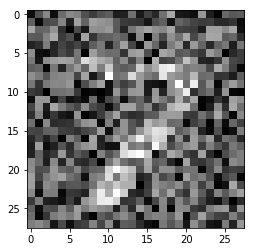

The classification label following attack is 3 from an original classification of 7
The L2 distance of the adversary is 10.430047994990908


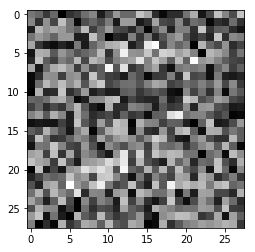

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 11.957706256727668


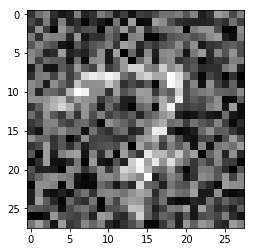

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 9.68852346135922


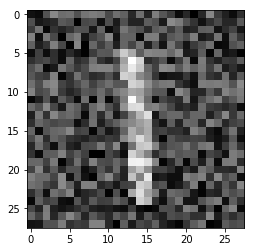

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.32552674345878


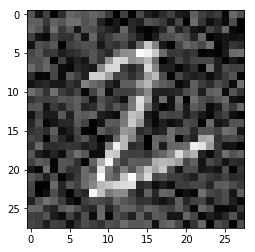

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 6.703894816827879


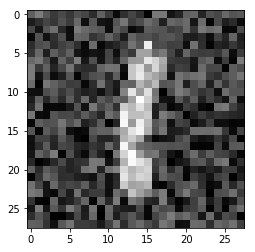

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.528815169792858


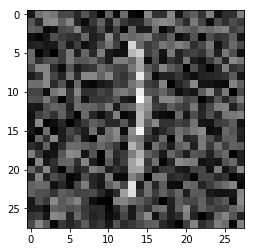

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.316031599425324


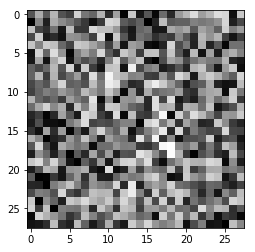

The classification label following attack is 4 from an original classification of 7
The L2 distance of the adversary is 13.343885666643885


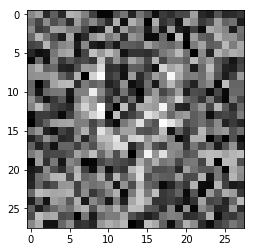

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 11.538079521719212


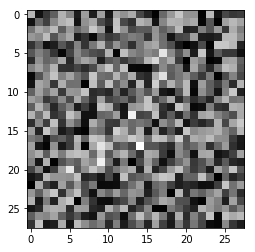

The classification label following attack is 3 from an original classification of 2
The L2 distance of the adversary is 11.986718981349629


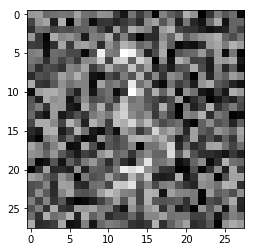

The classification label following attack is 7 from an original classification of 3
The L2 distance of the adversary is 11.150691326797416


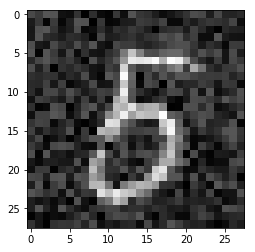

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 5.338842338223172


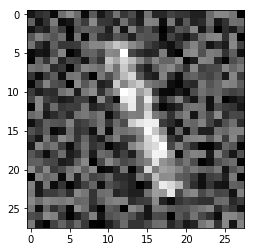

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.923399846818265


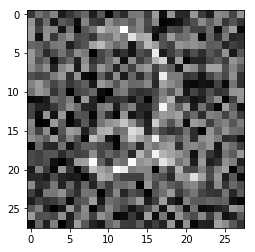

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 9.836695660049415


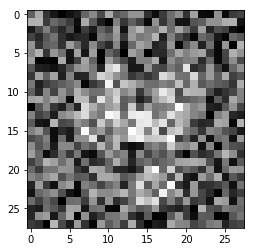

The classification label following attack is 7 from an original classification of 4
The L2 distance of the adversary is 11.117086776134286


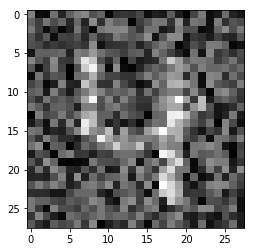

The classification label following attack is 7 from an original classification of 4
The L2 distance of the adversary is 8.99364223291218


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_binding_predictions, model_weights="/Binding_CNN.ckpt", var_list=var_list_Binding,
    num_images_to_attack=num_images_to_attack, temp_batch_size=1)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Binding_mean, Binding_var, Binding_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Binding_mean))
print("Variance: " + str(Binding_var))
print("Standard deviation: " + str(Binding_std))


The success ratio is 1.0
Mean: Mean(statistic=10.030630455864213, minmax=(9.451874494688912, 10.609386417039511))
Variance: Variance(statistic=6.211917781146273, minmax=(4.401056408564438, 8.604701030292173))
Standard deviation: Std_dev(statistic=2.4791508120046513, minmax=(2.0978694927388686, 2.9333770692313275))


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_MadryModel(num_images_to_attack)

The L2 distance of the adversary is 8.005849908340366
The L2 distance of the adversary is 10.005828230529499
The L2 distance of the adversary is 7.522331022113272
The L2 distance of the adversary is 8.983351234904108
The L2 distance of the adversary is 8.226329185942001
The L2 distance of the adversary is 7.6779823171430985
The L2 distance of the adversary is 7.543810225361129
The L2 distance of the adversary is 7.072396103714931
The L2 distance of the adversary is 7.586430672365147
The L2 distance of the adversary is 8.274750829994264
The L2 distance of the adversary is 9.555826011103795
The L2 distance of the adversary is 8.115364259159021
The L2 distance of the adversary is 8.273763066976562
The L2 distance of the adversary is 11.515139801805454
The L2 distance of the adversary is 8.712956274527587
The L2 distance of the adversary is 9.218722371435955
The L2 distance of the adversary is 8.709055548983946
The L2 distance of the adversary is 7.676141767049601
The L2 distance of the ad

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Madry_mean, Madry_var, Madry_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Madry_mean))
print("Variance: " + str(Madry_var))
print("Standard deviation: " + str(Madry_std))

The success ratio is 1.0
Mean: Mean(statistic=8.618366717964175, minmax=(8.222040619507457, 9.014692816420894))
Variance: Variance(statistic=2.912997341968315, minmax=(2.063817660129289, 4.035061652900345))
Standard deviation: Std_dev(statistic=1.6976968441280653, minmax=(1.43659933876126, 2.0087462888329988))


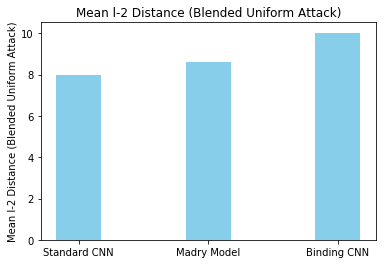

In [0]:
#Results form Blended Uniform attack

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')
Blended_distance = np.zeros([1,3])
Blended_distance[0,0] = Standard_mean[0]
Blended_distance[0,1] = Madry_mean[0]
Blended_distance[0,2] = Binding_mean[0]

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Blended_distance[0,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean l-2 Distance (Blended Uniform Attack)')
plt.title('Mean l-2 Distance (Blended Uniform Attack)')
plt.show()

#Visualizaiton of Results

In [0]:
#Overview of the results
#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:1 correspond to accuracy against one's own adversarial examples during generation
Boundary_attack_results = np.zeros([2,3])
Boundary_attack_results[0,0] = 1.0 #Standard CNN
Boundary_attack_results[1,0] = 1.591

Boundary_attack_results[0,1] = 1.0 #Madry model
Boundary_attack_results[1,1] = 1.433

Boundary_attack_results[0,2] = 0.24 #Binding model
Boundary_attack_results[1,2] = 8.328


#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:2 correspond to performance on adversaries from the Standard CNN, Madry model, and the binding model respectively
Transfer_attack_results = np.zeros([3,3])

Transfer_attack_results[0,0] = 1
Transfer_attack_results[1,0] = 0.333
Transfer_attack_results[2,0] = 0.378

Transfer_attack_results[0,1] = 0.155
Transfer_attack_results[1,1] = 1
Transfer_attack_results[2,1] = 0.267

Transfer_attack_results[0,2] = 0.267
Transfer_attack_results[1,2] = 0.083
Transfer_attack_results[2,2] = 1

Transfer_attack_results = Transfer_attack_results #Normalize the results

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')

In [0]:
### *** Boundary attack results with binding net removed

Boundary_attack_results = np.zeros([2,2])
Boundary_attack_results[0,0] = 1.0 #Standard CNN
Boundary_attack_results[1,0] = 1.591

Boundary_attack_results[0,1] = 1.0 #Madry model
Boundary_attack_results[1,1] = 1.433

model_labels = ('Standard CNN', 'Madry Model')

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1], Boundary_attack_results[0,:], bar_width, color='IndianRed')
plt.xticks([0, 1], model_labels)
plt.ylabel('Percentage of Adv. Examples Misclassified')
plt.title('Percentage of Adv. Examples Misclassified (Boundary Attack)')
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1], Boundary_attack_results[1,:], bar_width, color='SkyBlue')
plt.xticks([0, 1], model_labels)
plt.ylabel('Mean Euclidian Distance for Misclassificaiton')
plt.title('Mean Euclidian Distance for Misclassificaiton (Boundary Attack)')
plt.show()

In [0]:
fig, ax = plt.subplots()
bar_width = 0.5
ax.grid(False)
plt.bar([0, 1, 2], Boundary_attack_results[1,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean Euclidian Distance for Misclassificaiton')
plt.title('Mean Euclidian Distance for Misclassificaiton (Boundary Attack)')
plt.show()

In [0]:
n_groups = 3
bar_width = 0.35
#_, ax = plt.subplots()
index = np.arange(n_groups)


plt.figure(figsize=(16,10))
plt.grid(False)
results_Standard_examples = plt.bar(index - bar_width/2, Transfer_attack_results[0,:], bar_width, color='IndianRed', label="Standard Adv. Examples")

results_Madry_examples = plt.bar(index, Transfer_attack_results[1,:], bar_width, label="Madry Adv. Examples")

results_Binding_examples = plt.bar(index + bar_width/2, Transfer_attack_results[2,:], bar_width, color='SkyBlue', label="Binding Adv. Examples")

plt.xticks(index, model_labels)
plt.ylabel('Percentage of Misclassification')
plt.title('Percentage of Misclassification (Transfer Attack)')
plt.legend(loc='upper left', frameon=1)
plt.show()

In [0]:
### mean transfer resistance results


#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:2 correspond to performance on adversaries from the Standard CNN, Madry model, and the binding model respectively
Transfer_attack_results = np.zeros([3,3])

Transfer_attack_results[0,0] = 1
Transfer_attack_results[1,0] = 0.333
Transfer_attack_results[2,0] = 0.378

Transfer_attack_results[0,1] = 0.155
Transfer_attack_results[1,1] = 1
Transfer_attack_results[2,1] = 0.267

Transfer_attack_results[0,2] = 0.267
Transfer_attack_results[1,2] = 0.083
Transfer_attack_results[2,2] = 1

Transfer_attack_results = Transfer_attack_results #Normalize the results

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')

In [0]:
Transfer_means = np.zeros([1,3])
Transfer_means[0,0] = np.mean(Transfer_attack_results[:,0])
Transfer_means[0,1] = np.mean(Transfer_attack_results[:,1])
Transfer_means[0,2] = np.mean(Transfer_attack_results[:,2])

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Transfer_means[0,:], bar_width, color='IndianRed')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean Misclassification (Transfer Attack)')
plt.title('Mean Misclassification (Transfer Attack)')
plt.show()

In [0]:
#Results form Blended Uniform attack

Blended_distance = np.zeros([1,3])
Blended_distance[0,0] = 8.526335774869567
Blended_distance[0,1] = 8.559281853495518
Blended_distance[0,2] = 9.433369523695147

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Blended_distance[0,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean l-2 Distance (Blended Uniform Attack)')
plt.title('Mean l-2 Distance (Blended Uniform Attack)')
plt.show()